# Biological Embeddings

In this notebook we will examine the problem of representation learning in biological networks.

## Datasets

As our dataset we use a multirelational network of drug-drug , protein-protein and protein-drug interactions. The dataset used can be found in snap.stanford.edu/decagon . 

# Analysis

We use the GEM library (https://github.com/palash1992/GEM) which offers a variety of node embedding methods including:

* laplacian eigenmaps
* locally linear embedding
* graph factorization
* higher-order proximity preserved embedding
* structural deep network embedding
* node2vec

To analyze the data, we have to export the interactions to edge-list format : node1 node2


In [1]:
import sys
print(sys.version)
import time

2.7.15rc1 (default, Apr 15 2018, 21:51:34) 
[GCC 7.3.0]


In [26]:
dd_A.getnnz()

63473

In [2]:
import pickle
import networkx as nx
import numpy as np

def get_sparsity_csr(A):
    return A.getnnz()/float(A.shape[0]*A.shape[1])


dd_A = pickle.load(open("bio-decagon-combo.pkl","rb"))
dd_G = nx.nx.to_networkx_graph(dd_A,create_using=nx.DiGraph())

print(type(dd_A))
print(dd_A.shape)
print("Non-Sparse Elements: {:0.5f}".format(100*get_sparsity_csr(dd_A)) + "%")
print(nx.number_of_nodes(dd_G))
print(nx.number_of_edges(dd_G)) 

<class 'scipy.sparse.csr.csr_matrix'>
(645, 645)
Non-Sparse Elements: 15.25702%
645
63473


Sparsity (x100) [Mean | 2*STD | MIN | MAX] : 0.849 | 2.234 | 0.000 | 6.867


In [3]:
from sktensor import rescal
def predict_rescal_als(T, isClass=False):
    A, R, _, _, _ = rescal.als(
        T, 2, init='nvecs', conv=1e-3,
        lambda_A=0.5, lambda_R=0.5, lambda_V=0.3, attr=[]
    )
    n = A.shape[0]
    if isClass:
        return A, R
    P = zeros((n, n, len(R)))
    for k in range(len(R)):
        P[:, :, k] = dot(A, dot(R[k], A.T))
    return P

## Plotting embeddings (2d)

Below we plot the embeddings produced by each method

Num nodes: 645, num edges: 63473
SVD error (low rank): 25470119966019445771736434843366364358993619776192961055033024053248.000000
hope_gsvd:
	Training time: 0.676337
	MAP: 0.195525693718 	 preccision curve: [0.0, 0.5, 0.6666666666666666, 0.75, 0.8]



----------------------------------------------------------------------------------------------------
Embedding dimension greater than 2, use tSNE to reduce it to 2


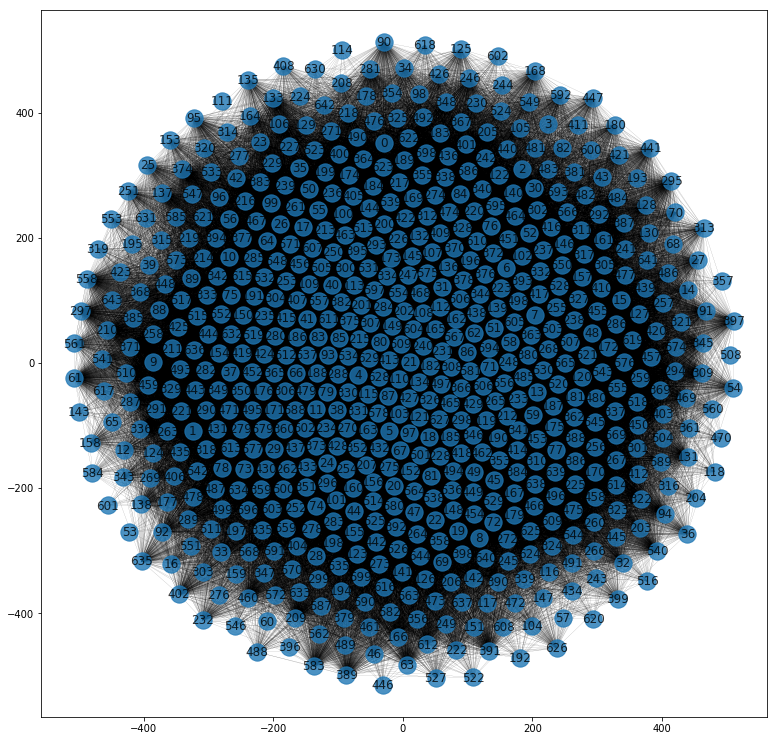

Num nodes: 645, num edges: 63473
Laplacian matrix recon. error (low rank): 25.423589
lap_eigmap_svd:
	Training time: 1.284181
	MAP: 0.383488956683 	 preccision curve: [0.0, 0.0, 0.0, 0.0, 0.2]



----------------------------------------------------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:844: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:845: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:711: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(textobj.convert_xunits(textobj._x))
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:712: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


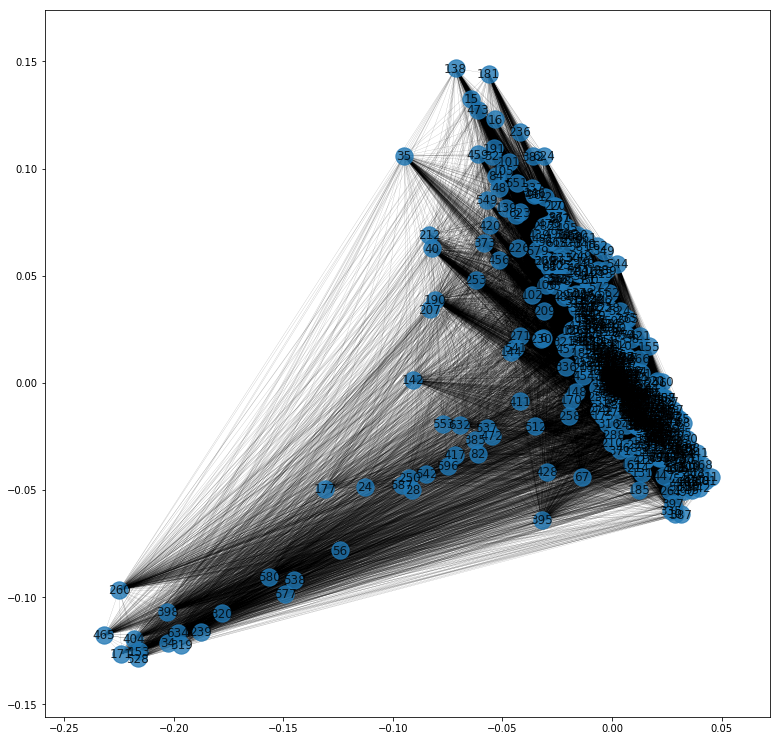

Num nodes: 645, num edges: 63473
[Errno 2] No such file or directory


Exception: ./node2vec not found. Please compile snap, place node2vec in the system path and grant executable permission

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
from time import time

from gemlb.gem.utils      import graph_util, plot_util
from gemlb.gem.evaluation import visualize_embedding as viz
from gemlb.gem.evaluation import evaluate_graph_reconstruction as gr

from gemlb.gem.embedding.gf       import GraphFactorization
from gemlb.gem.embedding.hope     import HOPE
from gemlb.gem.embedding.lap      import LaplacianEigenmaps
from gemlb.gem.embedding.lle      import LocallyLinearEmbedding
from gemlb.gem.embedding.node2vec import node2vec
#from gemlb.gem.embedding.sdne     import SDNE

run_n2v= True

# Specify whether the edges are directed
isDirected = False

# Load graph
G = dd_G

models = []
# Load the models you want to run
models.append(HOPE(d=20, beta=0.01))
models.append(LaplacianEigenmaps(d=2))
#models.append(LocallyLinearEmbedding(d=2))
if run_n2v:
    models.append(
        node2vec(d=2, max_iter=1, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1)
    )
# models.append(SDNE(d=2, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3,n_units=[50, 15,], rho=0.3, n_iter=50, xeta=0.01,n_batch=100,
#                 modelfile=['enc_model.json', 'dec_model.json'],
#                 weightfile=['enc_weights.hdf5', 'dec_weights.hdf5']))
models.append(LocallyLinearEmbedding(d=2))


#too slow
models.append(GraphFactorization(d=2, max_iter=500, eta=1 * 10**-4, regu=1.0))

# A,R = predict_rescal_als([dd_A.toarray()])
# plt.figure(figsize=(13,13))
# viz.plot_embedding2D(A, di_graph=G, node_colors=None)
# plt.show()
# plt.clf()
# For each model, learn the embedding and evaluate on graph reconstruction and visualization
embeddings_all = []
for embedding in models:
    print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
    t1 = time()
    # Learn embedding - accepts a networkx graph or file with edge list
    Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
    print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
    # Evaluate on graph reconstruction
    MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, None)
    #---------------------------------------------------------------------------------
    print(("\tMAP: {} \t preccision curve: {}\n\n\n\n"+'-'*100).format(MAP,prec_curv[:5]))
    #---------------------------------------------------------------------------------
    embeddings_all.append(embedding.get_embedding())
    #print(embedding.get_embedding())
    # Visualize
    plt.figure(figsize=(13,13))
    viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
    plt.show()
    plt.clf()



# Evaluation Tasks

## Link Prediction

## Node Classification

In [4]:
import link_prediction_scores as lp

In [5]:
import numpy as np
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)


def make_symmetric(A):
    return np.maximum( A, A.transpose() )

#print check_symmetric(adj.todense())
#w = make_symmetric(adj.todense())
#print check_symmetric(w)

In [2]:
import time 
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import scipy
import seaborn as sns

def time_log(str_, t0):
    t1 = time.time()
    print("%s | Took: %0.2f" % (str_, t1-t0))
    return t1

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sp
import seaborn as sns



from numpy import dot, array, zeros, setdiff1d
from numpy.random import shuffle
from scipy.sparse import lil_matrix, csr_matrix
from sktensor import dtensor, cp_als, tucker, rescal, ktensor
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
from tensorly import tucker_to_tensor, kruskal_to_tensor, tensor

def load_csvfile(filename):
    return pd.read_csv(filename)

def convert_data_to_adjMatrix(data):
    # TODO:: refactor how to get columns
    columns = (data.iloc[:, i] for i in range(2))
    df = pd.crosstab(*columns)
    #df = pd.crosstab(data.a, data.b)
    idx = df.columns.union(df.index)
    adj_matrix = df.reindex(index=idx, columns=idx, fill_value=0)
    return idx, adj_matrix.values

def convert_dataframe_to_sparse(matrix):
    return sp.csr_matrix(matrix)

data_directory = "../../GRAPH_CONV/data/"
filenames = [#"bio-decagon-ppi.csv",
             #    "bio-decagon-targets.csv",
             #    "bio-decagon-targets-all.csv",
                 "bio-decagon-combo.csv",]
             #    "merged_data.csv"]
datasets = {}

def convert_data_to_multiarray(data):
    """
    Convert data to a multiway array by stacking matrix slices
    (also sparse version)
    """
    adj_matrices = []
    adj_sp_matrices = []
    unique_seffects = data.iloc[:, 2].unique()
    # build a huge zeros matrix for all nodes
    columns = (data.iloc[:, i] for i in range(2))
    df = pd.crosstab(*columns)
    #df = pd.crosstab(data.a, data.b)
    idx = df.columns.union(df.index)
    adj_matrix_all = df.reindex(index=idx, columns=idx, fill_value=0)

    # for each disease get all interaction rows
    # and construct a DxDx#unique_seffects
    #print len(unique_seffects.tolist())

    for se in unique_seffects.tolist():
        adj_matrix_all[adj_matrix_all>0] = 0
        subdata = data.loc[data.iloc[:, 2] == se]
        #columns = (subdata.iloc[:, i] for i in range(3))
        for c in subdata.values:
            row = c[0]
            column = c[1]
            adj_matrix_all.at[row, column] = 1
        adj_matrices.append(adj_matrix_all.values)
        sparse_matrix = convert_dataframe_to_sparse(adj_matrix_all)
        adj_sp_matrices.append(sparse_matrix)
    #multiarray = np.dstack(adj_matrices)

    return adj_sp_matrices

# for f in filenames:
#     datafile = load_csvfile(data_directory+f)
#     names_of_rows, adj_matrix = convert_data_to_adjMatrix(datafile)
#     sparse_matrix = convert_dataframe_to_sparse(adj_matrix)
#     datasets[f] = sparse_matrix          
with open("../../GRAPH_CONV/data/names_of_drugs.txt", 'r') as f:
    names_of_drugs = [f.strip('\n') for f in f.readlines()]
#names_of_drugs
datafile = load_csvfile(data_directory+"bio-decagon-combo.csv")
multiarray = convert_data_to_multiarray(datafile)

Using mxnet backend.


1317


In [3]:
import cPickle as pickle
#with open("./multiarray_list.pkl", 'w+') as f:
#    pickle.dump(multiarray,f)
    
with open("./multiarray_list.pkl", 'r') as f:
    multiarray = pickle.load(f)

In [4]:
print len(multiarray)

1317


In [12]:
for r in xrange(len(multiarray)):
    print (mu2[r]!= multiarray[r]).nnz==0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [8]:
def to_tensor(multiarray_sparse, sample=None):
    marrays = []
    if sample:
        sorted_m = sorted(multiarray_sparse, key=csr_matrix.getnnz)
        for m in sorted_m[-sample:]:
            marrays.append(m.toarray())
        T = np.array(marrays).T
    else:
        for m in multiarray_sparse:
            marrays.append(m.toarray())
        T = np.array(marrays).T
    return T
#del data
tensor = to_tensor(multiarray, sample=4)
e, k = tensor.shape[0], tensor.shape[2]
print("Dataset size: ", tensor.shape)
SZ = e * e * k
# T for rescal
T = [lil_matrix(tensor[:, :, i]) for i in range(k)]

('Dataset size: ', (645, 645, 4))


In [295]:
all_ = np.array(all_edges, copy=True)
all_new = []
wanted = len(all_) - len(all_new)
w = np.hstack((np.random.randint(0, u, size=(wanted,1)), 
              np.random.randint(0, v, size=(wanted,1)),
              np.random.randint(0, R, size=(wanted,1))))
d = all_ - w
d = np.abs(d)
d[d>0] = 1
idx = np.where(~d.any(axis=1))[0]
print idx
if idx.shape[0] > 0:
    print 'found doubles'
    print d[idx]
else:
    neg_edges = set([tuple(item) for item in w.tolist()])
print len(w)
print len(neg_edges)
print neg_edges.isdisjoint(set(all_edges))
#~d.any(1)

[]
4649441
4629583
False


In [302]:
set([tuple(item) for item in w.tolist()[:10]])

{(34, 643, 230),
 (217, 467, 122),
 (236, 517, 19),
 (248, 620, 928),
 (295, 169, 709),
 (311, 274, 1181),
 (328, 60, 1280),
 (417, 44, 444),
 (421, 15, 391),
 (439, 111, 93)}

In [294]:
d[d>0] = 1
np.where(~d.any(axis=1))[0]

array([], dtype=int64)

In [285]:
print neg_edges.isdisjoint(set(all_edges))

False


In [278]:
print d
#print np.argwhere(d.sum(axis=1) == 0)
d1 = np.abs(d)
print d
print d[d.sum(axis=1) == 0]
#print np.argwhere(d.sum(axis=1) == 0)

[[ 629  331  781]
 [ 138  101  440]
 [ 178  319 1286]
 ...
 [ 312  134 1049]
 [  38  125  459]
 [  56  219   84]]
[[ 629  331  781]
 [ 138  101  440]
 [ 178  319 1286]
 ...
 [ 312  134 1049]
 [  38  125  459]
 [  56  219   84]]
[]


In [245]:
all_ = np.array(all_edges, copy=True)
all_new = []
t0 = time.time()
not_done = True
while not_done:
    wanted = len(all_) - len(all_new)
    w = np.hstack((np.random.randint(0, u, size=(wanted,1)), 
              np.random.randint(0, v, size=(wanted,1)),
              np.random.randint(0, R, size=(wanted,1))))
    cor, rem = intersect_along_first_axis(all_, w)
    all_ = np.vstack((all_, cor))
    try:
        all_new = np.vstack((all_new, cor))
    except ValueError:
        all_new = np.copy(cor)
    t0 = time_log("Remaining: %d" % len(rem),  t0)
    if len(rem) == 0:
        not_done = False

Remaining: 39236 | Took: 10.71
Remaining: 77852 | Took: 18.52


KeyboardInterrupt: 

In [226]:
import itertools
import copy
import scipy
import tqdm

def intersect_along_first_axis(a, b):
    # check that casting to void will create equal size elements
    assert a.shape[1:] == b.shape[1:]
    assert a.dtype == b.dtype

    # compute dtypes
    void_dt = np.dtype((np.void, a.dtype.itemsize * np.prod(a.shape[1:])))
    orig_dt = np.dtype((a.dtype, a.shape[1:]))

    # convert to 1d void arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    a_void = a.reshape(a.shape[0], -1).view(void_dt)
    b_void = b.reshape(b.shape[0], -1).view(void_dt)

    # intersect, then convert back
    #print  "New unique %d" %np.setdiff1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "Original uniqye %d" % np.setdiff1d(a_void, b_void).view(orig_dt).shape[0]
    #print  "Intersect %d" % np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "XOR %d" % np.setxor1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'SUM'
    #print np.setdiff1d(b_void, a_void).view(orig_dt).shape[0] + np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'ORIG'
    #print a.shape[0]
    return np.setdiff1d(b_void, a_void).view(orig_dt), np.intersect1d(b_void, a_void).view(orig_dt)


def perturb_array(all_, u, v, R):
    all_new = np.copy(all_)
    all_new += 1
    all_new[:,0] = all_new[:,0].clip(0, u-1)
    all_new[:,1] = all_new[:,1].clip(0, v-1) 
    all_new[:,2] = all_new[:,2].clip(0, R-1)
    return all_new

def create_matrix_false_edges(all_edges, u, v, R):
    not_done = True
    all_ = np.array(all_edges, copy=True)
    rem = np.copy(all_)
    all_new = None
    t0 = time.time()
    while not_done:
        rem_new = perturb_array(rem, u, v, R)
        cor, rem = intersect_along_first_axis(all_, rem_new)
        #print cor.shape, rem.shape, rem_new.shape
        #print len(cor) + len(rem), len(rem_new)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # THIS SHOULD BE UNCOMMENTED FOR SANITY #
        #assert(len(cor) + len(rem) == len(rem_new))
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #print all_.shape
        all_ = np.vstack((all_, cor))
        #print all_.shape
        try:
            all_new = np.vstack((all_new, cor))
        except ValueError:
            all_new = np.copy(cor)
        t0 = time_log("Remaining: %d" % len(rem),  t0)
        if len(rem) == 0:
            not_done = False
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # THIS SHOULD BE UNCOMMENTED FOR SANITY #
    try:
        assert(len(all_new) == len(all_))
    except AssertionError:
        print("FOUND MISSING FALSE EDGES. ADDING %d RANDOM ONES" % (len(all_) - len(all_new)))
        set_all = set(all_edges).union(set([tuple(item) for item in all_new.tolist()]))
        while(len(all_new) < len(all_)):
            selected = (np.random.randint(u), np.random.randint(v), np.random.randint(R))
            if not(selected in set_all):
                all_new = np.vstack((all_new, np.array(selected)))
    assert(len(all_new) == len(all_))
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # THIS SHOULD BE UNCOMMENTED FOR SANITY #
    print "CREATED %d Negative edges" % (len(all_new))
    print "CREATED %d UNIQUE edges" % (len(set([tuple(item) for item in all_new.tolist()])))
    return all_new
    #return set([tuple(item) for item in all_new.tolist()])
    #idxes = np.random.permutation(np.arange(all_new.shape[0]))
    #train_edges_false = set([tuple(item) for item in all_new[idxes[:len(train_edges)],:].tolist()])
    #test_edges_false = set([tuple(item) for item in all_new[idxes[len(train_edges):len(train_edges)+len(test_edges)],:].tolist()])
    #val_edges_false = set([tuple(item) for item in all_new[idxes[len(train_edges)+ len(test_edges):len(train_edges)+len(test_edges)+len(val_edges)],:].tolist()])
    #return train_edges_false, test_edges_false, val_edges_false

def clip_edge(edge, u_max, v_max, r_max):
   # print edge
   # print edge
    edge[0] = min(u_max-1, edge[0])
    edge[1] = min(v_max-1, edge[1])
    edge[2] = min(r_max-1, edge[2])
    return edge

def perturb_edge(edge, all_edges,  u, v, R, step=1):
    edge2 = np.array(edge)
    edge2[np.random.randint(3)] += step
    edge2 = clip_edge(edge2, u, v, R)
    while tuple(edge2) in all_edges:
        edge2[np.random.randint(3)] += 1
        edge2 = clip_edge(edge2, u, v, R)
    return tuple(edge2)

def get_nnz(adj):
    mask = adj>0
    return mask.sum()

def get_sparsity_csr(A):
    return A.getnnz()/float(A.shape[0]*A.shape[1])

def report_sparsity_tensorlist(multiarray):
    sparsities = [100*get_sparsity_csr(r) for r in multiarray]
    print("Sparsity (x100) [Mean | 2*STD | MIN | MAX] : %0.3f | %0.3f | %0.3f | %0.3f" %  
          (np.mean(sparsities), 2*np.std(sparsities), np.min(sparsities), np.max(sparsities)))
#report_sparsity_tensor(multiarray)

def check_tensorlist_shape(tensorlist):
    assert type(tensorlist)==list
    shapes = []
    R = len(tensorlist)
    all_edges = []
    for r_i in xrange(R):
        shapes.append(tensorlist[r_i].shape)
        cur_edges_idx = []
        for edge in np.argwhere(tensorlist[r_i]>0).tolist():
            cur_edges_idx.append((edge[0], edge[1], r_i))
        all_edges.extend(cur_edges_idx)
    for shapes in itertools.combinations(shapes, 2):
        assert shapes[0] == shapes[1]
    return shapes[0][0], shapes[0][1], R, all_edges

def mask_test_edges(tensorlist, test_frac=0.1, val_frac=.05, 
                    remove_self=False, create_false=True):
    """
    tensor: List of adj matrices
    """
    t0 = time.time()
    tstart = t0
    u, v, R,  all_edges = check_tensorlist_shape(tensorlist)
    # Sanity check
    assert len(set(all_edges)) == len(all_edges)
    if type(test_frac) == int:
        num_test = test_frac
    else:
        num_test = int(np.floor(len(all_edges) * test_frac)) # controls how large the test set should be
    if type(val_frac) == int:
        num_val = val_frac
    else:
        num_val = int(np.floor(len(all_edges) * val_frac))
    t0 = time_log("Tensorlist checks done", t0)
    print("Tensor Size: %d X %d Χ %d" %(u,v,R))
    print("Total edges: %d" % len(all_edges))
    report_sparsity_tensorlist(tensorlist)
    #return all_edges
#     print("Training edges (positive):", len(train_edges))
#     print("Training edges (negative):", len(train_edges_false))
#     print("Validation edges (positive):", len(val_edges))
#     print("Validation edges (negative):", len(val_edges_false))
#     print("Test edges (positive):", len(test_edges))
#     print("Test edges (negative):", len(test_edges_false))
#     print "------------------------------------------------------"
    if remove_self:
        for r_i in xrange(R):
            adj = tensorlist[r_i]
            if scipy.sparse.issparse(adj):
                # Remove diagonal elements
                adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
                adj.eliminate_zeros()
                assert np.diag(adj.todense()).sum() == 0
            else:
                np.fill_diagonal(adj, 0)
                assert np.diag(adj).sum() == 0
            # Check that diag is zero
            
            tensorlist[r_i] = adj
        t0 = time_log("Removed diagonal elements!", t0)
    wanted_test_edges_idx = np.random.choice(len(all_edges), num_test, replace=False)
    test_edges = set([all_edges[idx] for idx in wanted_test_edges_idx])
    train_edges = set(all_edges)- test_edges
    train_edges_list = list(train_edges)
    wanted_val_edges_idx = np.random.choice(len(train_edges_list), num_val, replace=False)
    val_edges = set([train_edges_list[idx] for idx in wanted_val_edges_idx])
    train_edges = train_edges - val_edges
    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)
    t0 = time_log("Created train/val/test positive edges!", t0)
    masked_tensorlist = copy.deepcopy(tensorlist)
    for u_i, v_i, r_i in test_edges.union(val_edges):
        masked_tensorlist[r_i][u_i, v_i] = 0
    t0 = time_log("Updated tensor by masking val/test pos edges!", t0)

    if create_false:
        print("Will create %d false edges in total!" % len(all_edges))
        # Create non-existing zero edges indexes
        all_edges_false = set()
        train_edges_false = set()
        test_edges_false = set()
        val_edges_false = set()
        # MATRIX PERTURBATIONS # (ONLY WORKS FOR LESS THAN A MILLION TOTAL EDGES)
        false_matrix = create_matrix_false_edges(all_edges, u, v, R)
        idxes = np.random.permutation(np.arange(false_matrix.shape[0]))
        train_edges_false = set([tuple(item) for item in false_matrix[idxes[:len(train_edges)],:].tolist()])
        print len(idxes[:len(train_edges)])
        test_edges_false = set([tuple(item) for item in false_matrix[idxes[len(train_edges):len(train_edges)+len(test_edges)],:].tolist()])
        print len(idxes[len(train_edges):len(train_edges)+len(test_edges)])
        val_edges_false = set([tuple(item) for item in false_matrix[idxes[len(train_edges)+ len(test_edges):len(train_edges)+len(test_edges)+len(val_edges)],:].tolist()])
        idxes[len(train_edges)+len(test_edges):len(train_edges)+len(test_edges)+len(val_edges)]
        
        
        # PERTURBATIONS #
        #print("Creating %d false train edges!" % len(train_edges))
        #for edge in tqdm.tqdm_notebook(train_edges):
        #    train_edges_false.add(perturb_edge(edge, all_edges, u, v, R))
#         print("Creating %d false test edges!" % len(test_edges))
#         all_ = all_edges + list(train_edges_false)
#         for edge in tqdm.tqdm_notebook(test_edges):
#             test_edges_false.add(perturb_edge(edge, all_,
#                                               u, v, R))
#         all_ = all_edges + list(test_edges_false)
#         print("Creating %d false val edges!" % len(val_edges))
#         for edge in tqdm.tqdm_notebook(val_edges):
#             val_edges_false.add(perturb_edge(edge, all_,
#                                              u, v, R))
        
        
        # RANDOM ASSIGNMENTS #
#         while len(train_edges_false) < len(train_edges):
#            selected = (np.random.randint(u), np.random.randint(v), np.random.randint(R))
#            if not(selected in all_edges) and not(selected in all_edges_false):
#                train_edges_false.add(selected)
#                all_edges_false.add(selected)
#         while len(test_edges_false) < len(test_edges):
#             selected = (np.random.randint(u), np.random.randint(v), np.random.randint(R))
#             if not(selected in all_edges) and not(selected in all_edges_false):
#                 test_edges_false.add(selected)
#                 all_edges_false.add(selected)
#         while len(val_edges_false) < len(val_edges):
#             selected = (np.random.randint(u), np.random.randint(v), np.random.randint(R))
#             if not(selected in all_edges) and not(selected in all_edges_false):
#                 val_edges_false.add(selected)
#                 all_edges_false.add(selected)
        # SOME ERRORS WITH THE 
#         for r_i in xrange(R):
#             nonzero = tensorlist[r_i]>0
#             try:
#                 nonzero = ~nonzero.todense()
#             # case of non-sparse
#             except AttributeError:
#                 nonzero = ~nonzero
#             cur_zeros_idx = np.argwhere(nonzero)
#             #print cur_zeros_idx
#             neg_edges |= set([(cur[0], cur[1], r_i) for cur in cur_zeros_idx])
#         #print neg_edges
#         # Create false train edges
#         train_edges_false = list(neg_edges)
#         train_false_idx = np.random.choice(len(train_edges_false), len(train_edges))
#         train_edges_false = set([train_edges_false[idx] for idx in train_false_idx])
#         # Create false val edges
#         val_edges_false = neg_edges - train_edges_false
#         val_edges_false = list(val_edges_false)
#         val_false_idx = np.random.choice(len(val_edges_false), len(val_edges))
#         val_edges_false = set([val_edges_false[idx] for idx in val_false_idx])
#         # Create false test edges
#         test_edges_false = neg_edges - train_edges_false - val_edges_false
#         test_edges_false = list(test_edges_false)
#         test_false_idx = np.random.choice(len(test_edges_false), len(test_edges))
#         test_edges_false = set([test_edges_false[idx] for idx in test_false_idx])
        # assert: test, val, train negative edges disjoint
        assert val_edges_false.isdisjoint(train_edges_false)
        assert test_edges_false.isdisjoint(train_edges_false)
        assert val_edges_false.isdisjoint(test_edges_false)
        assert set(all_edges).isdisjoint(train_edges_false.union(test_edges_false).union(val_edges_false))
        t0 = time_log("Created negative edges!", t0)
        #for u_i, v_i, r_i in train_edges_false.union(test_edges_false.union(val_edges_false)):
        #    masked_tensorlist[r_i][u_i, v_i] = 1
        #t0 = time_log("Updated tensor by adding val/test neg edges!", t0)
        print "------------------------------------------------------"
        print("Training edges (positive):", len(train_edges))
        print("Training edges (negative):", len(train_edges_false))
        print("Validation edges (positive):", len(val_edges))
        print("Validation edges (negative):", len(val_edges_false))
        print("Test edges (positive):", len(test_edges))
        print("Test edges (negative):", len(test_edges_false))
        t0 = time_log("Total time", tstart)
        print "------------------------------------------------------"
        return masked_tensorlist, train_edges, train_edges_false, \
    val_edges, val_edges_false, test_edges, test_edges_false
    else:
        return masked_tensorlist, train_edges, set(), val_edges, set(), test_edges, set()

import time
k = np.random.randn(4,4)
k = scipy.sparse.csr_matrix(k)
masked_tensorlist, train_edges, train_edges_false, \
    val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(multiarray[:100], 
                                                                               test_frac=10000, 
                                                                               val_frac=1, 
                                                                               remove_self=False,
                                                                               create_false=True)

Tensorlist checks done | Took: 8.42
Tensor Size: 645 X 645 Χ 100
Total edges: 918233
Sparsity (x100) [Mean | 2*STD | MIN | MAX] : 2.207 | 3.070 | 0.021 | 6.867
Created train/val/test positive edges! | Took: 0.50
Updated tensor by masking val/test pos edges! | Took: 0.61
Will create 918233 false edges in total!
Remaining: 59364 | Took: 1.83
Remaining: 59359 | Took: 1.63
Remaining: 7468 | Took: 1.63
Remaining: 7437 | Took: 1.67
Remaining: 1221 | Took: 1.67
Remaining: 1216 | Took: 1.66
Remaining: 185 | Took: 1.65
Remaining: 185 | Took: 1.68
Remaining: 22 | Took: 1.67
Remaining: 22 | Took: 1.71
Remaining: 2 | Took: 1.70
Remaining: 2 | Took: 1.65
Remaining: 0 | Took: 1.64
FOUND MISSING FALSE EDGES. ADDING 918233 RANDOM ONES


KeyboardInterrupt: 

In [79]:
#u, v, R, all_edges = check_tensorlist_shape(multiarray)
def clip_edge(edge, u_max, v_max, r_max):
   # print edge
   # print edge
    edge[0] = min(u_max-1, edge[0])
    edge[1] = min(v_max-1, edge[1])
    edge[2] = min(r_max-1, edge[2])
    return edge

def perturb_edge(edge, all_edges,  u, v, R, step=1):
    edge2 = np.array(edge)
    edge2[np.random.randint(3)] += step
    edge2 = clip_edge(edge2, u, v, R)
    while tuple(edge2) in all_edges:
        edge2[np.random.randint(3)] += 1
        edge2 = clip_edge(edge2, u, v, R)
    return tuple(edge2)

def perturb_range(edge, dic_):
    edge2 = np.array(edge)
    idx = np.random.randint(3)
    edge2[idx] = np.random.choice(dic_[idx])
    while tuple(edge2) in all_edges:
        idx = np.random.randint(3)
        edge2[idx] = np.random.choice(dic_[idx])
    return tuple(edge2)

dic_ = {0:u, 1:v, 2:R}
for item in list(all_edges[:10]):
    ii = perturb_range(item, dic_)
    print item, ii
    #perturb_edge(item, all_edges, u, v, R)
    

(1, 35, 0) (437, 35, 0)
(1, 183, 0) (110, 183, 0)
(1, 459, 0) (1, 72, 0)
(8, 10, 0) (396, 10, 0)
(8, 67, 0) (332, 67, 0)
(8, 126, 0) (371, 126, 0)
(8, 127, 0) (8, 530, 0)
(8, 185, 0) (8, 373, 0)
(8, 295, 0) (8, 295, 375)
(8, 297, 0) (8, 453, 0)


In [197]:
void_dt = np.dtype((np.void, rem_new.dtype.itemsize * np.prod(rem_new.shape[1:])))
orig_dt = np.dtype((all_.dtype, all_.shape[1:]))
rem_new = np.ascontiguousarray(rem_new)
r_void = rem_new.reshape(rem_new.shape[0],-1).view(void_dt)
all_void = all_.reshape(rem_new.shape[0],-1).view(void_dt)
print  "Intersect %d" % np.intersect1d(r_void, all_void).view(orig_dt).shape[0]
print  "Intersect %d" % np.setdiff1d(r_void, all_void).view(orig_dt).shape[0]
print np.intersect1d(r_void, all_void).view(orig_dt).shape[0] + np.setdiff1d(r_void, all_void).view(orig_dt).shape[0]

Intersect 62237
Intersect 937762
999999


In [198]:
def intersect_along_first_axis(a, b):
    # check that casting to void will create equal size elements
    assert a.shape[1:] == b.shape[1:]
    assert a.dtype == b.dtype

    # compute dtypes
    void_dt = np.dtype((np.void, a.dtype.itemsize * np.prod(a.shape[1:])))
    orig_dt = np.dtype((a.dtype, a.shape[1:]))

    # convert to 1d void arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    a_void = a.reshape(a.shape[0], -1).view(void_dt)
    b_void = b.reshape(b.shape[0], -1).view(void_dt)

    # intersect, then convert back
    #print  "New unique %d" %np.setdiff1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "Original uniqye %d" % np.setdiff1d(a_void, b_void).view(orig_dt).shape[0]
    #print  "Intersect %d" % np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "XOR %d" % np.setxor1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'SUM'
    #print np.setdiff1d(b_void, a_void).view(orig_dt).shape[0] + np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'ORIG'
    #print a.shape[0]
    return np.setdiff1d(b_void, a_void).view(orig_dt), np.intersect1d(b_void, a_void).view(orig_dt)


all_ = np.array(all_edges[:10000], copy=True)
rem = np.copy(all_)
rem_new = perturb_array(rem, u, v, R)

cor, rem = intersect_along_first_axis(all_, rem_new)
print cor.shape[0] + rem.shape[0], rem_new.shape[0]

10000 10000


In [166]:
for c in rem:
    for r in all_:
        if r[0] == c[0] and r[1] == c[1] and c[2] == r[2]:
            print r, c
            print 'found'
            break
            
    break

[107 460   2] [107 460   2]
found


In [220]:
all_edges[0]

(1, 35, 0)

In [221]:
def intersect_along_first_axis(a, b):
    # check that casting to void will create equal size elements
    assert a.shape[1:] == b.shape[1:]
    assert a.dtype == b.dtype

    # compute dtypes
    void_dt = np.dtype((np.void, a.dtype.itemsize * np.prod(a.shape[1:])))
    orig_dt = np.dtype((a.dtype, a.shape[1:]))

    # convert to 1d void arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    a_void = a.reshape(a.shape[0], -1).view(void_dt)
    b_void = b.reshape(b.shape[0], -1).view(void_dt)

    # intersect, then convert back
    #print  "New unique %d" %np.setdiff1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "Original uniqye %d" % np.setdiff1d(a_void, b_void).view(orig_dt).shape[0]
    #print  "Intersect %d" % np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print  "XOR %d" % np.setxor1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'SUM'
    #print np.setdiff1d(b_void, a_void).view(orig_dt).shape[0] + np.intersect1d(b_void, a_void).view(orig_dt).shape[0]
    #print 'ORIG'
    #print a.shape[0]
    return np.setdiff1d(b_void, a_void).view(orig_dt), np.intersect1d(b_void, a_void).view(orig_dt)


def perturb_array(all_, u, v, R):
    all_new = np.copy(all_)
    all_new += 1
    all_new[:,0] = all_new[:,0].clip(0, u-1)
    all_new[:,1] = all_new[:,1].clip(0, v-1) 
    all_new[:,2] = all_new[:,2].clip(0, R-1)
    return all_new

def create_matrix_false_edges(all_edges, u, v, R):
    not_done = True
    all_ = np.array(all_edges, copy=True)
    rem = np.copy(all_)
    all_new = None
    t0 = time.time()
    while not_done:
        rem_new = perturb_array(rem, u, v, R)
        cor, rem = intersect_along_first_axis(all_, rem_new)
        #print cor.shape, rem.shape, rem_new.shape
        #print len(cor) + len(rem), len(rem_new)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # THIS SHOULD BE UNCOMMENTED FOR SANITY #
        #assert(len(cor) + len(rem) == len(rem_new))
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #print all_.shape
        all_ = np.vstack((all_, cor))
        #print all_.shape
        try:
            all_new = np.vstack((all_new, cor))
        except ValueError:
            all_new = np.copy(cor)
        t0 = time_log("Remaining: %d" % len(rem),  t0)
        if len(rem) == 0:
            not_done = False
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # THIS SHOULD BE UNCOMMENTED FOR SANITY #
    try:
        assert(len(all_new) == len(all_))
    except AssertionError:
        print("FOUND MISSING FALSE EDGES. ADDING %d RANDOM ONES" % (len(all_) - len(all_new)))
        set_all = set(all_edges).union(set([tuple(item) for item in all_new.tolist()]))
        while(len(all_new) < len(all_)):
            selected = (np.random.randint(u), np.random.randint(v), np.random.randint(R))
            if not(selected in set_all):
                all_new = np.vstack((all_new, np.array(selected)))
    assert(len(all_new) == len(all_))
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # THIS SHOULD BE UNCOMMENTED FOR SANITY #
    print "CREATED %d Negative edges" % (len(all_new))
    print "CREATED %d UNIQUE edges" % (len(set([tuple(item) for item in all_new.tolist()])))
    return all_new
    #return set([tuple(item) for item in all_new.tolist()])
    #idxes = np.random.permutation(np.arange(all_new.shape[0]))
    #train_edges_false = set([tuple(item) for item in all_new[idxes[:len(train_edges)],:].tolist()])
    #test_edges_false = set([tuple(item) for item in all_new[idxes[len(train_edges):len(train_edges)+len(test_edges)],:].tolist()])
    #val_edges_false = set([tuple(item) for item in all_new[idxes[len(train_edges)+ len(test_edges):len(train_edges)+len(test_edges)+len(val_edges)],:].tolist()])
    #return train_edges_false, test_edges_false, val_edges_false

tr, te, val = create_matrix_false_edges(all_edges[:], u, v, R)
assert set(all_edges).isdisjoint(tr.union(te).union(val))
assert tr.isdisjoint(te)
assert tr.isdisjoint(val)
assert te.isdisjoint(val)

Remaining: 203256 | Took: 10.56
Remaining: 11662 | Took: 4.79
Remaining: 799 | Took: 4.67
Remaining: 61 | Took: 4.69
Remaining: 7 | Took: 4.72
Remaining: 1 | Took: 4.75
Remaining: 0 | Took: 4.42
FOUND MISSING FALSE EDGES. ADDING 7 RANDOM ONES


In [ ]:
print len(train_edges), len(train_edges_false)
print len(val_edges), len(val_edges_false)
print len(test_edges), len(test_edges_false)

In [270]:
import sparse
import tqdm
def to_sparse_3d(tensorlist):
    for r_i, sparse_ in tqdm.tqdm(enumerate(tensorlist)):
        rows_i, cols_i, vals_i = scipy.sparse.find(sparse_)
        if r_i == 0:
            rows = rows_i
            cols = cols_i
            rs = np.array([r_i for i in rows_i])
            vals = vals_i
        else:
            rows = np.hstack((rows, rows_i))
            cols = np.hstack((cols, cols_i))
            rs = np.hstack((rs, np.array([r_i for i in rows_i])))
            vals = np.hstack((vals, vals_i))
    r,c = sparse_.shape
    #print r,c,len(tensorlist)
    #print len(rows), len(cols), len(rs), len(vals)
    return sparse.COO([rows,cols,rs], vals, shape=(r,c, len(tensorlist)))
tensor = to_sparse_3d(masked_tensorlist[:])
print tensor.shape

1317it [00:32, 24.93it/s]


(645, 645, 1317)


In [9]:
tensor = to_tensor(masked_tensorlistorlist)
print tensor.shape
print type(tensor)

(645, 645, 1317)
<type 'numpy.ndarray'>


In [61]:
print type(tensor)
tensor.sum()

<class 'sparse.coo.core.COO'>


4639440

In [209]:
import tqdm
eps = 0.0001
def adamic_adar_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        common_neig_id = np.intersect1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                      np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0))
        if len(common_neig_id) > 0:
            inv_sum = 1/np.log(tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1).todense()+eps)
            if np.min(inv_sum) < 0:
                inv_sum += -np.min(inv_sum)
            matrix[comb[0],comb[1]] = np.sum(inv_sum)
        else:
            pass
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0



def preferential_attachment_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        matrix[comb[0],comb[1]] = np.array(tensor[comb[0],:,:].sum(axis=1)>0).sum()* \
        np.array(tensor[comb[1],:,:].sum(axis=1)>0).sum()
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def common_neighbors_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        matrix[comb[0],comb[1]] = len(np.intersect1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                                                 np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0)))
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def common_neighbors_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        matrix[comb[0],comb[1]] = len(np.intersect1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                      np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0)))
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def jaccard_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        inter = len(np.intersect1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                      np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0)))
        union = len(np.union1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                      np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0))) 
        if union > 0:
            matrix[comb[0],comb[1]] = inter/float(union)
        else:
            matrix[comb[0],comb[1]] = 0
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def random_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        matrix[comb[0],comb[1]] = np.random.randint(0,2)
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def resource_allocation_tensor(tensor, test_edges, copy=False):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        #print comb[0], comb[1]
        #print len(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0).flatten())
        #print len(np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0).flatten())
        common_neig_id = np.intersect1d(np.argwhere(tensor[comb[0],:,:].sum(axis=1)>0),
                      np.argwhere(tensor[comb[1],:,:].sum(axis=1)>0))
        if len(common_neig_id) > 0:
            #inv_sum = 1/(tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1)+eps)
            #inv_sum = tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1)
            #print common_neig_id
            #print len(common_neig_id)
            #print tensor[common_neig_id,:,:].sum(axis=2)
            #print tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1)
            #print 1.0/tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1)
            #part = tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1)
            #print part.sum()
            inv_sum = 1.0/(tensor[common_neig_id,:,:].sum(axis=2).sum(axis=1).todense()+eps)
            if np.min(inv_sum) < 0:
                inv_sum += -np.min(inv_sum)
            #print inv_sum
            #print np.sum(inv_sum)
            matrix[comb[0],comb[1]] = np.sum(inv_sum)
        else:
            pass
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0


def katz_n(tensor, a_i, b_i, N=3, b=0.005):
    katz = 0
    for i in xrange(1, N+1):
        if i == 1:
            katz += tensor[a_i,b_i, :].nnz*b**i
            prev_nei = a_i
        elif i == 2:
            _, neigh_hop_i, _ = scipy.sparse.find(tensor[prev_nei,:,:].sum(axis=1))
            katz += tensor[neigh_hop_i,b_i, :].nnz*b**i
            prev_nei = neigh_hop_i
        else:
            _, neigh_hop_i, _ = scipy.sparse.find(tensor[prev_nei,:,:].sum(axis=2))
            if len(neigh_hop_i) > 0:
                katz += tensor[neigh_hop_i,b_i, :].nnz*b**i
            else:
                katz += 0
    return katz

def katz_tensor(tensor, test_edges, copy=False, N=3, b=0.005):
    t0 = time.time()
    matrix = np.zeros((tensor.shape[0], tensor.shape[1]))
    if copy:
        tensor = np.copy(tensor)
        # need aces and zeros
        tensor[tensor>0]=1
        tensor[tensor<=0]=0
    for comb in tqdm.tqdm(test_edges):
        matrix[comb[0],comb[1]] = katz_n(tensor, comb[0], comb[1])
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

te = set(list(test_edges)[:1])
tef = set(list(test_edges_false)[:1])
aa_matrix, tim_ = resource_allocation_tensor(tensor, te.union(tef))
aa_roc, aa_ap, rmse = get_roc_score(test_edges, test_edges_false, aa_matrix)
print aa_roc, aa_ap, rmse, tim_







  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  2.00it/s]





100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

0.49999988976851384 0.500525499274238 0.5005756043724396 0.517888784409


In [207]:
_, bb, c = scipy.sparse.find(tensor[0,0,:])
if len(bb) > 0:
    print 'la'
else:
    

In [201]:
def get_neighbors_of_list(tensorlist, source_nodes):
    if type(source_nodes) == int:
        source_nodes = [source_nodes]
    neig = set()
    for s in source_nodes:
        for r in masked_tensorlist:

IndentationError: expected an indented block (<ipython-input-201-dd61f5986417>, line 6)

In [13]:
import tqdm
eps = 0.0001
results = {}
def adamic_adar_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        #itertools.combinations([i for i in xrange(all_edges[0][0].shape[0])], 2)):
        node1_neig = set()
        node2_neig = set()
        for r in masked_tensorlist:
            node1_neig |= set(r[comb[0],:].indices.tolist())
            node2_neig |= set(r[comb[1],:].indices.tolist())
        common = node1_neig.intersection(node2_neig)
        for c in common:
            c_neig = set()
            for r in masked_tensorlist:
                c_neig |= set(r[c,:].indices.tolist())
            #print c_neig
            matrix[comb[0],comb[1]] += 1/float(np.log(len(c_neig)+eps))
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def jaccard_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        #itertools.combinations([i for i in xrange(all_edges[0][0].shape[0])], 2)):
        node1_neig = set()
        node2_neig = set()
        for r in masked_tensorlist:
            node1_neig |= set(r[comb[0],:].indices.tolist())
            node2_neig |= set(r[comb[1],:].indices.tolist())
        inter = len(node1_neig.intersection(node2_neig))
        un = len(node1_neig.union(node2_neig))
        if un > 0:
            matrix[comb[0],comb[1]] = inter/float(un)
        else:
            matrix[comb[0],comb[1]] = 0
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def preferential_attachment_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        #itertools.combinations([i for i in xrange(all_edges[0][0].shape[0])], 2)):
        node1_neig = set()
        node2_neig = set()
        for r in masked_tensorlist:
            node1_neig |= set(r[comb[0],:].indices.tolist())
            node2_neig |= set(r[comb[1],:].indices.tolist())
        matrix[comb[0],comb[1]] = len(node1_neig)*len(node2_neig)
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def common_neighbors_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        #itertools.combinations([i for i in xrange(all_edges[0][0].shape[0])], 2)):
        node1_neig = set()
        node2_neig = set()
        for r in masked_tensorlist:
            node1_neig |= set(r[comb[0],:].indices.tolist())
            node2_neig |= set(r[comb[1],:].indices.tolist())
        common = node1_neig.intersection(node2_neig)
        matrix[comb[0],comb[1]] = len(common)
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def resource_allocation_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        #itertools.combinations([i for i in xrange(all_edges[0][0].shape[0])], 2)):
        node1_neig = set()
        node2_neig = set()
        for r in masked_tensorlist:
            node1_neig |= set(r[comb[0],:].indices.tolist())
            node2_neig |= set(r[comb[1],:].indices.tolist())
        common = node1_neig.intersection(node2_neig)
        for c in common:
            c_neig = set()
            for r in masked_tensorlist:
                c_neig |= set(r[c,:].indices.tolist())
            #print c_neig
            matrix[comb[0],comb[1]] += 1/float(len(c_neig)+eps)
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0

def graph_distance_tensorlist(tensorlist, test_edges, test_edges_false):
    pass
    #return matrix, time.time() - t0
    
def random_tensorlist(tensorlist, test_edges):
    matrix = np.zeros(tensorlist[0].shape)
    t0 = time.time()
    for comb in tqdm.tqdm(test_edges):
        matrix[comb[0],comb[1]] = np.random.randint(0,2)
    matrix = matrix/matrix.max()
    return matrix, time.time() - t0


#aa_matrix, ts = common_neighbors_tensorlist(masked_tensorlist, 
#                                               test_edges, test_edges_false)



In [25]:
aa_matrix, tim_ =  jaccard_tensor(tensor,test_edges.union(test_edges_false), False)

100%|██████████| 19979/19979 [01:10<00:00, 281.90it/s]


In [186]:
N = 3
b = 0.005
katz = 0
a_i = 6
b_i = 18
for i in xrange(1, N+1):
    if i == 1:
        katz += tensor[a_i,b_i, :].nnz*b**i
        prev_nei = a_i
    elif i == 2:
        _, neigh_hop_i, _ = scipy.sparse.find(tensor[prev_nei,:,:].sum(axis=1))
        katz += tensor[neigh_hop_i,b_i, :].nnz*b**i
        prev_nei = neigh_hop_i
    else:
        _, neigh_hop_i, _ = scipy.sparse.find(tensor[prev_nei,:,:].sum(axis=2))
        katz += tensor[neigh_hop_i,b_i, :].nnz*b**i
    
    #print i
    #print katz

1
0.0
2
0.0
3
0.0


In [143]:
# KATZ
# 1 length-paths
a_i = 0
b_i = 6
print tensor[a_i,b_i, :].nnz
# 2 length-paths
N = 2
i = 1
wanted_cols = []
while i< N:
    if i == 1:
        _, wanted_cols, _ = scipy.sparse.find(tensor[a_i,:,:].sum(axis=1))
    print tensor[wanted_cols, b_i, :].sum(axis=1).nnz
    i +=1
# 2 length-paths
N = 3
i = 1
wanted_cols = []
while i<= N:
    if i == 1:
        _, wanted_cols, _ = scipy.sparse.find(tensor[a_i,:,:].sum(axis=1))
    else:
        prev_cols = copy.deepcopy(wanted_cols.tolist())
        for col in prev_cols:
            #print col
            #print scipy.sparse.find(tensor[col,:,:])
            _, cols_ind, _ = scipy.sparse.find(tensor[col,:,:].sum(axis=1))
            wanted_cols = np.hstack((wanted_cols, cols_ind))
        wanted_cols = list(set(wanted_cols.tolist()))
    i +=1
    print i
    print tensor[wanted_cols, b_i:].sum(axis=1).nnz
    

11
0
2
57401
3
282005


In [158]:
k =tensor[0]
_, n1, _ = scipy.sparse.find(k.sum(axis=1))
_, n2, _ = scipy.sparse.find(tensor[n1,b_i,:].sum(axis=1))

In [144]:
scipy.sparse.find(tensor[0, :,:])

(array([  6,   6,   6, ..., 638, 638, 638], dtype=int32),
 array([ 16,  32,  97, ..., 289, 337, 582], dtype=int32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [126]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.metrics import mean_squared_error

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_roc_score(edges_pos, edges_neg, score_matrix, apply_sigmoid=False):

    # Edge case
    if len(edges_pos) == 0 or len(edges_neg) == 0:
        return (None, None, None)

    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        if apply_sigmoid == True:
            preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]]))
        else:
            preds_pos.append(score_matrix[edge[0], edge[1]])
        pos.append(1) # actual value (1 for positive)

    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        if apply_sigmoid == True:
            preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]]))
        else:
            preds_neg.append(score_matrix[edge[0], edge[1]])
        neg.append(0) # actual value (0 for negative)

    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    #print len(preds_all), len(labels_all)
    #print preds_all
    #print labels_all
    roc_score = roc_auc_score(labels_all, preds_all)
    # roc_curve_tuple = roc_curve(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    rmse = mean_squared_error(labels_all, preds_all)
    # return roc_score, roc_curve_tuple, ap_score
    #print roc_score, ap_score
    return roc_score, ap_score, rmse




#res = get_roc_score(test_edges, test_edges_false, aa_matrix)
#print res

In [276]:
test_edges_false

{(-65, -639, 54),
 (-105, -185, 195),
 (-71, -133, 209),
 (-132, -599, 16),
 (-416, -561, 109),
 (-273, -352, 6),
 (-151, -402, 546),
 (-389, -398, 79),
 (-590, -601, 148),
 (-329, -408, 341),
 (-370, -587, 94),
 (-110, -372, 174),
 (-42, -411, 651),
 (-132, -388, 28),
 (-7, -393, 683),
 (-12, -329, 140),
 (-204, -366, 192),
 (-201, -396, 361),
 (-265, -291, 217),
 (-129, -337, 476),
 (-173, -214, 75),
 (-234, -329, 676),
 (-337, -393, 648),
 (-226, -275, 1049),
 (-127, -328, 611),
 (-353, -475, 1049),
 (-28, -375, 248),
 (-47, -445, 12),
 (-335, -573, 238),
 (-562, -576, 31),
 (-47, -403, 83),
 (-41, -132, 213),
 (-143, -475, 90),
 (-62, -214, 381),
 (-91, -323, 540),
 (-261, -469, 745),
 (-135, -263, 98),
 (-143, -398, 208),
 (-150, -445, 911),
 (-122, -210, 83),
 (-12, -613, 233),
 (-247, -337, 286),
 (-295, -613, 399),
 (-132, -628, 656),
 (-167, -346, 102),
 (-200, -230, 113),
 (-89, -264, 245),
 (-248, -541, 232),
 (-151, -639, 423),
 (-38, -422, 374),
 (-109, -187, 711),
 (-167,

In [249]:
edges_pos = te
edges_neg = tef
preds_pos = []
pos = []
score_matrix = aa_matrix
apply_sigmoid = True
for edge in edges_pos:
    if apply_sigmoid == True:
        preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]]))
    else:
        preds_pos.append(score_matrix[edge[0], edge[1]])
    pos.append(1) # actual value (1 for positive)

# Store negative edge predictions, actual values
preds_neg = []
neg = []
for edge in edges_neg:
    if apply_sigmoid == True:
        preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]]))
    else:
        preds_neg.append(score_matrix[edge[0], edge[1]])
    neg.append(0) # actual value (0 for negative)

# Calculate scores
preds_all = np.hstack([preds_pos, preds_neg])
labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
#print len(preds_all), len(labels_all)
#print preds_all
#print labels_all
roc_score0 = roc_auc_score(labels_all, preds_all, average=None)
# roc_curve_tuple = roc_curve(labels_all, preds_all)
ap_score = average_precision_score(labels_all, preds_all)
rmse = mean_squared_error(labels_all, preds_all)
# return roc_score, roc_curve_tuple, ap_score
print roc_score0, ap_score, rmse


 0.99655 0.996553626307623 0.22432108462277417


In [254]:
collapsed = tensor.sum(axis=2).todense()
collapsed[collapsed>0] = 1

In [261]:
print collapsed.shape
print G.nodes.keys()

(645, 645)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [272]:
import networkx as nx
te = set(list(test_edges)[:])
tef = set(list(test_edges_false)[:])
G = nx.from_numpy_array(collapsed)
wanted = list(set([(comb[0], comb[1]) for comb in te.union(tef)]))
preds = nx.adamic_adar_index(G, wanted)
aa_matrix = np.zeros_like(collapsed)
for u, v, p in preds:
   aa_matrix[u,v] = p
   '(%d, %d) -> %.8f' % (u, v, p)

NetworkXError: u is not in the graph.

In [273]:
for comb in te.union(tef):
    print comb

(250, 374, 550)
(70, 583, 235)
(35, 495, 19)
(-65, -639, 54)
(168, 273, 28)
(-105, -185, 195)
(125, 327, 6)
(328, 532, 364)
(-71, -133, 209)
(-132, -599, 16)
(108, 210, 102)
(-273, -352, 6)
(375, 407, 112)
(346, 562, 198)
(-590, -601, 148)
(395, 634, 696)
(94, 461, 175)
(-370, -587, 94)
(-110, -372, 174)
(253, 369, 107)
(327, 539, 396)
(-279, -402, 154)
(142, 638, 414)
(52, 401, 232)
(-132, -388, 28)
(-468, -613, 296)
(-7, -393, 683)
(190, 449, 482)
(-147, -295, 231)
(-12, -329, 140)
(-204, -366, 192)
(76, 392, 703)
(-199, -532, 130)
(278, 544, 307)
(-201, -396, 361)
(126, 269, 310)
(-265, -291, 217)
(-288, -389, 551)
(-53, -550, 16)
(174, 467, 213)
(289, 374, 477)
(-337, -628, 843)
(-606, -628, 215)
(-234, -329, 676)
(-337, -393, 648)
(-226, -275, 1049)
(444, 568, 365)
(273, 289, 277)
(-127, -328, 611)
(-151, -271, 712)
(-416, -561, 109)
(61, 107, 437)
(190, 465, 303)
(-28, -375, 248)
(-47, -445, 12)
(-264, -337, 240)
(172, 205, 71)
(348, 444, 449)
(-487, -639, 419)
(-335, -573, 238)


(131, 542, 96)
(-389, -431, 443)
(-359, -375, 122)
(-114, -541, 234)
(-156, -577, 203)
(-26, -335, 350)
(52, 397, 195)
(155, 568, 114)
(-38, -71, 7)
(273, 325, 77)
(182, 401, 381)
(-425, -627, 179)
(-330, -459, 4)
(142, 614, 107)
(-218, -572, 258)
(-375, -418, 122)
(-389, -503, 178)
(-328, -638, 571)
(37, 312, 572)
(-234, -479, 1160)
(-298, -337, 255)
(297, 444, 288)
(-256, -276, 127)
(-167, -232, 137)
(34, 185, 16)
(133, 173, 681)
(184, 309, 96)
(-38, -574, 712)
(-131, -157, 193)
(-110, -167, 197)
(256, 467, 164)
(188, 336, 942)
(-175, -211, 244)
(105, 420, 44)
(-38, -223, 503)
(-227, -450, 43)
(424, 433, 205)
(-132, -443, 243)
(88, 263, 532)
(225, 290, 1003)
(17, 424, 284)
(-241, -336, 465)
(67, 146, 17)
(-162, -461, 234)
(-276, -628, 279)
(161, 231, 68)
(-236, -335, 370)
(-208, -254, 338)
(445, 558, 130)
(153, 298, 785)
(230, 270, 35)
(-46, -379, 109)
(42, 407, 286)
(-96, -576, 338)
(146, 563, 32)
(-251, -393, 816)
(-11, -191, 530)
(106, 157, 184)
(-267, -623, 284)
(-81, -165, 330)


(262, 380, 363)
(77, 495, 74)
(-21, -91, 71)
(-236, -383, 375)
(37, 183, 85)
(-132, -372, 286)
(-43, -187, 569)
(40, 187, 12)
(94, 432, 469)
(85, 312, 533)
(-381, -572, 548)
(232, 512, 31)
(-11, -491, 548)
(369, 393, 197)
(-8, -36, 74)
(247, 389, 29)
(374, 400, 72)
(-399, -445, 468)
(444, 467, 33)
(107, 627, 13)
(95, 167, 355)
(473, 474, 29)
(-11, -513, 235)
(-107, -205, 202)
(14, 97, 558)
(-287, -461, 495)
(-128, -402, 640)
(-35, -191, 235)
(10, 322, 238)
(-77, -274, 218)
(-42, -527, 241)
(-610, -628, 223)
(88, 183, 431)
(-305, -379, 463)
(-442, -569, 827)
(-403, -536, 346)
(-147, -582, 638)
(-82, -234, 501)
(-26, -219, 86)
(296, 367, 449)
(248, 467, 31)
(233, 467, 342)
(-347, -572, 133)
(-230, -511, 296)
(-338, -350, 330)
(230, 295, 51)
(-129, -572, 342)
(116, 544, 350)
(295, 335, 26)
(-102, -139, 2)
(-311, -423, 378)
(400, 571, 342)
(187, 449, 196)
(149, 172, 624)
(80, 133, 500)
(-186, -536, 78)
(217, 281, 66)
(-211, -541, 370)
(-291, -309, 244)
(-411, -414, 154)
(-89, -187, 530)
(3

(61, 629, 213)
(305, 540, 1052)
(449, 512, 601)
(16, 391, 212)
(-26, -375, 109)
(-62, -105, 376)
(-155, -396, 474)
(10, 289, 497)
(-234, -305, 817)
(-338, -349, 396)
(-93, -288, 595)
(-288, -429, 64)
(-25, -62, 2)
(150, 558, 395)
(274, 565, 181)
(-43, -366, 74)
(-337, -461, 568)
(-273, -299, 11)
(187, 635, 564)
(-62, -343, 217)
(210, 346, 301)
(-43, -65, 178)
(23, 520, 280)
(-306, -403, 4)
(210, 462, 142)
(199, 421, 143)
(64, 166, 450)
(390, 401, 1015)
(-219, -275, 339)
(-132, -414, 573)
(-89, -264, 245)
(33, 373, 130)
(-63, -328, 339)
(495, 558, 347)
(-375, -376, 332)
(-442, -443, 424)
(-132, -343, 28)
(-9, -559, 46)
(-12, -133, 236)
(80, 541, 68)
(467, 598, 1153)
(369, 388, 801)
(-147, -460, 79)
(62, 458, 4)
(450, 457, 7)
(-209, -541, 130)
(-254, -347, 5)
(-42, -492, 256)
(37, 334, 748)
(133, 389, 58)
(218, 624, 343)
(-182, -599, 113)
(51, 510, 68)
(422, 511, 181)
(-51, -93, 250)
(-559, -611, 214)
(-38, -301, 303)
(-271, -476, 236)
(199, 484, 337)
(41, 388, 282)
(305, 335, 68)
(334, 

(264, 401, 422)
(371, 424, 405)
(-133, -402, 748)
(-359, -391, 137)
(150, 442, 104)
(246, 342, 127)
(-109, -414, 686)
(-173, -236, 87)
(-147, -404, 114)
(174, 233, 130)
(0, 336, 215)
(-167, -408, 284)
(-23, -234, 416)
(187, 294, 213)
(-18, -254, 182)
(-474, -606, 119)
(161, 378, 319)
(106, 456, 366)
(-95, -349, 78)
(-186, -398, 774)
(402, 460, 30)
(-352, -488, 603)
(-206, -291, 197)
(373, 418, 350)
(-442, -559, 443)
(-425, -475, 1039)
(-114, -459, 745)
(369, 374, 218)
(-102, -306, 419)
(187, 444, 879)
(137, 407, 106)
(137, 438, 676)
(-43, -151, 442)
(-31, -96, 143)
(155, 638, 330)
(187, 336, 234)
(-135, -254, 495)
(-150, -167, 342)
(-110, -256, 218)
(295, 474, 347)
(161, 477, 56)
(17, 212, 364)
(-23, -485, 62)
(146, 352, 296)
(15, 605, 283)
(-18, -379, 7)
(149, 346, 486)
(32, 172, 690)
(-11, -12, 566)
(510, 571, 631)
(-381, -436, 106)
(-135, -470, 208)
(137, 293, 337)
(-71, -296, 417)
(271, 322, 79)
(64, 407, 478)
(346, 510, 416)
(-114, -425, 378)
(86, 336, 316)
(-390, -442, 1123)
(246

(-402, -577, 264)
(-252, -270, 74)
(-164, -540, 69)
(-102, -233, 1001)
(-53, -460, 811)
(-156, -167, 513)
(218, 297, 703)
(-109, -396, 430)
(474, 622, 393)
(383, 543, 22)
(-95, -615, 178)
(38, 183, 4)
(-55, -608, 343)
(257, 424, 272)
(-310, -569, 4)
(-11, -53, 421)
(-336, -557, 367)
(30, 540, 401)
(172, 612, 267)
(-322, -559, 272)
(345, 441, 641)
(-408, -451, 524)
(-283, -328, 452)
(-576, -595, 329)
(-127, -219, 1007)
(7, 61, 479)
(-247, -338, 30)
(209, 558, 307)
(-185, -414, 448)
(-464, -576, 243)
(467, 553, 68)
(-209, -450, 64)
(-290, -411, 12)
(-93, -310, 197)
(52, 445, 85)
(139, 374, 923)
(97, 415, 385)
(222, 228, 28)
(-11, -402, 223)
(289, 474, 286)
(184, 368, 394)
(149, 161, 441)
(-282, -532, 111)
(308, 327, 65)
(45, 131, 358)
(-71, -423, 141)
(-127, -215, 522)
(-42, -206, 565)
(374, 576, 912)
(131, 441, 247)
(-82, -379, 337)
(233, 448, 268)
(10, 278, 316)
(103, 309, 29)
(37, 492, 43)
(273, 402, 23)
(237, 459, 421)
(-15, -274, 241)
(441, 614, 621)
(-110, -362, 361)
(-18, -61, 636

In [251]:
roc_auc_score(labels_all, preds_all, average=)

0.99655

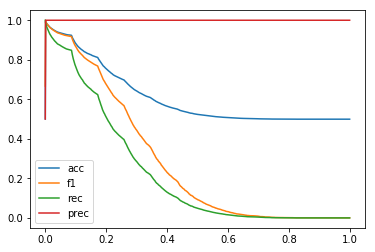

In [238]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
thres = np.linspace(0,1,1000)
acc = []
f1 = []
rec = []
prec = []
for t in tqdm.tqdm_notebook(thres):
    cur = np.array(preds_all)
    cur[cur>=t] = 1
    cur[cur<t] = 0
    acc.append(accuracy_score(labels_all, cur))
    f1.append(f1_score(labels_all, cur))
    rec.append(recall_score(labels_all, cur))
    prec.append(precision_score(labels_all, cur))

import matplotlib.pyplot as plt



plt.plot(thres, acc)
plt.plot(thres, f1)
plt.plot(thres, rec)
plt.plot(thres, prec)
plt.legend(['acc', 'f1', 'rec', 'prec'])
plt.show()

In [245]:
from collections import Counter
Counter(labels_all)

Counter({0.0: 9979, 1.0: 10000})

In [244]:
print np.argmax(f1)
print f1[np.argmax(f1)]
print thres[np.argmax(f1)]
print acc[np.argmax(acc)]

1
0.9931027538639682
0.001001001001001001
0.9931427999399369


In [215]:
aa_matrix, _ =  katz_tensor(s,test_edges.union(test_edges_false), False)
aa_roc, aa_ap, rmse = get_roc_score(test_edges, test_edges_false, aa_matrix)
print aa_roc, aa_ap, rmse







  0%|          | 0/19979 [00:00<?, ?it/s]





  0%|          | 10/19979 [00:00<03:29, 95.39it/s]





  0%|          | 21/19979 [00:00<03:33, 93.55it/s]





  0%|          | 29/19979 [00:00<04:30, 73.63it/s]





  0%|          | 34/19979 [00:00<05:32, 60.00it/s]





  0%|          | 39/19979 [00:00<06:44, 49.29it/s]





  0%|          | 44/19979 [00:00<08:26, 39.35it/s]





  0%|          | 48/19979 [00:00<08:26, 39.34it/s]





  0%|          | 57/19979 [00:01<07:21, 45.09it/s]





  0%|          | 62/19979 [00:01<08:40, 38.25it/s]





  0%|          | 69/19979 [00:01<07:30, 44.19it/s]





  0%|          | 74/19979 [00:01<07:56, 41.82it/s]





  0%|          | 79/19979 [00:01<08:06, 40.86it/s]





  0%|          | 88/19979 [00:01<07:07, 46.54it/s]





  0%|          | 94/19979 [00:01<06:54, 47.93it/s]





  1%|          | 100/19979 [00:01<06:53, 48.03it/s]





  1%|          | 108/19979 [00:02<06:25, 51.52it/s]





  1%|          | 115/19979 [00:02<06:12, 53.39it/

  8%|▊         | 1660/19979 [00:30<05:35, 54.52it/s]





  8%|▊         | 1667/19979 [00:30<05:46, 52.91it/s]





  8%|▊         | 1677/19979 [00:30<04:59, 61.13it/s]





  8%|▊         | 1685/19979 [00:30<05:20, 57.04it/s]





  8%|▊         | 1692/19979 [00:30<05:15, 57.87it/s]





  9%|▊         | 1701/19979 [00:30<04:46, 63.81it/s]





  9%|▊         | 1709/19979 [00:30<04:31, 67.18it/s]





  9%|▊         | 1717/19979 [00:30<05:25, 56.09it/s]





  9%|▊         | 1724/19979 [00:31<05:06, 59.50it/s]





  9%|▊         | 1731/19979 [00:31<05:23, 56.37it/s]





  9%|▊         | 1738/19979 [00:31<05:07, 59.26it/s]





  9%|▊         | 1747/19979 [00:31<04:52, 62.23it/s]





  9%|▉         | 1754/19979 [00:31<05:11, 58.47it/s]





  9%|▉         | 1764/19979 [00:31<05:02, 60.26it/s]





  9%|▉         | 1771/19979 [00:31<05:22, 56.40it/s]





  9%|▉         | 1779/19979 [00:31<05:16, 57.57it/s]





  9%|▉         | 1785/19979 [00:32<06:29, 46.65it/s]





  9%|▉        

 16%|█▋        | 3284/19979 [00:59<03:39, 76.12it/s]





 16%|█▋        | 3292/19979 [00:59<04:05, 67.99it/s]





 17%|█▋        | 3300/19979 [00:59<04:29, 61.94it/s]





 17%|█▋        | 3307/19979 [00:59<04:32, 61.07it/s]





 17%|█▋        | 3316/19979 [00:59<04:14, 65.60it/s]





 17%|█▋        | 3323/19979 [00:59<05:15, 52.87it/s]





 17%|█▋        | 3330/19979 [01:00<04:52, 56.99it/s]





 17%|█▋        | 3341/19979 [01:00<04:12, 65.81it/s]





 17%|█▋        | 3349/19979 [01:00<04:32, 61.04it/s]





 17%|█▋        | 3356/19979 [01:00<04:32, 61.11it/s]





 17%|█▋        | 3366/19979 [01:00<04:09, 66.57it/s]





 17%|█▋        | 3374/19979 [01:00<04:40, 59.19it/s]





 17%|█▋        | 3382/19979 [01:00<04:19, 64.02it/s]





 17%|█▋        | 3389/19979 [01:01<05:13, 52.93it/s]





 17%|█▋        | 3398/19979 [01:01<04:55, 56.18it/s]





 17%|█▋        | 3407/19979 [01:01<04:28, 61.68it/s]





 17%|█▋        | 3414/19979 [01:01<04:19, 63.90it/s]





 17%|█▋       

 26%|██▌       | 5111/19979 [01:27<03:28, 71.25it/s]





 26%|██▌       | 5120/19979 [01:27<03:40, 67.50it/s]





 26%|██▌       | 5128/19979 [01:28<03:35, 68.78it/s]





 26%|██▌       | 5136/19979 [01:28<04:00, 61.78it/s]





 26%|██▌       | 5143/19979 [01:28<04:02, 61.10it/s]





 26%|██▌       | 5153/19979 [01:28<03:39, 67.61it/s]





 26%|██▌       | 5161/19979 [01:28<03:31, 70.01it/s]





 26%|██▌       | 5169/19979 [01:28<03:38, 67.78it/s]





 26%|██▌       | 5177/19979 [01:28<03:30, 70.17it/s]





 26%|██▌       | 5186/19979 [01:28<03:22, 73.13it/s]





 26%|██▌       | 5194/19979 [01:29<03:50, 64.15it/s]





 26%|██▌       | 5201/19979 [01:29<04:45, 51.74it/s]





 26%|██▌       | 5208/19979 [01:29<04:24, 55.80it/s]





 26%|██▌       | 5215/19979 [01:29<04:51, 50.60it/s]





 26%|██▌       | 5221/19979 [01:29<04:52, 50.46it/s]





 26%|██▌       | 5228/19979 [01:29<04:58, 49.43it/s]





 26%|██▌       | 5234/19979 [01:29<05:39, 43.46it/s]





 26%|██▌      

 35%|███▍      | 6933/19979 [01:57<03:27, 63.00it/s]





 35%|███▍      | 6940/19979 [01:57<03:24, 63.70it/s]





 35%|███▍      | 6947/19979 [01:57<04:17, 50.66it/s]





 35%|███▍      | 6956/19979 [01:57<03:51, 56.36it/s]





 35%|███▍      | 6963/19979 [01:57<04:50, 44.86it/s]





 35%|███▍      | 6973/19979 [01:58<04:03, 53.31it/s]





 35%|███▍      | 6982/19979 [01:58<03:49, 56.67it/s]





 35%|███▌      | 6993/19979 [01:58<03:17, 65.73it/s]





 35%|███▌      | 7001/19979 [01:58<03:53, 55.69it/s]





 35%|███▌      | 7008/19979 [01:58<03:43, 58.15it/s]





 35%|███▌      | 7015/19979 [01:58<03:39, 58.97it/s]





 35%|███▌      | 7022/19979 [01:58<03:32, 60.97it/s]





 35%|███▌      | 7029/19979 [01:58<03:34, 60.47it/s]





 35%|███▌      | 7036/19979 [01:59<03:39, 59.02it/s]





 35%|███▌      | 7043/19979 [01:59<03:49, 56.30it/s]





 35%|███▌      | 7051/19979 [01:59<03:50, 56.10it/s]





 35%|███▌      | 7057/19979 [01:59<04:16, 50.48it/s]





 35%|███▌     

 44%|████▎     | 8712/19979 [02:25<03:39, 51.30it/s]





 44%|████▎     | 8718/19979 [02:25<04:19, 43.43it/s]





 44%|████▎     | 8727/19979 [02:25<03:44, 50.17it/s]





 44%|████▎     | 8736/19979 [02:26<03:17, 56.89it/s]





 44%|████▍     | 8743/19979 [02:26<03:23, 55.12it/s]





 44%|████▍     | 8750/19979 [02:26<03:57, 47.23it/s]





 44%|████▍     | 8763/19979 [02:26<03:21, 55.73it/s]





 44%|████▍     | 8770/19979 [02:26<03:09, 59.19it/s]





 44%|████▍     | 8783/19979 [02:26<02:41, 69.31it/s]





 44%|████▍     | 8792/19979 [02:26<03:27, 54.03it/s]





 44%|████▍     | 8801/19979 [02:27<03:04, 60.48it/s]





 44%|████▍     | 8809/19979 [02:27<02:58, 62.47it/s]





 44%|████▍     | 8817/19979 [02:27<03:38, 51.17it/s]





 44%|████▍     | 8824/19979 [02:27<03:32, 52.62it/s]





 44%|████▍     | 8830/19979 [02:27<03:39, 50.80it/s]





 44%|████▍     | 8836/19979 [02:27<03:43, 49.93it/s]





 44%|████▍     | 8852/19979 [02:27<02:58, 62.33it/s]





 44%|████▍    

 52%|█████▏    | 10463/19979 [02:53<03:23, 46.72it/s]





 52%|█████▏    | 10470/19979 [02:54<03:06, 51.03it/s]





 52%|█████▏    | 10478/19979 [02:54<02:53, 54.74it/s]





 52%|█████▏    | 10487/19979 [02:54<02:40, 59.12it/s]





 53%|█████▎    | 10494/19979 [02:54<03:07, 50.53it/s]





 53%|█████▎    | 10500/19979 [02:54<03:14, 48.63it/s]





 53%|█████▎    | 10506/19979 [02:54<03:09, 49.95it/s]





 53%|█████▎    | 10515/19979 [02:54<02:49, 55.93it/s]





 53%|█████▎    | 10522/19979 [02:54<02:43, 57.73it/s]





 53%|█████▎    | 10531/19979 [02:55<02:29, 63.25it/s]





 53%|█████▎    | 10538/19979 [02:55<03:04, 51.18it/s]





 53%|█████▎    | 10544/19979 [02:55<03:03, 51.34it/s]





 53%|█████▎    | 10552/19979 [02:55<02:57, 53.15it/s]





 53%|█████▎    | 10558/19979 [02:55<03:36, 43.52it/s]





 53%|█████▎    | 10564/19979 [02:55<03:38, 43.10it/s]





 53%|█████▎    | 10572/19979 [02:55<03:08, 49.98it/s]





 53%|█████▎    | 10578/19979 [02:56<03:09, 49.52it/s]




 61%|██████    | 12099/19979 [03:22<02:03, 63.55it/s]





 61%|██████    | 12107/19979 [03:22<02:19, 56.25it/s]





 61%|██████    | 12120/19979 [03:23<02:07, 61.40it/s]





 61%|██████    | 12129/19979 [03:23<02:03, 63.76it/s]





 61%|██████    | 12138/19979 [03:23<02:01, 64.62it/s]





 61%|██████    | 12145/19979 [03:23<01:59, 65.72it/s]





 61%|██████    | 12154/19979 [03:23<01:57, 66.69it/s]





 61%|██████    | 12161/19979 [03:23<02:13, 58.47it/s]





 61%|██████    | 12168/19979 [03:23<02:09, 60.39it/s]





 61%|██████    | 12175/19979 [03:24<02:25, 53.66it/s]





 61%|██████    | 12182/19979 [03:24<02:21, 55.28it/s]





 61%|██████    | 12188/19979 [03:24<02:20, 55.50it/s]





 61%|██████    | 12196/19979 [03:24<02:14, 57.98it/s]





 61%|██████    | 12202/19979 [03:24<02:30, 51.81it/s]





 61%|██████    | 12208/19979 [03:24<02:50, 45.70it/s]





 61%|██████    | 12213/19979 [03:24<02:51, 45.41it/s]





 61%|██████    | 12218/19979 [03:24<02:47, 46.36it/s]




 69%|██████▉   | 13757/19979 [03:51<02:07, 48.63it/s]





 69%|██████▉   | 13763/19979 [03:51<02:11, 47.31it/s]





 69%|██████▉   | 13769/19979 [03:51<02:04, 49.78it/s]





 69%|██████▉   | 13776/19979 [03:51<02:07, 48.64it/s]





 69%|██████▉   | 13782/19979 [03:51<02:23, 43.32it/s]





 69%|██████▉   | 13795/19979 [03:51<01:55, 53.35it/s]





 69%|██████▉   | 13802/19979 [03:52<02:04, 49.70it/s]





 69%|██████▉   | 13811/19979 [03:52<01:50, 55.88it/s]





 69%|██████▉   | 13818/19979 [03:52<01:44, 58.75it/s]





 69%|██████▉   | 13825/19979 [03:52<01:39, 61.63it/s]





 69%|██████▉   | 13832/19979 [03:52<01:43, 59.47it/s]





 69%|██████▉   | 13839/19979 [03:52<01:45, 58.36it/s]





 69%|██████▉   | 13846/19979 [03:52<02:03, 49.77it/s]





 69%|██████▉   | 13852/19979 [03:53<02:22, 42.96it/s]





 69%|██████▉   | 13863/19979 [03:53<01:58, 51.80it/s]





 69%|██████▉   | 13870/19979 [03:53<02:01, 50.21it/s]





 69%|██████▉   | 13876/19979 [03:53<02:27, 41.44it/s]




 77%|███████▋  | 15443/19979 [04:20<01:30, 50.11it/s]





 77%|███████▋  | 15449/19979 [04:20<01:38, 46.19it/s]





 77%|███████▋  | 15455/19979 [04:20<01:38, 46.06it/s]





 77%|███████▋  | 15469/19979 [04:20<01:21, 55.45it/s]





 77%|███████▋  | 15476/19979 [04:20<01:26, 51.89it/s]





 77%|███████▋  | 15482/19979 [04:20<01:29, 50.12it/s]





 78%|███████▊  | 15488/19979 [04:20<01:36, 46.67it/s]





 78%|███████▊  | 15498/19979 [04:21<01:22, 54.12it/s]





 78%|███████▊  | 15505/19979 [04:21<01:25, 52.33it/s]





 78%|███████▊  | 15511/19979 [04:21<01:40, 44.40it/s]





 78%|███████▊  | 15518/19979 [04:21<01:29, 49.82it/s]





 78%|███████▊  | 15527/19979 [04:21<01:18, 56.99it/s]





 78%|███████▊  | 15536/19979 [04:21<01:09, 63.57it/s]





 78%|███████▊  | 15544/19979 [04:21<01:07, 65.47it/s]





 78%|███████▊  | 15552/19979 [04:21<01:06, 67.03it/s]





 78%|███████▊  | 15563/19979 [04:22<00:59, 74.31it/s]





 78%|███████▊  | 15571/19979 [04:22<01:13, 59.92it/s]




 86%|████████▌ | 17208/19979 [04:48<00:58, 47.14it/s]





 86%|████████▌ | 17218/19979 [04:48<00:51, 53.98it/s]





 86%|████████▌ | 17225/19979 [04:48<00:48, 56.40it/s]





 86%|████████▋ | 17238/19979 [04:48<00:42, 64.00it/s]





 86%|████████▋ | 17251/19979 [04:48<00:38, 70.37it/s]





 86%|████████▋ | 17259/19979 [04:48<00:46, 59.08it/s]





 86%|████████▋ | 17267/19979 [04:48<00:42, 63.51it/s]





 86%|████████▋ | 17277/19979 [04:49<00:38, 69.92it/s]





 87%|████████▋ | 17291/19979 [04:49<00:33, 80.39it/s]





 87%|████████▋ | 17301/19979 [04:49<00:35, 74.95it/s]





 87%|████████▋ | 17310/19979 [04:49<00:37, 71.83it/s]





 87%|████████▋ | 17319/19979 [04:49<00:35, 75.22it/s]





 87%|████████▋ | 17327/19979 [04:49<00:36, 72.00it/s]





 87%|████████▋ | 17335/19979 [04:49<00:43, 60.77it/s]





 87%|████████▋ | 17342/19979 [04:50<00:45, 57.69it/s]





 87%|████████▋ | 17354/19979 [04:50<00:40, 64.37it/s]





 87%|████████▋ | 17361/19979 [04:50<00:42, 61.96it/s]




 95%|█████████▍| 18903/19979 [05:16<00:18, 57.95it/s]





 95%|█████████▍| 18909/19979 [05:16<00:21, 49.16it/s]





 95%|█████████▍| 18916/19979 [05:16<00:20, 51.55it/s]





 95%|█████████▍| 18924/19979 [05:16<00:18, 56.45it/s]





 95%|█████████▍| 18931/19979 [05:16<00:17, 59.01it/s]





 95%|█████████▍| 18940/19979 [05:16<00:15, 65.09it/s]





 95%|█████████▍| 18950/19979 [05:17<00:14, 71.17it/s]





 95%|█████████▍| 18958/19979 [05:17<00:15, 64.56it/s]





 95%|█████████▍| 18966/19979 [05:17<00:14, 68.20it/s]





 95%|█████████▍| 18974/19979 [05:17<00:16, 62.41it/s]





 95%|█████████▌| 18981/19979 [05:17<00:19, 50.62it/s]





 95%|█████████▌| 18987/19979 [05:17<00:19, 52.08it/s]





 95%|█████████▌| 18993/19979 [05:17<00:18, 51.91it/s]





 95%|█████████▌| 18999/19979 [05:18<00:20, 47.86it/s]





 95%|█████████▌| 19006/19979 [05:18<00:19, 51.20it/s]





 95%|█████████▌| 19014/19979 [05:18<00:16, 57.28it/s]





 95%|█████████▌| 19021/19979 [05:18<00:16, 58.17it/s]




0.99655 0.9965536263076229 0.3116690110847036


In [29]:
aa_matrix, _ =  preferential_attachment_tensor(tensor,test_edges.union(test_edges_false), False)
aa_roc, aa_ap, rmse = get_roc_score(test_edges, test_edges_false, aa_matrix)
print aa_roc, aa_ap, rmse



  0%|          | 0/19968 [00:00<?, ?it/s]

  0%|          | 5/19968 [00:00<07:40, 43.31it/s]

  0%|          | 10/19968 [00:00<07:37, 43.58it/s]

  0%|          | 14/19968 [00:00<07:52, 42.21it/s]

  0%|          | 19/19968 [00:00<07:46, 42.79it/s]

  0%|          | 24/19968 [00:00<07:38, 43.52it/s]

  0%|          | 29/19968 [00:00<07:38, 43.51it/s]

  0%|          | 34/19968 [00:00<07:40, 43.32it/s]

  0%|          | 39/19968 [00:00<07:37, 43.58it/s]

  0%|          | 44/19968 [00:01<07:43, 43.00it/s]

  0%|          | 49/19968 [00:01<07:55, 41.87it/s]

  0%|          | 54/19968 [00:01<07:45, 42.75it/s]

  0%|          | 59/19968 [00:01<07:43, 42.92it/s]

  0%|          | 64/19968 [00:01<07:37, 43.47it/s]

  0%|          | 69/19968 [00:01<07:40, 43.23it/s]

  0%|          | 74/19968 [00:01<08:15, 40.15it/s]

  0%|          | 79/19968 [00:01<08:18, 39.92it/s]

  0%|          | 84/19968 [00:01<07:56, 41.73it/s]

  0%|          | 89/19968 [00:02<07:41, 43.08it/s]

  0%|          | 94/

  7%|▋         | 1379/19968 [00:30<06:52, 45.07it/s]

  7%|▋         | 1384/19968 [00:30<06:53, 44.90it/s]

  7%|▋         | 1389/19968 [00:31<06:48, 45.44it/s]

  7%|▋         | 1394/19968 [00:31<06:45, 45.84it/s]

  7%|▋         | 1399/19968 [00:31<06:44, 45.86it/s]

  7%|▋         | 1404/19968 [00:31<06:54, 44.79it/s]

  7%|▋         | 1409/19968 [00:31<06:57, 44.46it/s]

  7%|▋         | 1414/19968 [00:31<06:55, 44.65it/s]

  7%|▋         | 1419/19968 [00:31<06:53, 44.90it/s]

  7%|▋         | 1424/19968 [00:31<06:54, 44.79it/s]

  7%|▋         | 1429/19968 [00:31<07:05, 43.58it/s]

  7%|▋         | 1434/19968 [00:32<07:01, 43.96it/s]

  7%|▋         | 1439/19968 [00:32<07:01, 44.01it/s]

  7%|▋         | 1444/19968 [00:32<06:53, 44.75it/s]

  7%|▋         | 1449/19968 [00:32<06:50, 45.09it/s]

  7%|▋         | 1454/19968 [00:32<06:54, 44.62it/s]

  7%|▋         | 1459/19968 [00:32<07:02, 43.85it/s]

  7%|▋         | 1464/19968 [00:32<07:18, 42.16it/s]

  7%|▋         | 1469/19968 

 14%|█▎        | 2740/19968 [01:00<05:49, 49.35it/s]

 14%|█▎        | 2745/19968 [01:00<05:48, 49.40it/s]

 14%|█▍        | 2750/19968 [01:00<05:48, 49.48it/s]

 14%|█▍        | 2755/19968 [01:00<05:48, 49.37it/s]

 14%|█▍        | 2760/19968 [01:00<05:48, 49.31it/s]

 14%|█▍        | 2765/19968 [01:00<05:47, 49.46it/s]

 14%|█▍        | 2770/19968 [01:00<05:47, 49.54it/s]

 14%|█▍        | 2775/19968 [01:01<05:46, 49.61it/s]

 14%|█▍        | 2780/19968 [01:01<05:47, 49.50it/s]

 14%|█▍        | 2785/19968 [01:01<05:46, 49.52it/s]

 14%|█▍        | 2790/19968 [01:01<05:46, 49.56it/s]

 14%|█▍        | 2795/19968 [01:01<05:46, 49.52it/s]

 14%|█▍        | 2800/19968 [01:01<05:45, 49.65it/s]

 14%|█▍        | 2805/19968 [01:01<05:46, 49.53it/s]

 14%|█▍        | 2810/19968 [01:01<05:46, 49.46it/s]

 14%|█▍        | 2815/19968 [01:01<05:46, 49.51it/s]

 14%|█▍        | 2820/19968 [01:01<05:45, 49.57it/s]

 14%|█▍        | 2825/19968 [01:02<05:46, 49.51it/s]

 14%|█▍        | 2830/19968 

 21%|██        | 4105/19968 [01:29<05:21, 49.29it/s]

 21%|██        | 4110/19968 [01:29<05:22, 49.20it/s]

 21%|██        | 4115/19968 [01:29<05:21, 49.36it/s]

 21%|██        | 4120/19968 [01:29<05:24, 48.77it/s]

 21%|██        | 4125/19968 [01:29<05:23, 48.94it/s]

 21%|██        | 4130/19968 [01:29<05:22, 49.10it/s]

 21%|██        | 4135/19968 [01:29<05:33, 47.50it/s]

 21%|██        | 4140/19968 [01:29<05:30, 47.92it/s]

 21%|██        | 4145/19968 [01:29<05:28, 48.11it/s]

 21%|██        | 4150/19968 [01:30<05:26, 48.52it/s]

 21%|██        | 4155/19968 [01:30<05:24, 48.70it/s]

 21%|██        | 4160/19968 [01:30<05:23, 48.92it/s]

 21%|██        | 4165/19968 [01:30<05:22, 49.02it/s]

 21%|██        | 4170/19968 [01:30<05:22, 48.92it/s]

 21%|██        | 4175/19968 [01:30<05:22, 49.00it/s]

 21%|██        | 4180/19968 [01:30<05:24, 48.72it/s]

 21%|██        | 4185/19968 [01:30<05:24, 48.57it/s]

 21%|██        | 4190/19968 [01:30<05:24, 48.61it/s]

 21%|██        | 4195/19968 

 27%|██▋       | 5464/19968 [01:58<04:56, 48.98it/s]

 27%|██▋       | 5469/19968 [01:59<04:55, 49.04it/s]

 27%|██▋       | 5474/19968 [01:59<04:55, 49.08it/s]

 27%|██▋       | 5479/19968 [01:59<04:54, 49.23it/s]

 27%|██▋       | 5484/19968 [01:59<04:54, 49.20it/s]

 27%|██▋       | 5489/19968 [01:59<04:55, 49.06it/s]

 28%|██▊       | 5494/19968 [01:59<04:54, 49.09it/s]

 28%|██▊       | 5499/19968 [01:59<04:55, 48.97it/s]

 28%|██▊       | 5504/19968 [01:59<04:55, 48.95it/s]

 28%|██▊       | 5509/19968 [01:59<04:54, 49.04it/s]

 28%|██▊       | 5514/19968 [01:59<04:54, 49.12it/s]

 28%|██▊       | 5519/19968 [02:00<04:53, 49.19it/s]

 28%|██▊       | 5524/19968 [02:00<04:53, 49.22it/s]

 28%|██▊       | 5529/19968 [02:00<04:52, 49.35it/s]

 28%|██▊       | 5534/19968 [02:00<04:53, 49.19it/s]

 28%|██▊       | 5539/19968 [02:00<04:52, 49.29it/s]

 28%|██▊       | 5544/19968 [02:00<04:52, 49.27it/s]

 28%|██▊       | 5549/19968 [02:00<04:52, 49.22it/s]

 28%|██▊       | 5554/19968 

 34%|███▍      | 6828/19968 [02:26<04:27, 49.21it/s]

 34%|███▍      | 6833/19968 [02:26<04:26, 49.37it/s]

 34%|███▍      | 6838/19968 [02:26<04:25, 49.45it/s]

 34%|███▍      | 6843/19968 [02:27<04:25, 49.49it/s]

 34%|███▍      | 6848/19968 [02:27<04:25, 49.42it/s]

 34%|███▍      | 6853/19968 [02:27<04:24, 49.59it/s]

 34%|███▍      | 6858/19968 [02:27<04:24, 49.62it/s]

 34%|███▍      | 6863/19968 [02:27<04:24, 49.55it/s]

 34%|███▍      | 6868/19968 [02:27<04:24, 49.45it/s]

 34%|███▍      | 6873/19968 [02:27<04:25, 49.37it/s]

 34%|███▍      | 6878/19968 [02:27<04:25, 49.35it/s]

 34%|███▍      | 6883/19968 [02:27<04:25, 49.28it/s]

 34%|███▍      | 6888/19968 [02:27<04:25, 49.20it/s]

 35%|███▍      | 6893/19968 [02:28<04:25, 49.22it/s]

 35%|███▍      | 6898/19968 [02:28<04:25, 49.30it/s]

 35%|███▍      | 6903/19968 [02:28<04:24, 49.42it/s]

 35%|███▍      | 6909/19968 [02:28<04:23, 49.65it/s]

 35%|███▍      | 6914/19968 [02:28<04:23, 49.54it/s]

 35%|███▍      | 6919/19968 

 41%|████      | 8189/19968 [02:56<04:38, 42.26it/s]

 41%|████      | 8194/19968 [02:56<04:33, 43.03it/s]

 41%|████      | 8199/19968 [02:56<04:26, 44.11it/s]

 41%|████      | 8204/19968 [02:56<04:22, 44.81it/s]

 41%|████      | 8209/19968 [02:57<04:26, 44.10it/s]

 41%|████      | 8214/19968 [02:57<04:23, 44.69it/s]

 41%|████      | 8219/19968 [02:57<04:21, 44.88it/s]

 41%|████      | 8224/19968 [02:57<04:20, 45.16it/s]

 41%|████      | 8229/19968 [02:57<04:17, 45.59it/s]

 41%|████      | 8234/19968 [02:57<04:15, 45.85it/s]

 41%|████▏     | 8239/19968 [02:57<04:16, 45.77it/s]

 41%|████▏     | 8244/19968 [02:57<04:14, 46.03it/s]

 41%|████▏     | 8249/19968 [02:57<04:12, 46.35it/s]

 41%|████▏     | 8254/19968 [02:58<04:10, 46.78it/s]

 41%|████▏     | 8259/19968 [02:58<04:08, 47.19it/s]

 41%|████▏     | 8264/19968 [02:58<04:10, 46.79it/s]

 41%|████▏     | 8269/19968 [02:58<04:10, 46.72it/s]

 41%|████▏     | 8274/19968 [02:58<04:12, 46.37it/s]

 41%|████▏     | 8279/19968 

 48%|████▊     | 9491/19968 [03:39<07:15, 24.08it/s]

 48%|████▊     | 9494/19968 [03:40<07:00, 24.88it/s]

 48%|████▊     | 9498/19968 [03:40<06:20, 27.55it/s]

 48%|████▊     | 9502/19968 [03:40<08:05, 21.58it/s]

 48%|████▊     | 9507/19968 [03:40<06:48, 25.62it/s]

 48%|████▊     | 9512/19968 [03:40<05:49, 29.95it/s]

 48%|████▊     | 9516/19968 [03:40<09:02, 19.28it/s]

 48%|████▊     | 9521/19968 [03:41<07:24, 23.48it/s]

 48%|████▊     | 9526/19968 [03:41<07:39, 22.74it/s]

 48%|████▊     | 9530/19968 [03:41<09:31, 18.27it/s]

 48%|████▊     | 9535/19968 [03:41<07:46, 22.36it/s]

 48%|████▊     | 9539/19968 [03:41<07:44, 22.46it/s]

 48%|████▊     | 9543/19968 [03:42<06:54, 25.13it/s]

 48%|████▊     | 9548/19968 [03:42<05:58, 29.06it/s]

 48%|████▊     | 9554/19968 [03:42<05:14, 33.14it/s]

 48%|████▊     | 9559/19968 [03:42<04:45, 36.45it/s]

 48%|████▊     | 9564/19968 [03:42<04:52, 35.58it/s]

 48%|████▊     | 9569/19968 [03:42<04:33, 38.09it/s]

 48%|████▊     | 9574/19968 

 54%|█████▍    | 10800/19968 [04:13<03:16, 46.61it/s]

 54%|█████▍    | 10805/19968 [04:13<03:51, 39.60it/s]

 54%|█████▍    | 10810/19968 [04:13<03:37, 42.11it/s]

 54%|█████▍    | 10815/19968 [04:13<04:30, 33.85it/s]

 54%|█████▍    | 10820/19968 [04:13<04:05, 37.33it/s]

 54%|█████▍    | 10825/19968 [04:14<04:04, 37.33it/s]

 54%|█████▍    | 10830/19968 [04:14<03:46, 40.31it/s]

 54%|█████▍    | 10835/19968 [04:14<04:35, 33.13it/s]

 54%|█████▍    | 10840/19968 [04:14<04:08, 36.80it/s]

 54%|█████▍    | 10845/19968 [04:14<04:15, 35.74it/s]

 54%|█████▍    | 10850/19968 [04:14<04:18, 35.22it/s]

 54%|█████▍    | 10855/19968 [04:14<03:56, 38.53it/s]

 54%|█████▍    | 10860/19968 [04:15<03:40, 41.30it/s]

 54%|█████▍    | 10865/19968 [04:15<05:03, 29.96it/s]

 54%|█████▍    | 10870/19968 [04:15<04:48, 31.57it/s]

 54%|█████▍    | 10875/19968 [04:15<04:18, 35.23it/s]

 54%|█████▍    | 10880/19968 [04:15<03:55, 38.61it/s]

 55%|█████▍    | 10885/19968 [04:15<03:54, 38.81it/s]

 55%|█████

 61%|██████    | 12104/19968 [04:47<03:06, 42.06it/s]

 61%|██████    | 12109/19968 [04:47<02:59, 43.83it/s]

 61%|██████    | 12114/19968 [04:47<03:14, 40.44it/s]

 61%|██████    | 12119/19968 [04:47<03:34, 36.64it/s]

 61%|██████    | 12124/19968 [04:47<03:18, 39.61it/s]

 61%|██████    | 12129/19968 [04:47<03:21, 38.91it/s]

 61%|██████    | 12134/19968 [04:47<03:14, 40.19it/s]

 61%|██████    | 12139/19968 [04:48<03:05, 42.22it/s]

 61%|██████    | 12144/19968 [04:48<04:17, 30.43it/s]

 61%|██████    | 12149/19968 [04:48<03:54, 33.35it/s]

 61%|██████    | 12154/19968 [04:48<03:32, 36.84it/s]

 61%|██████    | 12159/19968 [04:48<03:57, 32.88it/s]

 61%|██████    | 12164/19968 [04:48<03:34, 36.38it/s]

 61%|██████    | 12169/19968 [04:48<03:17, 39.46it/s]

 61%|██████    | 12174/19968 [04:49<03:26, 37.75it/s]

 61%|██████    | 12179/19968 [04:49<03:15, 39.77it/s]

 61%|██████    | 12184/19968 [04:49<03:24, 38.10it/s]

 61%|██████    | 12189/19968 [04:49<03:10, 40.74it/s]

 61%|█████

 67%|██████▋   | 13399/19968 [05:19<02:20, 46.88it/s]

 67%|██████▋   | 13404/19968 [05:19<02:25, 45.25it/s]

 67%|██████▋   | 13409/19968 [05:19<02:23, 45.75it/s]

 67%|██████▋   | 13414/19968 [05:19<02:30, 43.61it/s]

 67%|██████▋   | 13419/19968 [05:19<02:31, 43.21it/s]

 67%|██████▋   | 13424/19968 [05:19<02:27, 44.34it/s]

 67%|██████▋   | 13429/19968 [05:19<02:24, 45.17it/s]

 67%|██████▋   | 13434/19968 [05:19<02:21, 46.09it/s]

 67%|██████▋   | 13439/19968 [05:20<02:19, 46.81it/s]

 67%|██████▋   | 13444/19968 [05:20<02:18, 47.25it/s]

 67%|██████▋   | 13449/19968 [05:20<02:18, 47.15it/s]

 67%|██████▋   | 13454/19968 [05:20<02:21, 46.03it/s]

 67%|██████▋   | 13459/19968 [05:20<02:24, 45.17it/s]

 67%|██████▋   | 13464/19968 [05:20<02:21, 46.10it/s]

 67%|██████▋   | 13469/19968 [05:20<02:19, 46.60it/s]

 67%|██████▋   | 13474/19968 [05:20<02:22, 45.66it/s]

 68%|██████▊   | 13479/19968 [05:20<02:21, 45.91it/s]

 68%|██████▊   | 13484/19968 [05:20<02:18, 46.68it/s]

 68%|█████

 74%|███████▍  | 14739/19968 [05:48<01:56, 44.91it/s]

 74%|███████▍  | 14744/19968 [05:48<01:54, 45.59it/s]

 74%|███████▍  | 14749/19968 [05:48<01:52, 46.41it/s]

 74%|███████▍  | 14754/19968 [05:48<01:51, 46.91it/s]

 74%|███████▍  | 14759/19968 [05:48<01:54, 45.63it/s]

 74%|███████▍  | 14764/19968 [05:48<01:54, 45.29it/s]

 74%|███████▍  | 14769/19968 [05:48<02:05, 41.56it/s]

 74%|███████▍  | 14774/19968 [05:48<02:04, 41.82it/s]

 74%|███████▍  | 14779/19968 [05:49<02:01, 42.66it/s]

 74%|███████▍  | 14784/19968 [05:49<01:59, 43.35it/s]

 74%|███████▍  | 14789/19968 [05:49<01:57, 43.97it/s]

 74%|███████▍  | 14794/19968 [05:49<01:56, 44.35it/s]

 74%|███████▍  | 14799/19968 [05:49<01:53, 45.37it/s]

 74%|███████▍  | 14804/19968 [05:49<01:52, 45.82it/s]

 74%|███████▍  | 14809/19968 [05:49<01:51, 46.11it/s]

 74%|███████▍  | 14814/19968 [05:49<01:51, 46.21it/s]

 74%|███████▍  | 14819/19968 [05:49<01:50, 46.67it/s]

 74%|███████▍  | 14824/19968 [05:50<01:51, 45.95it/s]

 74%|█████

 81%|████████  | 16079/19968 [06:17<01:21, 47.48it/s]

 81%|████████  | 16084/19968 [06:17<01:21, 47.77it/s]

 81%|████████  | 16089/19968 [06:17<01:22, 46.82it/s]

 81%|████████  | 16094/19968 [06:17<01:23, 46.32it/s]

 81%|████████  | 16099/19968 [06:17<01:22, 47.14it/s]

 81%|████████  | 16104/19968 [06:18<01:20, 47.74it/s]

 81%|████████  | 16109/19968 [06:18<01:20, 48.03it/s]

 81%|████████  | 16114/19968 [06:18<01:21, 47.25it/s]

 81%|████████  | 16119/19968 [06:18<01:20, 47.77it/s]

 81%|████████  | 16124/19968 [06:18<01:20, 47.94it/s]

 81%|████████  | 16129/19968 [06:18<01:20, 47.78it/s]

 81%|████████  | 16134/19968 [06:18<01:19, 48.17it/s]

 81%|████████  | 16139/19968 [06:18<01:22, 46.67it/s]

 81%|████████  | 16144/19968 [06:18<01:20, 47.33it/s]

 81%|████████  | 16149/19968 [06:18<01:22, 46.51it/s]

 81%|████████  | 16154/19968 [06:19<01:20, 47.35it/s]

 81%|████████  | 16159/19968 [06:19<01:19, 47.99it/s]

 81%|████████  | 16164/19968 [06:19<01:18, 48.36it/s]

 81%|█████

 87%|████████▋ | 17411/19968 [06:47<01:53, 22.46it/s]

 87%|████████▋ | 17416/19968 [06:47<01:37, 26.12it/s]

 87%|████████▋ | 17420/19968 [06:47<01:28, 28.64it/s]

 87%|████████▋ | 17425/19968 [06:48<01:19, 31.87it/s]

 87%|████████▋ | 17430/19968 [06:48<01:11, 35.39it/s]

 87%|████████▋ | 17435/19968 [06:48<01:06, 37.83it/s]

 87%|████████▋ | 17440/19968 [06:48<01:04, 38.99it/s]

 87%|████████▋ | 17445/19968 [06:48<01:00, 41.46it/s]

 87%|████████▋ | 17450/19968 [06:48<00:57, 43.54it/s]

 87%|████████▋ | 17455/19968 [06:48<00:56, 44.33it/s]

 87%|████████▋ | 17460/19968 [06:48<00:55, 45.52it/s]

 87%|████████▋ | 17465/19968 [06:48<00:53, 46.56it/s]

 87%|████████▋ | 17470/19968 [06:49<00:52, 47.44it/s]

 88%|████████▊ | 17475/19968 [06:49<00:52, 47.35it/s]

 88%|████████▊ | 17480/19968 [06:49<00:52, 47.74it/s]

 88%|████████▊ | 17485/19968 [06:49<00:51, 48.03it/s]

 88%|████████▊ | 17490/19968 [06:49<00:51, 48.28it/s]

 88%|████████▊ | 17495/19968 [06:49<00:52, 47.21it/s]

 88%|█████

 94%|█████████▎| 18716/19968 [07:19<00:28, 44.14it/s]

 94%|█████████▍| 18721/19968 [07:19<00:28, 43.95it/s]

 94%|█████████▍| 18726/19968 [07:19<00:27, 44.69it/s]

 94%|█████████▍| 18731/19968 [07:19<00:27, 44.20it/s]

 94%|█████████▍| 18736/19968 [07:19<00:28, 43.54it/s]

 94%|█████████▍| 18741/19968 [07:19<00:27, 44.38it/s]

 94%|█████████▍| 18746/19968 [07:20<00:28, 42.21it/s]

 94%|█████████▍| 18751/19968 [07:20<00:28, 42.09it/s]

 94%|█████████▍| 18756/19968 [07:20<00:28, 43.17it/s]

 94%|█████████▍| 18761/19968 [07:20<00:27, 44.07it/s]

 94%|█████████▍| 18766/19968 [07:20<00:27, 43.82it/s]

 94%|█████████▍| 18771/19968 [07:20<00:27, 43.42it/s]

 94%|█████████▍| 18776/19968 [07:20<00:27, 44.06it/s]

 94%|█████████▍| 18781/19968 [07:20<00:26, 44.15it/s]

 94%|█████████▍| 18786/19968 [07:20<00:26, 44.56it/s]

 94%|█████████▍| 18791/19968 [07:21<00:27, 43.14it/s]

 94%|█████████▍| 18796/19968 [07:21<00:27, 43.10it/s]

 94%|█████████▍| 18801/19968 [07:21<00:26, 43.76it/s]

 94%|█████

0.6666695274879615 0.652197202543635 0.39008275686195737


In [67]:
aa_matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
# resource allocation 16 wres gia 20000 akmes

In [213]:
test_res = {'aa_roc':0, 'aa_ap':0, 'rmse':0,  'time':-1}
tests = {
    #"random": {'fun':random_tensorlist},
    #"prefer": {'fun':preferential_attachment_tensorlist},
    #"resource": {'fun':resource_allocation_tensorlist},
    #"common": {'fun':common_neighbors_tensorlist},
    #"adamic": {'fun':adamic_adar_tensorlist},
    "random_tensor": {'fun':random_tensor},
    "prefer_tensor": {'fun':preferential_attachment_tensor},
    "resource_tensor": {'fun':resource_allocation_tensor},
    "common_tensor": {'fun':common_neighbors_tensor},
    "jaccard_tensor": {'fun':jaccard_tensor},
    "adamic_tensor": {'fun':adamic_adar_tensor},
    "katz_tensor":{'fun':katz_tensor}
    
}
for name, test_dic in tests.iteritems():
    for k, v  in test_res.iteritems():
        test_dic[k] = v
    tests[name] = test_dic

for name, test_dic in tests.iteritems():
    print "Name %s" % name
    t0 = time.time()
    print test_dic['fun']
    te = set(list(test_edges)[:])
    tef = set(list(test_edges_false)[:])
    if 'tensor' in name:
        wanted_data = tensor
    else:
        wanted_data = masked_tensorlist
    aa_matrix, ts = test_dic['fun'](wanted_data, te.union(tef))
    aa_roc, aa_ap, rmse = get_roc_score(te, tef, aa_matrix)
    test_dic['aa_roc'] = aa_roc
    test_dic['aa_ap'] = aa_ap
    test_dic['rmse'] = rmse
    test_dic['time'] = ts
    print "Name: %s | ROC: %0.5f | AP: %0.5f | RMSE: %0.5f | Time: %0.3f" % (name, aa_roc, aa_ap, rmse, time.time()-t0)
    print('~'*50)







  0%|          | 0/19979 [00:00<?, ?it/s]





100%|██████████| 19979/19979 [00:00<00:00, 534610.13it/s]





  0%|          | 0/19979 [00:00<?, ?it/s]

Name random_tensor
<function random_tensor at 0x7f1cdfb72578>
Name: random_tensor | ROC: 0.49206 | AP: 0.49662 | RMSE: 0.50793 | Time: 0.077
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name resource_tensor
<function resource_allocation_tensor at 0x7f1cdf4a0c80>








  0%|          | 1/19979 [00:00<2:51:11,  1.95it/s]





  0%|          | 10/19979 [00:00<2:01:01,  2.75it/s]





  0%|          | 15/19979 [00:00<1:26:52,  3.83it/s]





  0%|          | 19/19979 [00:01<1:07:52,  4.90it/s]





  0%|          | 24/19979 [00:01<56:14,  5.91it/s]  





  0%|          | 28/19979 [00:01<48:24,  6.87it/s]





  0%|          | 30/19979 [00:02<1:02:30,  5.32it/s]





  0%|          | 32/19979 [00:03<1:16:40,  4.34it/s]





  0%|          | 35/19979 [00:03<1:00:10,  5.52it/s]





  0%|          | 37/19979 [00:03<58:29,  5.68it/s]  





  0%|          | 42/19979 [00:03<43:46,  7.59it/s]





  0%|          | 46/19979 [00:03<36:17,  9.15it/s]





  0%|          | 48/19979 [00:04<38:48,  8.56it/s]





  0%|          | 57/19979 [00:04<28:49, 11.52it/s]





  0%|          | 60/19979 [00:04<27:30, 12.07it/s]





  0%|          | 66/19979 [00:04<25:43, 12.90it/s]





  0%|          | 69/19979 [00:05<30:53, 10.74it/s]





  0%|          | 71/19979

  4%|▍         | 881/19979 [00:54<17:38, 18.04it/s]





  4%|▍         | 885/19979 [00:54<19:28, 16.34it/s]





  4%|▍         | 888/19979 [00:55<33:19,  9.55it/s]





  4%|▍         | 890/19979 [00:55<43:42,  7.28it/s]





  4%|▍         | 892/19979 [00:55<36:24,  8.74it/s]





  4%|▍         | 899/19979 [00:56<27:34, 11.53it/s]





  5%|▍         | 902/19979 [00:56<22:53, 13.89it/s]





  5%|▍         | 905/19979 [00:56<21:50, 14.55it/s]





  5%|▍         | 908/19979 [00:56<20:37, 15.41it/s]





  5%|▍         | 911/19979 [00:56<20:19, 15.63it/s]





  5%|▍         | 913/19979 [00:56<24:44, 12.84it/s]





  5%|▍         | 916/19979 [00:57<23:58, 13.26it/s]





  5%|▍         | 919/19979 [00:57<20:46, 15.29it/s]





  5%|▍         | 921/19979 [00:57<37:14,  8.53it/s]





  5%|▍         | 924/19979 [00:57<34:15,  9.27it/s]





  5%|▍         | 927/19979 [00:58<27:45, 11.44it/s]





  5%|▍         | 931/19979 [00:58<23:45, 13.36it/s]





  5%|▍         | 933/19979 [00:

  8%|▊         | 1625/19979 [01:49<27:43, 11.04it/s]





  8%|▊         | 1629/19979 [01:49<26:22, 11.60it/s]





  8%|▊         | 1633/19979 [01:49<25:19, 12.08it/s]





  8%|▊         | 1639/19979 [01:50<22:30, 13.58it/s]





  8%|▊         | 1641/19979 [01:50<22:33, 13.55it/s]





  8%|▊         | 1643/19979 [01:50<20:32, 14.88it/s]





  8%|▊         | 1647/19979 [01:50<19:00, 16.08it/s]





  8%|▊         | 1649/19979 [01:50<19:24, 15.74it/s]





  8%|▊         | 1651/19979 [01:50<19:49, 15.41it/s]





  8%|▊         | 1653/19979 [01:51<39:39,  7.70it/s]





  8%|▊         | 1658/19979 [01:51<33:40,  9.07it/s]





  8%|▊         | 1667/19979 [01:51<24:56, 12.24it/s]





  8%|▊         | 1670/19979 [01:52<42:10,  7.23it/s]





  8%|▊         | 1673/19979 [01:52<33:21,  9.15it/s]





  8%|▊         | 1678/19979 [01:53<28:14, 10.80it/s]





  8%|▊         | 1681/19979 [01:53<24:57, 12.22it/s]





  8%|▊         | 1685/19979 [01:53<21:44, 14.02it/s]





  8%|▊        

 12%|█▏        | 2395/19979 [02:39<16:53, 17.35it/s]





 12%|█▏        | 2398/19979 [02:39<21:03, 13.91it/s]





 12%|█▏        | 2400/19979 [02:40<20:09, 14.54it/s]





 12%|█▏        | 2402/19979 [02:40<32:29,  9.02it/s]





 12%|█▏        | 2405/19979 [02:40<29:48,  9.82it/s]





 12%|█▏        | 2407/19979 [02:40<26:59, 10.85it/s]





 12%|█▏        | 2411/19979 [02:40<21:09, 13.84it/s]





 12%|█▏        | 2415/19979 [02:41<17:20, 16.89it/s]





 12%|█▏        | 2419/19979 [02:41<14:42, 19.89it/s]





 12%|█▏        | 2424/19979 [02:41<13:52, 21.09it/s]





 12%|█▏        | 2427/19979 [02:41<21:35, 13.54it/s]





 12%|█▏        | 2431/19979 [02:41<19:38, 14.88it/s]





 12%|█▏        | 2434/19979 [02:42<22:56, 12.75it/s]





 12%|█▏        | 2438/19979 [02:42<19:22, 15.09it/s]





 12%|█▏        | 2444/19979 [02:42<15:03, 19.40it/s]





 12%|█▏        | 2448/19979 [02:42<16:14, 17.98it/s]





 12%|█▏        | 2451/19979 [02:42<16:17, 17.93it/s]





 12%|█▏       

 16%|█▌        | 3168/19979 [03:31<34:30,  8.12it/s]





 16%|█▌        | 3171/19979 [03:31<30:13,  9.27it/s]





 16%|█▌        | 3173/19979 [03:32<36:06,  7.76it/s]





 16%|█▌        | 3175/19979 [03:32<32:33,  8.60it/s]





 16%|█▌        | 3177/19979 [03:32<27:59, 10.01it/s]





 16%|█▌        | 3181/19979 [03:32<22:47, 12.29it/s]





 16%|█▌        | 3187/19979 [03:32<17:59, 15.56it/s]





 16%|█▌        | 3190/19979 [03:33<18:23, 15.21it/s]





 16%|█▌        | 3193/19979 [03:33<22:11, 12.61it/s]





 16%|█▌        | 3195/19979 [03:33<29:28,  9.49it/s]





 16%|█▌        | 3201/19979 [03:33<22:09, 12.62it/s]





 16%|█▌        | 3205/19979 [03:34<23:08, 12.08it/s]





 16%|█▌        | 3208/19979 [03:34<26:14, 10.65it/s]





 16%|█▌        | 3217/19979 [03:34<20:43, 13.48it/s]





 16%|█▌        | 3220/19979 [03:35<27:21, 10.21it/s]





 16%|█▌        | 3224/19979 [03:35<22:33, 12.38it/s]





 16%|█▌        | 3228/19979 [03:35<22:43, 12.29it/s]





 16%|█▌       

 20%|██        | 4022/19979 [04:26<16:47, 15.85it/s]





 20%|██        | 4027/19979 [04:26<14:49, 17.93it/s]





 20%|██        | 4032/19979 [04:27<13:40, 19.44it/s]





 20%|██        | 4036/19979 [04:27<11:50, 22.45it/s]





 20%|██        | 4039/19979 [04:27<24:56, 10.65it/s]





 20%|██        | 4042/19979 [04:27<20:36, 12.89it/s]





 20%|██        | 4045/19979 [04:28<23:52, 11.12it/s]





 20%|██        | 4050/19979 [04:28<26:43,  9.94it/s]





 20%|██        | 4054/19979 [04:29<25:57, 10.23it/s]





 20%|██        | 4057/19979 [04:29<23:45, 11.17it/s]





 20%|██        | 4059/19979 [04:29<22:28, 11.80it/s]





 20%|██        | 4062/19979 [04:29<20:59, 12.64it/s]





 20%|██        | 4065/19979 [04:30<22:59, 11.54it/s]





 20%|██        | 4067/19979 [04:30<24:50, 10.68it/s]





 20%|██        | 4071/19979 [04:30<27:01,  9.81it/s]





 20%|██        | 4075/19979 [04:31<25:35, 10.36it/s]





 20%|██        | 4078/19979 [04:31<20:58, 12.63it/s]





 20%|██       

 24%|██▍       | 4816/19979 [05:22<19:06, 13.22it/s]





 24%|██▍       | 4818/19979 [05:22<18:50, 13.41it/s]





 24%|██▍       | 4825/19979 [05:22<15:03, 16.77it/s]





 24%|██▍       | 4828/19979 [05:22<14:38, 17.26it/s]





 24%|██▍       | 4831/19979 [05:22<14:49, 17.03it/s]





 24%|██▍       | 4834/19979 [05:23<24:23, 10.35it/s]





 24%|██▍       | 4837/19979 [05:23<24:24, 10.34it/s]





 24%|██▍       | 4848/19979 [05:23<17:55, 14.07it/s]





 24%|██▍       | 4852/19979 [05:23<14:45, 17.09it/s]





 24%|██▍       | 4859/19979 [05:24<12:50, 19.61it/s]





 24%|██▍       | 4865/19979 [05:24<11:33, 21.79it/s]





 24%|██▍       | 4869/19979 [05:24<13:37, 18.48it/s]





 24%|██▍       | 4874/19979 [05:24<12:05, 20.83it/s]





 24%|██▍       | 4878/19979 [05:25<11:36, 21.68it/s]





 24%|██▍       | 4881/19979 [05:25<11:22, 22.12it/s]





 24%|██▍       | 4884/19979 [05:25<12:49, 19.62it/s]





 24%|██▍       | 4888/19979 [05:25<11:55, 21.08it/s]





 24%|██▍      

 28%|██▊       | 5632/19979 [06:16<09:45, 24.51it/s]





 28%|██▊       | 5636/19979 [06:16<12:58, 18.42it/s]





 28%|██▊       | 5639/19979 [06:16<11:34, 20.65it/s]





 28%|██▊       | 5645/19979 [06:16<10:02, 23.81it/s]





 28%|██▊       | 5649/19979 [06:16<09:47, 24.41it/s]





 28%|██▊       | 5654/19979 [06:17<16:38, 14.35it/s]





 28%|██▊       | 5661/19979 [06:17<12:47, 18.67it/s]





 28%|██▊       | 5665/19979 [06:18<16:02, 14.88it/s]





 28%|██▊       | 5668/19979 [06:18<20:27, 11.66it/s]





 28%|██▊       | 5673/19979 [06:18<19:13, 12.41it/s]





 28%|██▊       | 5675/19979 [06:18<19:52, 12.00it/s]





 28%|██▊       | 5681/19979 [06:19<16:38, 14.32it/s]





 28%|██▊       | 5683/19979 [06:19<16:52, 14.12it/s]





 28%|██▊       | 5687/19979 [06:19<13:58, 17.04it/s]





 28%|██▊       | 5690/19979 [06:19<23:11, 10.27it/s]





 28%|██▊       | 5694/19979 [06:20<25:28,  9.35it/s]





 29%|██▊       | 5696/19979 [06:20<34:29,  6.90it/s]





 29%|██▊      

 33%|███▎      | 6503/19979 [07:09<14:09, 15.87it/s]





 33%|███▎      | 6507/19979 [07:09<12:14, 18.35it/s]





 33%|███▎      | 6511/19979 [07:09<10:50, 20.69it/s]





 33%|███▎      | 6515/19979 [07:09<10:27, 21.46it/s]





 33%|███▎      | 6519/19979 [07:10<10:10, 22.05it/s]





 33%|███▎      | 6529/19979 [07:10<09:15, 24.21it/s]





 33%|███▎      | 6532/19979 [07:11<29:31,  7.59it/s]





 33%|███▎      | 6535/19979 [07:11<23:14,  9.64it/s]





 33%|███▎      | 6538/19979 [07:11<19:19, 11.59it/s]





 33%|███▎      | 6541/19979 [07:11<17:21, 12.90it/s]





 33%|███▎      | 6544/19979 [07:12<29:37,  7.56it/s]





 33%|███▎      | 6548/19979 [07:12<22:43,  9.85it/s]





 33%|███▎      | 6552/19979 [07:12<18:46, 11.92it/s]





 33%|███▎      | 6561/19979 [07:13<13:54, 16.08it/s]





 33%|███▎      | 6566/19979 [07:13<17:48, 12.56it/s]





 33%|███▎      | 6570/19979 [07:14<21:37, 10.33it/s]





 33%|███▎      | 6573/19979 [07:14<21:17, 10.49it/s]





 33%|███▎     

 37%|███▋      | 7323/19979 [08:00<16:05, 13.11it/s]





 37%|███▋      | 7327/19979 [08:00<16:13, 13.00it/s]





 37%|███▋      | 7330/19979 [08:01<23:34,  8.94it/s]





 37%|███▋      | 7333/19979 [08:02<32:02,  6.58it/s]





 37%|███▋      | 7335/19979 [08:02<32:36,  6.46it/s]





 37%|███▋      | 7339/19979 [08:02<26:05,  8.07it/s]





 37%|███▋      | 7343/19979 [08:02<20:35, 10.22it/s]





 37%|███▋      | 7349/19979 [08:03<15:53, 13.25it/s]





 37%|███▋      | 7356/19979 [08:03<12:59, 16.19it/s]





 37%|███▋      | 7359/19979 [08:03<16:54, 12.44it/s]





 37%|███▋      | 7362/19979 [08:04<23:45,  8.85it/s]





 37%|███▋      | 7364/19979 [08:04<20:55, 10.05it/s]





 37%|███▋      | 7367/19979 [08:04<21:22,  9.83it/s]





 37%|███▋      | 7369/19979 [08:05<27:24,  7.67it/s]





 37%|███▋      | 7371/19979 [08:05<25:17,  8.31it/s]





 37%|███▋      | 7373/19979 [08:05<32:50,  6.40it/s]





 37%|███▋      | 7374/19979 [08:06<44:06,  4.76it/s]





 37%|███▋     

 41%|████      | 8178/19979 [08:53<16:42, 11.77it/s]





 41%|████      | 8180/19979 [08:54<19:57,  9.85it/s]





 41%|████      | 8184/19979 [08:54<16:41, 11.78it/s]





 41%|████      | 8187/19979 [08:54<13:50, 14.20it/s]





 41%|████      | 8192/19979 [08:54<11:06, 17.68it/s]





 41%|████      | 8196/19979 [08:54<09:20, 21.02it/s]





 41%|████      | 8199/19979 [08:54<13:36, 14.43it/s]





 41%|████      | 8206/19979 [08:55<10:23, 18.88it/s]





 41%|████      | 8212/19979 [08:55<08:34, 22.88it/s]





 41%|████      | 8216/19979 [08:55<10:46, 18.19it/s]





 41%|████      | 8220/19979 [08:55<10:48, 18.14it/s]





 41%|████      | 8223/19979 [08:55<11:16, 17.39it/s]





 41%|████      | 8226/19979 [08:56<11:46, 16.63it/s]





 41%|████      | 8230/19979 [08:56<10:39, 18.37it/s]





 41%|████      | 8234/19979 [08:56<11:21, 17.24it/s]





 41%|████      | 8238/19979 [08:56<12:31, 15.62it/s]





 41%|████      | 8240/19979 [08:57<12:04, 16.21it/s]





 41%|████▏    

 45%|████▌     | 9009/19979 [09:48<14:36, 12.51it/s]





 45%|████▌     | 9012/19979 [09:49<19:07,  9.56it/s]





 45%|████▌     | 9021/19979 [09:49<15:34, 11.73it/s]





 45%|████▌     | 9026/19979 [09:49<16:24, 11.13it/s]





 45%|████▌     | 9028/19979 [09:50<21:47,  8.37it/s]





 45%|████▌     | 9031/19979 [09:50<17:18, 10.54it/s]





 45%|████▌     | 9033/19979 [09:50<21:33,  8.46it/s]





 45%|████▌     | 9036/19979 [09:50<19:16,  9.46it/s]





 45%|████▌     | 9040/19979 [09:51<14:58, 12.17it/s]





 45%|████▌     | 9046/19979 [09:51<11:23, 15.99it/s]





 45%|████▌     | 9052/19979 [09:51<09:39, 18.85it/s]





 45%|████▌     | 9065/19979 [09:51<07:23, 24.59it/s]





 45%|████▌     | 9070/19979 [09:51<08:17, 21.93it/s]





 45%|████▌     | 9074/19979 [09:52<12:45, 14.24it/s]





 45%|████▌     | 9077/19979 [09:52<11:22, 15.98it/s]





 45%|████▌     | 9080/19979 [09:52<12:55, 14.05it/s]





 45%|████▌     | 9086/19979 [09:52<10:39, 17.04it/s]





 46%|████▌    

 50%|████▉     | 9897/19979 [10:41<08:06, 20.71it/s]





 50%|████▉     | 9901/19979 [10:41<07:25, 22.62it/s]





 50%|████▉     | 9907/19979 [10:41<07:10, 23.42it/s]





 50%|████▉     | 9911/19979 [10:41<06:18, 26.58it/s]





 50%|████▉     | 9915/19979 [10:42<06:53, 24.37it/s]





 50%|████▉     | 9922/19979 [10:42<05:38, 29.71it/s]





 50%|████▉     | 9926/19979 [10:42<08:20, 20.08it/s]





 50%|████▉     | 9931/19979 [10:42<08:36, 19.44it/s]





 50%|████▉     | 9934/19979 [10:43<09:12, 18.19it/s]





 50%|████▉     | 9937/19979 [10:43<15:32, 10.77it/s]





 50%|████▉     | 9939/19979 [10:44<22:15,  7.52it/s]





 50%|████▉     | 9942/19979 [10:44<17:31,  9.55it/s]





 50%|████▉     | 9945/19979 [10:44<16:19, 10.24it/s]





 50%|████▉     | 9954/19979 [10:44<12:03, 13.85it/s]





 50%|████▉     | 9958/19979 [10:45<14:45, 11.31it/s]





 50%|████▉     | 9963/19979 [10:45<13:56, 11.97it/s]





 50%|████▉     | 9966/19979 [10:45<14:21, 11.62it/s]





 50%|████▉    

 54%|█████▎    | 10731/19979 [11:35<18:54,  8.15it/s]





 54%|█████▎    | 10736/19979 [11:35<14:35, 10.55it/s]





 54%|█████▎    | 10738/19979 [11:35<17:37,  8.74it/s]





 54%|█████▍    | 10741/19979 [11:36<15:15, 10.09it/s]





 54%|█████▍    | 10743/19979 [11:36<13:27, 11.43it/s]





 54%|█████▍    | 10752/19979 [11:36<10:12, 15.07it/s]





 54%|█████▍    | 10757/19979 [11:36<11:36, 13.23it/s]





 54%|█████▍    | 10761/19979 [11:37<10:13, 15.03it/s]





 54%|█████▍    | 10764/19979 [11:37<09:47, 15.67it/s]





 54%|█████▍    | 10768/19979 [11:37<10:05, 15.20it/s]





 54%|█████▍    | 10770/19979 [11:37<11:26, 13.41it/s]





 54%|█████▍    | 10775/19979 [11:37<09:27, 16.21it/s]





 54%|█████▍    | 10779/19979 [11:38<09:13, 16.62it/s]





 54%|█████▍    | 10783/19979 [11:38<09:09, 16.75it/s]





 54%|█████▍    | 10788/19979 [11:38<07:22, 20.79it/s]





 54%|█████▍    | 10793/19979 [11:38<06:06, 25.05it/s]





 54%|█████▍    | 10797/19979 [11:38<08:34, 17.86it/s]




 58%|█████▊    | 11518/19979 [12:27<13:05, 10.77it/s]





 58%|█████▊    | 11523/19979 [12:27<10:04, 13.98it/s]





 58%|█████▊    | 11526/19979 [12:27<12:21, 11.41it/s]





 58%|█████▊    | 11532/19979 [12:27<09:32, 14.76it/s]





 58%|█████▊    | 11538/19979 [12:27<07:37, 18.47it/s]





 58%|█████▊    | 11543/19979 [12:28<08:15, 17.03it/s]





 58%|█████▊    | 11549/19979 [12:28<06:28, 21.68it/s]





 58%|█████▊    | 11555/19979 [12:28<05:41, 24.70it/s]





 58%|█████▊    | 11561/19979 [12:28<05:05, 27.53it/s]





 58%|█████▊    | 11565/19979 [12:28<05:03, 27.72it/s]





 58%|█████▊    | 11570/19979 [12:28<04:56, 28.40it/s]





 58%|█████▊    | 11574/19979 [12:29<05:40, 24.70it/s]





 58%|█████▊    | 11577/19979 [12:29<07:10, 19.54it/s]





 58%|█████▊    | 11580/19979 [12:29<07:45, 18.04it/s]





 58%|█████▊    | 11583/19979 [12:29<07:20, 19.08it/s]





 58%|█████▊    | 11586/19979 [12:29<06:36, 21.19it/s]





 58%|█████▊    | 11593/19979 [12:29<05:13, 26.76it/s]




 62%|██████▏   | 12364/19979 [13:17<16:57,  7.48it/s]





 62%|██████▏   | 12368/19979 [13:17<14:06,  8.99it/s]





 62%|██████▏   | 12370/19979 [13:17<12:09, 10.43it/s]





 62%|██████▏   | 12372/19979 [13:17<11:05, 11.42it/s]





 62%|██████▏   | 12374/19979 [13:18<11:13, 11.29it/s]





 62%|██████▏   | 12376/19979 [13:18<10:18, 12.29it/s]





 62%|██████▏   | 12378/19979 [13:18<14:34,  8.70it/s]





 62%|██████▏   | 12381/19979 [13:18<11:54, 10.64it/s]





 62%|██████▏   | 12383/19979 [13:18<11:57, 10.59it/s]





 62%|██████▏   | 12385/19979 [13:19<10:37, 11.91it/s]





 62%|██████▏   | 12387/19979 [13:19<15:39,  8.08it/s]





 62%|██████▏   | 12392/19979 [13:19<11:55, 10.60it/s]





 62%|██████▏   | 12398/19979 [13:19<09:06, 13.88it/s]





 62%|██████▏   | 12401/19979 [13:20<09:56, 12.71it/s]





 62%|██████▏   | 12404/19979 [13:20<09:44, 12.96it/s]





 62%|██████▏   | 12407/19979 [13:20<09:27, 13.33it/s]





 62%|██████▏   | 12414/19979 [13:20<07:50, 16.07it/s]




 66%|██████▌   | 13193/19979 [14:08<11:38,  9.71it/s]





 66%|██████▌   | 13202/19979 [14:09<08:39, 13.05it/s]





 66%|██████▌   | 13207/19979 [14:09<06:51, 16.44it/s]





 66%|██████▌   | 13211/19979 [14:09<06:38, 16.99it/s]





 66%|██████▌   | 13220/19979 [14:09<05:06, 22.02it/s]





 66%|██████▌   | 13225/19979 [14:09<04:40, 24.08it/s]





 66%|██████▌   | 13229/19979 [14:09<04:16, 26.31it/s]





 66%|██████▌   | 13233/19979 [14:10<05:44, 19.59it/s]





 66%|██████▌   | 13236/19979 [14:10<08:44, 12.85it/s]





 66%|██████▋   | 13239/19979 [14:10<08:48, 12.75it/s]





 66%|██████▋   | 13243/19979 [14:11<08:46, 12.81it/s]





 66%|██████▋   | 13252/19979 [14:11<06:30, 17.23it/s]





 66%|██████▋   | 13256/19979 [14:11<06:27, 17.33it/s]





 66%|██████▋   | 13260/19979 [14:11<07:34, 14.79it/s]





 66%|██████▋   | 13265/19979 [14:11<05:59, 18.69it/s]





 66%|██████▋   | 13269/19979 [14:12<07:29, 14.94it/s]





 66%|██████▋   | 13275/19979 [14:12<07:17, 15.33it/s]




 70%|███████   | 14050/19979 [14:59<10:00,  9.87it/s]





 70%|███████   | 14052/19979 [14:59<10:05,  9.79it/s]





 70%|███████   | 14054/19979 [15:00<12:18,  8.02it/s]





 70%|███████   | 14058/19979 [15:00<09:54,  9.96it/s]





 70%|███████   | 14060/19979 [15:00<08:46, 11.24it/s]





 70%|███████   | 14063/19979 [15:00<07:27, 13.21it/s]





 70%|███████   | 14065/19979 [15:00<09:43, 10.14it/s]





 70%|███████   | 14068/19979 [15:01<10:27,  9.42it/s]





 70%|███████   | 14072/19979 [15:01<11:01,  8.93it/s]





 70%|███████   | 14076/19979 [15:01<08:42, 11.30it/s]





 70%|███████   | 14080/19979 [15:02<06:58, 14.10it/s]





 70%|███████   | 14083/19979 [15:02<06:23, 15.37it/s]





 71%|███████   | 14087/19979 [15:02<05:27, 18.01it/s]





 71%|███████   | 14090/19979 [15:02<09:15, 10.61it/s]





 71%|███████   | 14097/19979 [15:03<06:57, 14.08it/s]





 71%|███████   | 14101/19979 [15:03<08:38, 11.34it/s]





 71%|███████   | 14109/19979 [15:03<06:25, 15.24it/s]




 74%|███████▍  | 14853/19979 [15:53<07:19, 11.66it/s]





 74%|███████▍  | 14860/19979 [15:53<05:49, 14.64it/s]





 74%|███████▍  | 14863/19979 [15:53<06:49, 12.49it/s]





 74%|███████▍  | 14866/19979 [15:54<08:45,  9.73it/s]





 74%|███████▍  | 14868/19979 [15:54<07:31, 11.32it/s]





 74%|███████▍  | 14872/19979 [15:54<06:37, 12.85it/s]





 74%|███████▍  | 14876/19979 [15:54<05:25, 15.68it/s]





 74%|███████▍  | 14879/19979 [15:55<06:20, 13.41it/s]





 74%|███████▍  | 14881/19979 [15:55<07:20, 11.57it/s]





 74%|███████▍  | 14883/19979 [15:55<07:30, 11.32it/s]





 75%|███████▍  | 14886/19979 [15:55<08:11, 10.37it/s]





 75%|███████▍  | 14890/19979 [15:55<06:33, 12.93it/s]





 75%|███████▍  | 14892/19979 [15:56<09:35,  8.83it/s]





 75%|███████▍  | 14896/19979 [15:56<08:22, 10.12it/s]





 75%|███████▍  | 14901/19979 [15:57<07:47, 10.86it/s]





 75%|███████▍  | 14908/19979 [15:57<06:04, 13.89it/s]





 75%|███████▍  | 14911/19979 [15:57<09:41,  8.72it/s]




 79%|███████▊  | 15696/19979 [16:47<04:44, 15.04it/s]





 79%|███████▊  | 15699/19979 [16:47<04:56, 14.44it/s]





 79%|███████▊  | 15706/19979 [16:48<05:27, 13.06it/s]





 79%|███████▊  | 15708/19979 [16:48<09:42,  7.33it/s]





 79%|███████▊  | 15713/19979 [16:48<07:13,  9.83it/s]





 79%|███████▊  | 15716/19979 [16:49<06:29, 10.94it/s]





 79%|███████▊  | 15720/19979 [16:49<06:55, 10.24it/s]





 79%|███████▊  | 15723/19979 [16:49<05:40, 12.51it/s]





 79%|███████▊  | 15726/19979 [16:49<05:53, 12.02it/s]





 79%|███████▊  | 15729/19979 [16:49<04:53, 14.46it/s]





 79%|███████▊  | 15732/19979 [16:50<05:15, 13.45it/s]





 79%|███████▉  | 15739/19979 [16:50<04:10, 16.90it/s]





 79%|███████▉  | 15743/19979 [16:50<03:36, 19.52it/s]





 79%|███████▉  | 15746/19979 [16:50<04:04, 17.31it/s]





 79%|███████▉  | 15749/19979 [16:51<04:58, 14.19it/s]





 79%|███████▉  | 15754/19979 [16:51<04:10, 16.88it/s]





 79%|███████▉  | 15759/19979 [16:51<03:37, 19.41it/s]




 83%|████████▎ | 16589/19979 [17:36<04:33, 12.38it/s]





 83%|████████▎ | 16592/19979 [17:36<03:46, 14.94it/s]





 83%|████████▎ | 16595/19979 [17:36<03:30, 16.07it/s]





 83%|████████▎ | 16598/19979 [17:36<03:59, 14.11it/s]





 83%|████████▎ | 16601/19979 [17:37<03:26, 16.37it/s]





 83%|████████▎ | 16609/19979 [17:37<02:38, 21.25it/s]





 83%|████████▎ | 16613/19979 [17:37<03:18, 16.96it/s]





 83%|████████▎ | 16622/19979 [17:37<02:37, 21.36it/s]





 83%|████████▎ | 16626/19979 [17:38<03:53, 14.33it/s]





 83%|████████▎ | 16634/19979 [17:38<02:56, 18.95it/s]





 83%|████████▎ | 16639/19979 [17:38<04:09, 13.39it/s]





 83%|████████▎ | 16644/19979 [17:39<03:24, 16.33it/s]





 83%|████████▎ | 16649/19979 [17:39<02:44, 20.26it/s]





 83%|████████▎ | 16653/19979 [17:39<03:12, 17.26it/s]





 83%|████████▎ | 16656/19979 [17:39<03:53, 14.20it/s]





 83%|████████▎ | 16663/19979 [17:39<03:03, 18.09it/s]





 83%|████████▎ | 16667/19979 [17:40<02:54, 18.93it/s]




 87%|████████▋ | 17450/19979 [18:27<03:12, 13.14it/s]





 87%|████████▋ | 17452/19979 [18:27<02:54, 14.46it/s]





 87%|████████▋ | 17455/19979 [18:27<03:18, 12.73it/s]





 87%|████████▋ | 17457/19979 [18:27<02:57, 14.19it/s]





 87%|████████▋ | 17459/19979 [18:28<04:40,  8.97it/s]





 87%|████████▋ | 17461/19979 [18:28<04:24,  9.54it/s]





 87%|████████▋ | 17463/19979 [18:28<04:04, 10.28it/s]





 87%|████████▋ | 17465/19979 [18:28<04:25,  9.45it/s]





 87%|████████▋ | 17468/19979 [18:29<04:16,  9.80it/s]





 87%|████████▋ | 17470/19979 [18:29<04:08, 10.10it/s]





 87%|████████▋ | 17472/19979 [18:29<03:35, 11.63it/s]





 87%|████████▋ | 17480/19979 [18:29<02:56, 14.16it/s]





 88%|████████▊ | 17482/19979 [18:30<06:03,  6.86it/s]





 88%|████████▊ | 17486/19979 [18:30<04:44,  8.76it/s]





 88%|████████▊ | 17488/19979 [18:30<03:58, 10.43it/s]





 88%|████████▊ | 17491/19979 [18:30<03:24, 12.19it/s]





 88%|████████▊ | 17493/19979 [18:31<05:10,  8.02it/s]




 91%|█████████ | 18223/19979 [19:16<01:13, 23.78it/s]





 91%|█████████ | 18227/19979 [19:16<01:19, 21.98it/s]





 91%|█████████▏| 18231/19979 [19:16<01:21, 21.39it/s]





 91%|█████████▏| 18234/19979 [19:16<01:40, 17.41it/s]





 91%|█████████▏| 18241/19979 [19:17<01:33, 18.59it/s]





 91%|█████████▏| 18245/19979 [19:17<01:23, 20.87it/s]





 91%|█████████▏| 18248/19979 [19:17<02:02, 14.11it/s]





 91%|█████████▏| 18250/19979 [19:17<02:10, 13.23it/s]





 91%|█████████▏| 18252/19979 [19:18<02:39, 10.82it/s]





 91%|█████████▏| 18254/19979 [19:18<02:20, 12.27it/s]





 91%|█████████▏| 18258/19979 [19:18<01:59, 14.38it/s]





 91%|█████████▏| 18260/19979 [19:18<02:40, 10.70it/s]





 91%|█████████▏| 18264/19979 [19:18<02:06, 13.59it/s]





 91%|█████████▏| 18267/19979 [19:19<02:09, 13.21it/s]





 91%|█████████▏| 18272/19979 [19:19<01:40, 16.94it/s]





 91%|█████████▏| 18275/19979 [19:19<02:09, 13.15it/s]





 91%|█████████▏| 18278/19979 [19:19<02:05, 13.61it/s]




 96%|█████████▌| 19080/19979 [20:09<01:50,  8.17it/s]





 96%|█████████▌| 19084/19979 [20:09<01:36,  9.26it/s]





 96%|█████████▌| 19086/19979 [20:09<01:29, 10.02it/s]





 96%|█████████▌| 19091/19979 [20:10<01:12, 12.28it/s]





 96%|█████████▌| 19095/19979 [20:10<01:14, 11.94it/s]





 96%|█████████▌| 19097/19979 [20:11<02:17,  6.43it/s]





 96%|█████████▌| 19099/19979 [20:11<01:58,  7.41it/s]





 96%|█████████▌| 19101/19979 [20:11<01:57,  7.49it/s]





 96%|█████████▌| 19103/19979 [20:12<02:27,  5.94it/s]





 96%|█████████▌| 19106/19979 [20:12<02:35,  5.61it/s]





 96%|█████████▌| 19107/19979 [20:12<02:37,  5.54it/s]





 96%|█████████▌| 19108/19979 [20:13<02:54,  4.99it/s]





 96%|█████████▌| 19116/19979 [20:13<02:07,  6.78it/s]





 96%|█████████▌| 19120/19979 [20:13<01:44,  8.19it/s]





 96%|█████████▌| 19125/19979 [20:13<01:18, 10.84it/s]





 96%|█████████▌| 19128/19979 [20:13<01:16, 11.18it/s]





 96%|█████████▌| 19131/19979 [20:14<01:30,  9.41it/s]




 99%|█████████▉| 19870/19979 [21:04<00:15,  7.26it/s]





 99%|█████████▉| 19876/19979 [21:04<00:10,  9.63it/s]





 99%|█████████▉| 19878/19979 [21:04<00:15,  6.59it/s]





100%|█████████▉| 19881/19979 [21:04<00:11,  8.37it/s]





100%|█████████▉| 19887/19979 [21:05<00:08, 10.74it/s]





100%|█████████▉| 19892/19979 [21:05<00:06, 14.01it/s]





100%|█████████▉| 19895/19979 [21:05<00:05, 15.74it/s]





100%|█████████▉| 19898/19979 [21:05<00:04, 16.37it/s]





100%|█████████▉| 19902/19979 [21:05<00:05, 14.98it/s]





100%|█████████▉| 19906/19979 [21:06<00:06, 12.08it/s]





100%|█████████▉| 19909/19979 [21:06<00:05, 11.99it/s]





100%|█████████▉| 19912/19979 [21:06<00:04, 14.25it/s]





100%|█████████▉| 19914/19979 [21:06<00:04, 15.49it/s]





100%|█████████▉| 19916/19979 [21:06<00:04, 15.38it/s]





100%|█████████▉| 19922/19979 [21:07<00:03, 15.51it/s]





100%|█████████▉| 19924/19979 [21:07<00:04, 12.62it/s]





100%|█████████▉| 19931/19979 [21:07<00:03, 14.01it/s]




Name: resource_tensor | ROC: 0.82725 | AP: 0.79403 | RMSE: 0.31773 | Time: 1270.298
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name katz_tensor
<function katz_tensor at 0x7f1cdf29b2a8>








  0%|          | 1/19979 [00:00<3:04:46,  1.80it/s]





  0%|          | 3/19979 [00:00<2:23:30,  2.32it/s]





  0%|          | 4/19979 [00:01<2:00:27,  2.76it/s]





  0%|          | 10/19979 [00:01<1:27:08,  3.82it/s]





  0%|          | 12/19979 [00:01<1:06:00,  5.04it/s]





  0%|          | 15/19979 [00:01<49:50,  6.68it/s]  





  0%|          | 19/19979 [00:02<54:14,  6.13it/s]





  0%|          | 21/19979 [00:02<1:04:38,  5.15it/s]





  0%|          | 23/19979 [00:02<56:25,  5.89it/s]  





  0%|          | 25/19979 [00:03<1:12:20,  4.60it/s]





  0%|          | 28/19979 [00:03<1:00:07,  5.53it/s]





  0%|          | 29/19979 [00:04<2:12:14,  2.51it/s]





  0%|          | 30/19979 [00:05<2:55:48,  1.89it/s]





  0%|          | 31/19979 [00:06<3:19:35,  1.67it/s]





  0%|          | 32/19979 [00:06<2:35:37,  2.14it/s]





  0%|          | 35/19979 [00:07<2:10:07,  2.55it/s]





  0%|          | 36/19979 [00:07<1:58:44,  2.80it/s]





  0%|        

  2%|▏         | 407/19979 [01:37<1:15:43,  4.31it/s]





  2%|▏         | 411/19979 [01:38<1:02:29,  5.22it/s]





  2%|▏         | 412/19979 [01:39<2:32:51,  2.13it/s]





  2%|▏         | 415/19979 [01:39<1:50:55,  2.94it/s]





  2%|▏         | 417/19979 [01:40<1:54:54,  2.84it/s]





  2%|▏         | 419/19979 [01:40<1:32:08,  3.54it/s]





  2%|▏         | 420/19979 [01:40<1:33:01,  3.50it/s]





  2%|▏         | 421/19979 [01:41<2:00:10,  2.71it/s]





  2%|▏         | 424/19979 [01:41<1:44:14,  3.13it/s]





  2%|▏         | 425/19979 [01:42<1:27:23,  3.73it/s]





  2%|▏         | 428/19979 [01:42<1:17:01,  4.23it/s]





  2%|▏         | 430/19979 [01:42<1:09:17,  4.70it/s]





  2%|▏         | 431/19979 [01:43<1:11:56,  4.53it/s]





  2%|▏         | 432/19979 [01:43<1:49:01,  2.99it/s]





  2%|▏         | 434/19979 [01:44<1:30:53,  3.58it/s]





  2%|▏         | 436/19979 [01:44<1:14:34,  4.37it/s]





  2%|▏         | 437/19979 [01:44<1:39:13,  3.28it/s]




  4%|▍         | 840/19979 [03:11<1:04:31,  4.94it/s]





  4%|▍         | 842/19979 [03:12<1:27:11,  3.66it/s]





  4%|▍         | 844/19979 [03:13<1:37:14,  3.28it/s]





  4%|▍         | 845/19979 [03:13<1:54:52,  2.78it/s]





  4%|▍         | 846/19979 [03:13<1:30:17,  3.53it/s]





  4%|▍         | 848/19979 [03:13<1:08:27,  4.66it/s]





  4%|▍         | 850/19979 [03:14<1:23:32,  3.82it/s]





  4%|▍         | 851/19979 [03:14<1:19:17,  4.02it/s]





  4%|▍         | 852/19979 [03:14<1:15:35,  4.22it/s]





  4%|▍         | 855/19979 [03:15<58:17,  5.47it/s]  





  4%|▍         | 856/19979 [03:15<1:48:41,  2.93it/s]





  4%|▍         | 857/19979 [03:16<1:43:49,  3.07it/s]





  4%|▍         | 859/19979 [03:16<1:26:17,  3.69it/s]





  4%|▍         | 861/19979 [03:16<1:05:52,  4.84it/s]





  4%|▍         | 862/19979 [03:16<1:03:02,  5.05it/s]





  4%|▍         | 867/19979 [03:17<53:37,  5.94it/s]  





  4%|▍         | 869/19979 [03:17<47:17,  6.73it/s]






  6%|▌         | 1193/19979 [04:46<1:38:38,  3.17it/s]





  6%|▌         | 1196/19979 [04:46<1:15:25,  4.15it/s]





  6%|▌         | 1198/19979 [04:47<1:21:28,  3.84it/s]





  6%|▌         | 1199/19979 [04:47<1:09:39,  4.49it/s]





  6%|▌         | 1200/19979 [04:47<1:42:39,  3.05it/s]





  6%|▌         | 1201/19979 [04:48<1:41:01,  3.10it/s]





  6%|▌         | 1202/19979 [04:48<2:17:44,  2.27it/s]





  6%|▌         | 1203/19979 [04:49<2:35:12,  2.02it/s]





  6%|▌         | 1204/19979 [04:50<2:35:41,  2.01it/s]





  6%|▌         | 1205/19979 [04:50<2:21:23,  2.21it/s]





  6%|▌         | 1206/19979 [04:50<1:51:00,  2.82it/s]





  6%|▌         | 1208/19979 [04:50<1:39:11,  3.15it/s]





  6%|▌         | 1209/19979 [04:51<1:25:29,  3.66it/s]





  6%|▌         | 1210/19979 [04:51<1:38:20,  3.18it/s]





  6%|▌         | 1211/19979 [04:52<1:56:54,  2.68it/s]





  6%|▌         | 1212/19979 [04:52<1:42:53,  3.04it/s]





  6%|▌         | 1213/19979 [04:53<2:26:

  8%|▊         | 1595/19979 [06:18<1:33:34,  3.27it/s]





  8%|▊         | 1598/19979 [06:18<1:14:47,  4.10it/s]





  8%|▊         | 1599/19979 [06:18<1:08:15,  4.49it/s]





  8%|▊         | 1601/19979 [06:19<1:38:23,  3.11it/s]





  8%|▊         | 1603/19979 [06:20<1:22:48,  3.70it/s]





  8%|▊         | 1604/19979 [06:20<1:36:45,  3.16it/s]





  8%|▊         | 1606/19979 [06:21<1:30:45,  3.37it/s]





  8%|▊         | 1607/19979 [06:22<2:23:33,  2.13it/s]





  8%|▊         | 1608/19979 [06:22<2:01:39,  2.52it/s]





  8%|▊         | 1610/19979 [06:22<1:41:55,  3.00it/s]





  8%|▊         | 1613/19979 [06:22<1:18:05,  3.92it/s]





  8%|▊         | 1614/19979 [06:23<1:59:25,  2.56it/s]





  8%|▊         | 1617/19979 [06:23<1:29:14,  3.43it/s]





  8%|▊         | 1618/19979 [06:24<1:54:23,  2.68it/s]





  8%|▊         | 1619/19979 [06:24<2:11:45,  2.32it/s]





  8%|▊         | 1620/19979 [06:25<2:37:41,  1.94it/s]





  8%|▊         | 1621/19979 [06:26<2:30:

 10%|█         | 2010/19979 [07:57<43:38,  6.86it/s]





 10%|█         | 2012/19979 [07:57<37:30,  7.98it/s]





 10%|█         | 2014/19979 [07:58<53:07,  5.64it/s]





 10%|█         | 2018/19979 [07:58<43:22,  6.90it/s]





 10%|█         | 2020/19979 [07:58<44:25,  6.74it/s]





 10%|█         | 2021/19979 [07:59<55:43,  5.37it/s]





 10%|█         | 2022/19979 [07:59<59:02,  5.07it/s]





 10%|█         | 2023/19979 [07:59<1:04:12,  4.66it/s]





 10%|█         | 2025/19979 [07:59<52:27,  5.70it/s]  





 10%|█         | 2029/19979 [08:00<54:58,  5.44it/s]





 10%|█         | 2031/19979 [08:00<44:45,  6.68it/s]





 10%|█         | 2032/19979 [08:00<51:26,  5.81it/s]





 10%|█         | 2033/19979 [08:01<47:16,  6.33it/s]





 10%|█         | 2036/19979 [08:01<52:07,  5.74it/s]





 10%|█         | 2037/19979 [08:02<1:38:04,  3.05it/s]





 10%|█         | 2038/19979 [08:03<2:00:45,  2.48it/s]





 10%|█         | 2039/19979 [08:03<1:35:50,  3.12it/s]





 10%

 12%|█▏        | 2390/19979 [09:33<2:27:29,  1.99it/s]





 12%|█▏        | 2393/19979 [09:34<2:10:57,  2.24it/s]





 12%|█▏        | 2398/19979 [09:35<1:47:56,  2.71it/s]





 12%|█▏        | 2399/19979 [09:36<2:47:58,  1.74it/s]





 12%|█▏        | 2401/19979 [09:36<2:25:53,  2.01it/s]





 12%|█▏        | 2402/19979 [09:37<2:20:01,  2.09it/s]





 12%|█▏        | 2404/19979 [09:37<2:03:19,  2.38it/s]





 12%|█▏        | 2405/19979 [09:38<2:30:06,  1.95it/s]





 12%|█▏        | 2406/19979 [09:38<1:58:36,  2.47it/s]





 12%|█▏        | 2409/19979 [09:38<1:27:54,  3.33it/s]





 12%|█▏        | 2411/19979 [09:39<1:09:48,  4.19it/s]





 12%|█▏        | 2412/19979 [09:39<1:03:58,  4.58it/s]





 12%|█▏        | 2413/19979 [09:39<1:37:16,  3.01it/s]





 12%|█▏        | 2415/19979 [09:40<1:19:54,  3.66it/s]





 12%|█▏        | 2416/19979 [09:41<2:20:40,  2.08it/s]





 12%|█▏        | 2419/19979 [09:41<1:46:18,  2.75it/s]





 12%|█▏        | 2422/19979 [09:41<1:28:

 14%|█▍        | 2784/19979 [11:07<51:36,  5.55it/s]





 14%|█▍        | 2786/19979 [11:07<43:25,  6.60it/s]





 14%|█▍        | 2788/19979 [11:08<58:42,  4.88it/s]





 14%|█▍        | 2789/19979 [11:08<53:32,  5.35it/s]





 14%|█▍        | 2790/19979 [11:09<1:54:03,  2.51it/s]





 14%|█▍        | 2793/19979 [11:09<1:24:13,  3.40it/s]





 14%|█▍        | 2794/19979 [11:09<1:29:52,  3.19it/s]





 14%|█▍        | 2795/19979 [11:10<1:47:57,  2.65it/s]





 14%|█▍        | 2796/19979 [11:11<2:24:31,  1.98it/s]





 14%|█▍        | 2797/19979 [11:11<2:38:16,  1.81it/s]





 14%|█▍        | 2798/19979 [11:12<2:55:35,  1.63it/s]





 14%|█▍        | 2799/19979 [11:12<2:42:27,  1.76it/s]





 14%|█▍        | 2800/19979 [11:13<2:02:35,  2.34it/s]





 14%|█▍        | 2802/19979 [11:13<1:50:02,  2.60it/s]





 14%|█▍        | 2805/19979 [11:13<1:23:44,  3.42it/s]





 14%|█▍        | 2806/19979 [11:14<1:42:17,  2.80it/s]





 14%|█▍        | 2808/19979 [11:14<1:26:32,  3.3

 16%|█▌        | 3167/19979 [12:36<1:37:14,  2.88it/s]





 16%|█▌        | 3170/19979 [12:37<1:23:27,  3.36it/s]





 16%|█▌        | 3171/19979 [12:37<1:26:27,  3.24it/s]





 16%|█▌        | 3173/19979 [12:38<1:23:39,  3.35it/s]





 16%|█▌        | 3174/19979 [12:38<1:16:43,  3.65it/s]





 16%|█▌        | 3175/19979 [12:39<1:44:52,  2.67it/s]





 16%|█▌        | 3176/19979 [12:39<1:22:23,  3.40it/s]





 16%|█▌        | 3177/19979 [12:39<1:17:13,  3.63it/s]





 16%|█▌        | 3179/19979 [12:39<1:12:03,  3.89it/s]





 16%|█▌        | 3181/19979 [12:40<1:06:47,  4.19it/s]





 16%|█▌        | 3182/19979 [12:40<1:01:40,  4.54it/s]





 16%|█▌        | 3183/19979 [12:40<1:02:19,  4.49it/s]





 16%|█▌        | 3185/19979 [12:40<54:16,  5.16it/s]  





 16%|█▌        | 3189/19979 [12:40<40:06,  6.98it/s]





 16%|█▌        | 3191/19979 [12:41<1:00:07,  4.65it/s]





 16%|█▌        | 3193/19979 [12:42<1:15:12,  3.72it/s]





 16%|█▌        | 3194/19979 [12:42<1:24:25

 18%|█▊        | 3580/19979 [14:04<1:26:18,  3.17it/s]





 18%|█▊        | 3581/19979 [14:04<1:32:29,  2.95it/s]





 18%|█▊        | 3582/19979 [14:05<2:04:12,  2.20it/s]





 18%|█▊        | 3584/19979 [14:05<1:48:26,  2.52it/s]





 18%|█▊        | 3585/19979 [14:06<2:06:14,  2.16it/s]





 18%|█▊        | 3588/19979 [14:06<1:37:45,  2.79it/s]





 18%|█▊        | 3590/19979 [14:06<1:13:45,  3.70it/s]





 18%|█▊        | 3592/19979 [14:07<55:43,  4.90it/s]  





 18%|█▊        | 3594/19979 [14:07<1:13:33,  3.71it/s]





 18%|█▊        | 3597/19979 [14:08<1:04:04,  4.26it/s]





 18%|█▊        | 3598/19979 [14:08<1:19:48,  3.42it/s]





 18%|█▊        | 3602/19979 [14:08<58:15,  4.68it/s]  





 18%|█▊        | 3604/19979 [14:09<1:21:10,  3.36it/s]





 18%|█▊        | 3606/19979 [14:10<1:07:55,  4.02it/s]





 18%|█▊        | 3607/19979 [14:10<1:06:51,  4.08it/s]





 18%|█▊        | 3608/19979 [14:10<1:06:32,  4.10it/s]





 18%|█▊        | 3611/19979 [14:10<52:47

 20%|██        | 4009/19979 [15:35<1:10:25,  3.78it/s]





 20%|██        | 4010/19979 [15:35<1:35:50,  2.78it/s]





 20%|██        | 4011/19979 [15:36<1:59:50,  2.22it/s]





 20%|██        | 4013/19979 [15:36<1:27:54,  3.03it/s]





 20%|██        | 4018/19979 [15:36<1:06:29,  4.00it/s]





 20%|██        | 4021/19979 [15:37<1:06:47,  3.98it/s]





 20%|██        | 4022/19979 [15:37<1:04:37,  4.12it/s]





 20%|██        | 4023/19979 [15:37<1:02:55,  4.23it/s]





 20%|██        | 4027/19979 [15:38<49:49,  5.34it/s]  





 20%|██        | 4030/19979 [15:39<58:17,  4.56it/s]





 20%|██        | 4031/19979 [15:39<1:09:50,  3.81it/s]





 20%|██        | 4032/19979 [15:39<1:00:26,  4.40it/s]





 20%|██        | 4036/19979 [15:39<45:38,  5.82it/s]  





 20%|██        | 4038/19979 [15:40<55:58,  4.75it/s]





 20%|██        | 4039/19979 [15:41<1:39:03,  2.68it/s]





 20%|██        | 4041/19979 [15:42<1:53:58,  2.33it/s]





 20%|██        | 4042/19979 [15:42<1:32:07, 

 22%|██▏       | 4421/19979 [17:09<51:23,  5.05it/s]  





 22%|██▏       | 4423/19979 [17:10<41:38,  6.23it/s]





 22%|██▏       | 4425/19979 [17:11<1:18:11,  3.32it/s]





 22%|██▏       | 4427/19979 [17:12<1:21:18,  3.19it/s]





 22%|██▏       | 4429/19979 [17:12<1:02:18,  4.16it/s]





 22%|██▏       | 4430/19979 [17:12<1:15:39,  3.43it/s]





 22%|██▏       | 4431/19979 [17:12<1:20:29,  3.22it/s]





 22%|██▏       | 4433/19979 [17:13<1:13:57,  3.50it/s]





 22%|██▏       | 4434/19979 [17:13<1:05:25,  3.96it/s]





 22%|██▏       | 4436/19979 [17:13<56:35,  4.58it/s]  





 22%|██▏       | 4438/19979 [17:14<1:04:33,  4.01it/s]





 22%|██▏       | 4440/19979 [17:14<54:50,  4.72it/s]  





 22%|██▏       | 4443/19979 [17:14<43:45,  5.92it/s]





 22%|██▏       | 4444/19979 [17:15<49:17,  5.25it/s]





 22%|██▏       | 4447/19979 [17:15<38:27,  6.73it/s]





 22%|██▏       | 4449/19979 [17:16<53:18,  4.86it/s]





 22%|██▏       | 4451/19979 [17:16<48:16,  5.36it/

 24%|██▍       | 4801/19979 [18:38<48:12,  5.25it/s]





 24%|██▍       | 4803/19979 [18:39<1:00:15,  4.20it/s]





 24%|██▍       | 4805/19979 [18:39<51:21,  4.92it/s]  





 24%|██▍       | 4806/19979 [18:40<1:36:15,  2.63it/s]





 24%|██▍       | 4807/19979 [18:41<2:10:22,  1.94it/s]





 24%|██▍       | 4809/19979 [18:41<1:43:03,  2.45it/s]





 24%|██▍       | 4811/19979 [18:41<1:17:48,  3.25it/s]





 24%|██▍       | 4813/19979 [18:41<1:04:31,  3.92it/s]





 24%|██▍       | 4814/19979 [18:41<53:28,  4.73it/s]  





 24%|██▍       | 4816/19979 [18:42<52:24,  4.82it/s]





 24%|██▍       | 4817/19979 [18:42<54:12,  4.66it/s]





 24%|██▍       | 4822/19979 [18:42<41:13,  6.13it/s]





 24%|██▍       | 4824/19979 [18:43<51:46,  4.88it/s]





 24%|██▍       | 4825/19979 [18:43<1:18:58,  3.20it/s]





 24%|██▍       | 4826/19979 [18:44<1:04:30,  3.91it/s]





 24%|██▍       | 4827/19979 [18:44<55:11,  4.58it/s]  





 24%|██▍       | 4829/19979 [18:44<56:58,  4.43it/

 26%|██▌       | 5211/19979 [20:05<1:21:16,  3.03it/s]





 26%|██▌       | 5212/19979 [20:05<1:13:26,  3.35it/s]





 26%|██▌       | 5213/19979 [20:05<1:36:48,  2.54it/s]





 26%|██▌       | 5217/19979 [20:07<1:28:52,  2.77it/s]





 26%|██▌       | 5218/19979 [20:07<2:07:24,  1.93it/s]





 26%|██▌       | 5221/19979 [20:07<1:31:39,  2.68it/s]





 26%|██▌       | 5223/19979 [20:08<1:29:55,  2.73it/s]





 26%|██▌       | 5225/19979 [20:09<1:23:48,  2.93it/s]





 26%|██▌       | 5226/19979 [20:09<1:27:58,  2.79it/s]





 26%|██▌       | 5230/19979 [20:10<1:14:54,  3.28it/s]





 26%|██▌       | 5231/19979 [20:10<1:04:29,  3.81it/s]





 26%|██▌       | 5234/19979 [20:10<48:07,  5.11it/s]  





 26%|██▌       | 5237/19979 [20:11<46:12,  5.32it/s]





 26%|██▌       | 5238/19979 [20:11<44:48,  5.48it/s]





 26%|██▌       | 5241/19979 [20:11<37:35,  6.53it/s]





 26%|██▌       | 5244/19979 [20:12<42:01,  5.84it/s]





 26%|██▋       | 5245/19979 [20:12<42:22,  5.79i

 28%|██▊       | 5606/19979 [21:37<1:23:02,  2.88it/s]





 28%|██▊       | 5608/19979 [21:38<1:17:21,  3.10it/s]





 28%|██▊       | 5609/19979 [21:38<1:11:52,  3.33it/s]





 28%|██▊       | 5610/19979 [21:39<2:04:50,  1.92it/s]





 28%|██▊       | 5612/19979 [21:39<1:34:11,  2.54it/s]





 28%|██▊       | 5615/19979 [21:40<1:13:18,  3.27it/s]





 28%|██▊       | 5616/19979 [21:40<1:37:50,  2.45it/s]





 28%|██▊       | 5617/19979 [21:40<1:15:42,  3.16it/s]





 28%|██▊       | 5618/19979 [21:41<1:10:08,  3.41it/s]





 28%|██▊       | 5621/19979 [21:41<52:56,  4.52it/s]  





 28%|██▊       | 5622/19979 [21:41<1:24:49,  2.82it/s]





 28%|██▊       | 5625/19979 [21:42<1:05:41,  3.64it/s]





 28%|██▊       | 5629/19979 [21:42<59:16,  4.03it/s]  





 28%|██▊       | 5631/19979 [21:43<1:03:46,  3.75it/s]





 28%|██▊       | 5632/19979 [21:44<1:22:01,  2.92it/s]





 28%|██▊       | 5634/19979 [21:45<1:31:41,  2.61it/s]





 28%|██▊       | 5635/19979 [21:45<1:50:

 30%|███       | 6025/19979 [23:11<47:00,  4.95it/s]





 30%|███       | 6030/19979 [23:11<41:23,  5.62it/s]





 30%|███       | 6032/19979 [23:13<1:24:30,  2.75it/s]





 30%|███       | 6034/19979 [23:14<1:25:40,  2.71it/s]





 30%|███       | 6035/19979 [23:15<1:57:20,  1.98it/s]





 30%|███       | 6036/19979 [23:15<2:14:54,  1.72it/s]





 30%|███       | 6037/19979 [23:17<2:52:43,  1.35it/s]





 30%|███       | 6038/19979 [23:17<2:57:48,  1.31it/s]





 30%|███       | 6039/19979 [23:18<3:08:19,  1.23it/s]





 30%|███       | 6040/19979 [23:18<2:20:29,  1.65it/s]





 30%|███       | 6042/19979 [23:19<2:13:15,  1.74it/s]





 30%|███       | 6043/19979 [23:20<2:01:36,  1.91it/s]





 30%|███       | 6049/19979 [23:20<1:28:29,  2.62it/s]





 30%|███       | 6052/19979 [23:21<1:12:45,  3.19it/s]





 30%|███       | 6055/19979 [23:21<1:00:47,  3.82it/s]





 30%|███       | 6057/19979 [23:22<1:15:19,  3.08it/s]





 30%|███       | 6059/19979 [23:22<57:44,  4

 32%|███▏      | 6437/19979 [24:49<1:11:52,  3.14it/s]





 32%|███▏      | 6438/19979 [24:49<1:30:49,  2.48it/s]





 32%|███▏      | 6439/19979 [24:49<1:13:43,  3.06it/s]





 32%|███▏      | 6440/19979 [24:50<1:07:10,  3.36it/s]





 32%|███▏      | 6442/19979 [24:50<54:55,  4.11it/s]  





 32%|███▏      | 6443/19979 [24:50<52:38,  4.29it/s]





 32%|███▏      | 6444/19979 [24:50<1:01:46,  3.65it/s]





 32%|███▏      | 6446/19979 [24:51<58:00,  3.89it/s]  





 32%|███▏      | 6447/19979 [24:51<1:28:34,  2.55it/s]





 32%|███▏      | 6449/19979 [24:52<1:06:17,  3.40it/s]





 32%|███▏      | 6450/19979 [24:52<1:02:24,  3.61it/s]





 32%|███▏      | 6451/19979 [24:52<52:53,  4.26it/s]  





 32%|███▏      | 6452/19979 [24:52<49:11,  4.58it/s]





 32%|███▏      | 6454/19979 [24:52<45:40,  4.94it/s]





 32%|███▏      | 6457/19979 [24:53<35:32,  6.34it/s]





 32%|███▏      | 6460/19979 [24:53<29:17,  7.69it/s]





 32%|███▏      | 6462/19979 [24:53<40:30,  5.56it/

 34%|███▍      | 6843/19979 [26:19<59:03,  3.71it/s]





 34%|███▍      | 6844/19979 [26:19<52:34,  4.16it/s]





 34%|███▍      | 6846/19979 [26:20<1:04:52,  3.37it/s]





 34%|███▍      | 6849/19979 [26:20<1:00:33,  3.61it/s]





 34%|███▍      | 6850/19979 [26:21<1:41:29,  2.16it/s]





 34%|███▍      | 6851/19979 [26:22<1:53:23,  1.93it/s]





 34%|███▍      | 6854/19979 [26:23<1:35:27,  2.29it/s]





 34%|███▍      | 6855/19979 [26:23<1:29:06,  2.45it/s]





 34%|███▍      | 6857/19979 [26:23<1:09:01,  3.17it/s]





 34%|███▍      | 6859/19979 [26:23<55:02,  3.97it/s]  





 34%|███▍      | 6860/19979 [26:24<1:09:01,  3.17it/s]





 34%|███▍      | 6862/19979 [26:24<1:01:39,  3.55it/s]





 34%|███▍      | 6864/19979 [26:25<1:04:16,  3.40it/s]





 34%|███▍      | 6865/19979 [26:25<1:10:32,  3.10it/s]





 34%|███▍      | 6866/19979 [26:26<1:13:00,  2.99it/s]





 34%|███▍      | 6867/19979 [26:26<1:12:36,  3.01it/s]





 34%|███▍      | 6868/19979 [26:27<1:37:14, 

 36%|███▌      | 7225/19979 [27:47<1:13:58,  2.87it/s]





 36%|███▌      | 7227/19979 [27:48<1:11:49,  2.96it/s]





 36%|███▌      | 7228/19979 [27:48<1:04:30,  3.29it/s]





 36%|███▌      | 7230/19979 [27:48<51:32,  4.12it/s]  





 36%|███▌      | 7231/19979 [27:48<49:42,  4.27it/s]





 36%|███▌      | 7232/19979 [27:49<1:23:09,  2.55it/s]





 36%|███▌      | 7233/19979 [27:49<1:11:30,  2.97it/s]





 36%|███▌      | 7236/19979 [27:50<1:09:59,  3.03it/s]





 36%|███▌      | 7240/19979 [27:50<55:23,  3.83it/s]  





 36%|███▌      | 7241/19979 [27:51<1:20:16,  2.64it/s]





 36%|███▋      | 7246/19979 [27:52<1:04:53,  3.27it/s]





 36%|███▋      | 7248/19979 [27:53<1:21:58,  2.59it/s]





 36%|███▋      | 7251/19979 [27:53<1:02:50,  3.38it/s]





 36%|███▋      | 7252/19979 [27:54<1:04:56,  3.27it/s]





 36%|███▋      | 7253/19979 [27:54<1:32:32,  2.29it/s]





 36%|███▋      | 7254/19979 [27:55<1:29:55,  2.36it/s]





 36%|███▋      | 7256/19979 [27:55<1:25:00

 38%|███▊      | 7610/19979 [29:25<1:20:16,  2.57it/s]





 38%|███▊      | 7613/19979 [29:25<1:01:49,  3.33it/s]





 38%|███▊      | 7614/19979 [29:26<1:09:29,  2.97it/s]





 38%|███▊      | 7615/19979 [29:26<1:12:01,  2.86it/s]





 38%|███▊      | 7618/19979 [29:26<57:04,  3.61it/s]  





 38%|███▊      | 7620/19979 [29:26<45:37,  4.51it/s]





 38%|███▊      | 7621/19979 [29:27<1:08:51,  2.99it/s]





 38%|███▊      | 7623/19979 [29:28<1:05:49,  3.13it/s]





 38%|███▊      | 7624/19979 [29:28<52:25,  3.93it/s]  





 38%|███▊      | 7626/19979 [29:28<48:55,  4.21it/s]





 38%|███▊      | 7627/19979 [29:28<53:35,  3.84it/s]





 38%|███▊      | 7629/19979 [29:29<50:19,  4.09it/s]





 38%|███▊      | 7632/19979 [29:29<37:19,  5.51it/s]





 38%|███▊      | 7634/19979 [29:31<1:23:44,  2.46it/s]





 38%|███▊      | 7635/19979 [29:31<1:20:09,  2.57it/s]





 38%|███▊      | 7636/19979 [29:31<1:09:08,  2.98it/s]





 38%|███▊      | 7639/19979 [29:32<1:02:45,  3.28i

 40%|████      | 8052/19979 [30:54<1:20:47,  2.46it/s]





 40%|████      | 8054/19979 [30:54<1:02:54,  3.16it/s]





 40%|████      | 8055/19979 [30:55<1:03:24,  3.13it/s]





 40%|████      | 8056/19979 [30:55<1:08:58,  2.88it/s]





 40%|████      | 8058/19979 [30:56<1:07:34,  2.94it/s]





 40%|████      | 8060/19979 [30:57<1:05:59,  3.01it/s]





 40%|████      | 8061/19979 [30:57<1:21:23,  2.44it/s]





 40%|████      | 8063/19979 [30:57<1:04:12,  3.09it/s]





 40%|████      | 8066/19979 [30:58<1:01:47,  3.21it/s]





 40%|████      | 8067/19979 [30:58<1:00:55,  3.26it/s]





 40%|████      | 8068/19979 [30:59<50:26,  3.94it/s]  





 40%|████      | 8069/19979 [30:59<1:01:35,  3.22it/s]





 40%|████      | 8070/19979 [30:59<54:56,  3.61it/s]  





 40%|████      | 8071/19979 [31:00<1:05:24,  3.03it/s]





 40%|████      | 8073/19979 [31:00<1:03:24,  3.13it/s]





 40%|████      | 8074/19979 [31:01<57:02,  3.48it/s]  





 40%|████      | 8075/19979 [31:01<50:17

 42%|████▏     | 8466/19979 [32:26<1:16:53,  2.50it/s]





 42%|████▏     | 8469/19979 [32:27<1:04:38,  2.97it/s]





 42%|████▏     | 8472/19979 [32:27<49:03,  3.91it/s]  





 42%|████▏     | 8474/19979 [32:27<39:37,  4.84it/s]





 42%|████▏     | 8475/19979 [32:27<50:25,  3.80it/s]





 42%|████▏     | 8477/19979 [32:28<1:03:44,  3.01it/s]





 42%|████▏     | 8479/19979 [32:29<55:46,  3.44it/s]  





 42%|████▏     | 8480/19979 [32:29<1:05:01,  2.95it/s]





 42%|████▏     | 8484/19979 [32:30<48:42,  3.93it/s]  





 42%|████▏     | 8486/19979 [32:30<38:57,  4.92it/s]





 42%|████▏     | 8488/19979 [32:30<31:28,  6.09it/s]





 42%|████▏     | 8490/19979 [32:30<36:26,  5.25it/s]





 42%|████▏     | 8491/19979 [32:30<33:25,  5.73it/s]





 43%|████▎     | 8493/19979 [32:31<42:18,  4.53it/s]





 43%|████▎     | 8495/19979 [32:31<32:29,  5.89it/s]





 43%|████▎     | 8497/19979 [32:33<1:04:21,  2.97it/s]





 43%|████▎     | 8498/19979 [32:33<1:25:26,  2.24it/s]



 44%|████▍     | 8872/19979 [34:07<45:39,  4.05it/s]





 44%|████▍     | 8873/19979 [34:08<1:18:41,  2.35it/s]





 44%|████▍     | 8875/19979 [34:09<1:24:08,  2.20it/s]





 44%|████▍     | 8877/19979 [34:09<1:10:38,  2.62it/s]





 44%|████▍     | 8879/19979 [34:10<55:53,  3.31it/s]  





 44%|████▍     | 8880/19979 [34:10<54:32,  3.39it/s]





 44%|████▍     | 8882/19979 [34:10<49:37,  3.73it/s]





 44%|████▍     | 8885/19979 [34:11<45:39,  4.05it/s]





 44%|████▍     | 8887/19979 [34:11<43:08,  4.29it/s]





 44%|████▍     | 8889/19979 [34:11<34:01,  5.43it/s]





 44%|████▍     | 8890/19979 [34:12<46:29,  3.98it/s]





 45%|████▍     | 8893/19979 [34:12<34:36,  5.34it/s]





 45%|████▍     | 8895/19979 [34:13<45:58,  4.02it/s]





 45%|████▍     | 8896/19979 [34:14<1:32:44,  1.99it/s]





 45%|████▍     | 8897/19979 [34:14<1:37:20,  1.90it/s]





 45%|████▍     | 8899/19979 [34:15<1:37:26,  1.89it/s]





 45%|████▍     | 8901/19979 [34:16<1:12:58,  2.53it/s]





 46%|████▋     | 9263/19979 [35:43<52:46,  3.38it/s]





 46%|████▋     | 9264/19979 [35:43<1:03:31,  2.81it/s]





 46%|████▋     | 9267/19979 [35:44<46:39,  3.83it/s]  





 46%|████▋     | 9270/19979 [35:44<37:52,  4.71it/s]





 46%|████▋     | 9272/19979 [35:44<36:05,  4.94it/s]





 46%|████▋     | 9274/19979 [35:45<35:38,  5.01it/s]





 46%|████▋     | 9275/19979 [35:45<1:12:26,  2.46it/s]





 46%|████▋     | 9276/19979 [35:46<1:13:54,  2.41it/s]





 46%|████▋     | 9277/19979 [35:47<1:29:33,  1.99it/s]





 46%|████▋     | 9279/19979 [35:47<1:22:59,  2.15it/s]





 46%|████▋     | 9280/19979 [35:48<1:36:46,  1.84it/s]





 46%|████▋     | 9285/19979 [35:48<1:09:08,  2.58it/s]





 46%|████▋     | 9287/19979 [35:49<1:07:19,  2.65it/s]





 46%|████▋     | 9289/19979 [35:49<52:57,  3.36it/s]  





 47%|████▋     | 9291/19979 [35:50<1:04:26,  2.76it/s]





 47%|████▋     | 9292/19979 [35:51<1:10:33,  2.52it/s]





 47%|████▋     | 9293/19979 [35:51<1:25:18,  2.0

 48%|████▊     | 9669/19979 [37:14<21:04,  8.16it/s]





 48%|████▊     | 9671/19979 [37:16<42:20,  4.06it/s]





 48%|████▊     | 9673/19979 [37:16<32:18,  5.32it/s]





 48%|████▊     | 9675/19979 [37:16<29:45,  5.77it/s]





 48%|████▊     | 9677/19979 [37:16<25:35,  6.71it/s]





 48%|████▊     | 9679/19979 [37:17<33:05,  5.19it/s]





 48%|████▊     | 9680/19979 [37:17<46:07,  3.72it/s]





 48%|████▊     | 9681/19979 [37:17<44:29,  3.86it/s]





 48%|████▊     | 9682/19979 [37:18<53:55,  3.18it/s]





 48%|████▊     | 9686/19979 [37:18<40:02,  4.28it/s]





 49%|████▊     | 9690/19979 [37:19<37:35,  4.56it/s]





 49%|████▊     | 9691/19979 [37:19<33:46,  5.08it/s]





 49%|████▊     | 9693/19979 [37:20<39:51,  4.30it/s]





 49%|████▊     | 9694/19979 [37:20<57:54,  2.96it/s]





 49%|████▊     | 9696/19979 [37:20<43:56,  3.90it/s]





 49%|████▊     | 9697/19979 [37:21<1:02:02,  2.76it/s]





 49%|████▊     | 9700/19979 [37:22<54:24,  3.15it/s]  





 49%|████▊

 49%|████▉     | 9872/19979 [38:00<30:16,  5.56it/s]





 49%|████▉     | 9873/19979 [38:01<53:35,  3.14it/s]





 49%|████▉     | 9874/19979 [38:01<44:15,  3.81it/s]





 49%|████▉     | 9875/19979 [38:01<53:00,  3.18it/s]





 49%|████▉     | 9879/19979 [38:02<46:25,  3.63it/s]





 49%|████▉     | 9880/19979 [38:02<40:55,  4.11it/s]





 49%|████▉     | 9881/19979 [38:02<39:39,  4.24it/s]





 49%|████▉     | 9882/19979 [38:03<48:37,  3.46it/s]





 49%|████▉     | 9883/19979 [38:03<51:15,  3.28it/s]





 49%|████▉     | 9885/19979 [38:04<55:59,  3.00it/s]





 49%|████▉     | 9886/19979 [38:04<44:28,  3.78it/s]





 49%|████▉     | 9888/19979 [38:04<35:33,  4.73it/s]





 50%|████▉     | 9890/19979 [38:05<39:17,  4.28it/s]





 50%|████▉     | 9891/19979 [38:05<33:23,  5.03it/s]





 50%|████▉     | 9892/19979 [38:06<1:00:38,  2.77it/s]





 50%|████▉     | 9894/19979 [38:06<46:41,  3.60it/s]  





 50%|████▉     | 9896/19979 [38:06<37:48,  4.44it/s]





 50%|████▉

 51%|█████▏    | 10256/19979 [39:32<40:37,  3.99it/s]





 51%|█████▏    | 10258/19979 [39:33<52:51,  3.07it/s]





 51%|█████▏    | 10261/19979 [39:34<45:17,  3.58it/s]





 51%|█████▏    | 10262/19979 [39:35<1:15:40,  2.14it/s]





 51%|█████▏    | 10264/19979 [39:35<1:08:28,  2.36it/s]





 51%|█████▏    | 10265/19979 [39:36<1:19:40,  2.03it/s]





 51%|█████▏    | 10266/19979 [39:36<1:01:43,  2.62it/s]





 51%|█████▏    | 10268/19979 [39:36<47:42,  3.39it/s]  





 51%|█████▏    | 10269/19979 [39:37<1:30:54,  1.78it/s]





 51%|█████▏    | 10270/19979 [39:38<1:44:02,  1.56it/s]





 51%|█████▏    | 10272/19979 [39:39<1:31:47,  1.76it/s]





 51%|█████▏    | 10273/19979 [39:39<1:09:54,  2.31it/s]





 51%|█████▏    | 10274/19979 [39:39<54:36,  2.96it/s]  





 51%|█████▏    | 10275/19979 [39:39<50:14,  3.22it/s]





 51%|█████▏    | 10276/19979 [39:40<49:33,  3.26it/s]





 51%|█████▏    | 10279/19979 [39:40<37:00,  4.37it/s]





 51%|█████▏    | 10281/19979 [39:41<

 53%|█████▎    | 10636/19979 [41:08<1:01:35,  2.53it/s]





 53%|█████▎    | 10640/19979 [41:08<44:24,  3.50it/s]  





 53%|█████▎    | 10642/19979 [41:09<45:08,  3.45it/s]





 53%|█████▎    | 10644/19979 [41:10<49:46,  3.13it/s]





 53%|█████▎    | 10645/19979 [41:10<45:29,  3.42it/s]





 53%|█████▎    | 10646/19979 [41:11<1:09:28,  2.24it/s]





 53%|█████▎    | 10647/19979 [41:11<1:06:19,  2.34it/s]





 53%|█████▎    | 10651/19979 [41:11<47:39,  3.26it/s]  





 53%|█████▎    | 10653/19979 [41:13<1:03:58,  2.43it/s]





 53%|█████▎    | 10655/19979 [41:13<59:36,  2.61it/s]  





 53%|█████▎    | 10656/19979 [41:14<50:18,  3.09it/s]





 53%|█████▎    | 10658/19979 [41:14<57:43,  2.69it/s]





 53%|█████▎    | 10659/19979 [41:15<1:12:51,  2.13it/s]





 53%|█████▎    | 10660/19979 [41:16<1:09:12,  2.24it/s]





 53%|█████▎    | 10661/19979 [41:16<1:19:00,  1.97it/s]





 53%|█████▎    | 10662/19979 [41:16<1:01:16,  2.53it/s]





 53%|█████▎    | 10664/19979 [41:1

 55%|█████▌    | 11023/19979 [42:46<48:10,  3.10it/s]  





 55%|█████▌    | 11024/19979 [42:46<53:58,  2.77it/s]





 55%|█████▌    | 11026/19979 [42:47<55:50,  2.67it/s]





 55%|█████▌    | 11030/19979 [42:47<40:28,  3.68it/s]





 55%|█████▌    | 11032/19979 [42:47<31:39,  4.71it/s]





 55%|█████▌    | 11034/19979 [42:48<33:13,  4.49it/s]





 55%|█████▌    | 11036/19979 [42:48<34:26,  4.33it/s]





 55%|█████▌    | 11038/19979 [42:48<29:04,  5.12it/s]





 55%|█████▌    | 11039/19979 [42:49<38:34,  3.86it/s]





 55%|█████▌    | 11040/19979 [42:50<59:13,  2.52it/s]





 55%|█████▌    | 11042/19979 [42:50<55:35,  2.68it/s]





 55%|█████▌    | 11043/19979 [42:51<1:22:52,  1.80it/s]





 55%|█████▌    | 11046/19979 [42:52<1:09:17,  2.15it/s]





 55%|█████▌    | 11047/19979 [42:52<1:04:46,  2.30it/s]





 55%|█████▌    | 11048/19979 [42:53<54:23,  2.74it/s]  





 55%|█████▌    | 11051/19979 [42:53<40:53,  3.64it/s]





 55%|█████▌    | 11054/19979 [42:53<33:28,  4.

 57%|█████▋    | 11420/19979 [44:22<54:48,  2.60it/s]  





 57%|█████▋    | 11421/19979 [44:22<42:47,  3.33it/s]





 57%|█████▋    | 11422/19979 [44:23<37:01,  3.85it/s]





 57%|█████▋    | 11423/19979 [44:23<54:04,  2.64it/s]





 57%|█████▋    | 11424/19979 [44:24<54:59,  2.59it/s]





 57%|█████▋    | 11426/19979 [44:24<44:07,  3.23it/s]





 57%|█████▋    | 11428/19979 [44:24<34:29,  4.13it/s]





 57%|█████▋    | 11430/19979 [44:24<29:45,  4.79it/s]





 57%|█████▋    | 11431/19979 [44:25<46:27,  3.07it/s]





 57%|█████▋    | 11434/19979 [44:25<35:51,  3.97it/s]





 57%|█████▋    | 11435/19979 [44:26<37:19,  3.82it/s]





 57%|█████▋    | 11436/19979 [44:26<41:08,  3.46it/s]





 57%|█████▋    | 11439/19979 [44:26<36:45,  3.87it/s]





 57%|█████▋    | 11440/19979 [44:27<50:49,  2.80it/s]





 57%|█████▋    | 11441/19979 [44:28<59:29,  2.39it/s]





 57%|█████▋    | 11442/19979 [44:28<46:11,  3.08it/s]





 57%|█████▋    | 11443/19979 [44:28<53:54,  2.64it/s]


 59%|█████▉    | 11806/19979 [45:56<57:28,  2.37it/s]





 59%|█████▉    | 11808/19979 [45:56<43:31,  3.13it/s]





 59%|█████▉    | 11809/19979 [45:57<48:54,  2.78it/s]





 59%|█████▉    | 11810/19979 [45:57<1:00:56,  2.23it/s]





 59%|█████▉    | 11812/19979 [45:58<50:47,  2.68it/s]  





 59%|█████▉    | 11813/19979 [45:58<44:26,  3.06it/s]





 59%|█████▉    | 11817/19979 [45:58<32:25,  4.20it/s]





 59%|█████▉    | 11819/19979 [45:59<44:09,  3.08it/s]





 59%|█████▉    | 11820/19979 [46:00<45:16,  3.00it/s]





 59%|█████▉    | 11823/19979 [46:00<44:47,  3.04it/s]





 59%|█████▉    | 11824/19979 [46:01<53:58,  2.52it/s]





 59%|█████▉    | 11825/19979 [46:01<44:07,  3.08it/s]





 59%|█████▉    | 11826/19979 [46:01<42:40,  3.18it/s]





 59%|█████▉    | 11828/19979 [46:02<43:38,  3.11it/s]





 59%|█████▉    | 11830/19979 [46:03<38:16,  3.55it/s]





 59%|█████▉    | 11831/19979 [46:03<54:55,  2.47it/s]





 59%|█████▉    | 11833/19979 [46:03<43:36,  3.11it/s

 61%|██████    | 12220/19979 [47:32<28:30,  4.54it/s]





 61%|██████    | 12222/19979 [47:33<33:53,  3.81it/s]





 61%|██████    | 12224/19979 [47:33<37:05,  3.48it/s]





 61%|██████    | 12228/19979 [47:34<28:08,  4.59it/s]





 61%|██████    | 12231/19979 [47:34<22:22,  5.77it/s]





 61%|██████    | 12233/19979 [47:35<32:40,  3.95it/s]





 61%|██████    | 12234/19979 [47:35<31:48,  4.06it/s]





 61%|██████    | 12235/19979 [47:35<35:10,  3.67it/s]





 61%|██████    | 12236/19979 [47:36<40:49,  3.16it/s]





 61%|██████▏   | 12239/19979 [47:36<33:10,  3.89it/s]





 61%|██████▏   | 12240/19979 [47:37<42:19,  3.05it/s]





 61%|██████▏   | 12241/19979 [47:37<33:57,  3.80it/s]





 61%|██████▏   | 12244/19979 [47:37<28:17,  4.56it/s]





 61%|██████▏   | 12247/19979 [47:38<32:32,  3.96it/s]





 61%|██████▏   | 12248/19979 [47:39<48:08,  2.68it/s]





 61%|██████▏   | 12251/19979 [47:39<35:12,  3.66it/s]





 61%|██████▏   | 12253/19979 [47:39<26:46,  4.81it/s]




 63%|██████▎   | 12599/19979 [49:09<34:22,  3.58it/s]





 63%|██████▎   | 12600/19979 [49:09<32:46,  3.75it/s]





 63%|██████▎   | 12601/19979 [49:09<31:49,  3.86it/s]





 63%|██████▎   | 12605/19979 [49:10<28:32,  4.31it/s]





 63%|██████▎   | 12606/19979 [49:11<45:27,  2.70it/s]





 63%|██████▎   | 12607/19979 [49:11<46:36,  2.64it/s]





 63%|██████▎   | 12609/19979 [49:12<47:37,  2.58it/s]





 63%|██████▎   | 12614/19979 [49:13<38:37,  3.18it/s]





 63%|██████▎   | 12616/19979 [49:13<29:09,  4.21it/s]





 63%|██████▎   | 12619/19979 [49:13<23:32,  5.21it/s]





 63%|██████▎   | 12620/19979 [49:13<29:23,  4.17it/s]





 63%|██████▎   | 12622/19979 [49:14<37:48,  3.24it/s]





 63%|██████▎   | 12624/19979 [49:14<32:13,  3.80it/s]





 63%|██████▎   | 12625/19979 [49:15<31:59,  3.83it/s]





 63%|██████▎   | 12628/19979 [49:15<28:18,  4.33it/s]





 63%|██████▎   | 12632/19979 [49:16<23:14,  5.27it/s]





 63%|██████▎   | 12635/19979 [49:16<19:51,  6.16it/s]




 65%|██████▌   | 13010/19979 [50:41<32:55,  3.53it/s]





 65%|██████▌   | 13011/19979 [50:41<29:02,  4.00it/s]





 65%|██████▌   | 13012/19979 [50:41<28:34,  4.06it/s]





 65%|██████▌   | 13014/19979 [50:41<29:29,  3.94it/s]





 65%|██████▌   | 13017/19979 [50:42<23:32,  4.93it/s]





 65%|██████▌   | 13018/19979 [50:42<26:52,  4.32it/s]





 65%|██████▌   | 13020/19979 [50:43<32:43,  3.54it/s]





 65%|██████▌   | 13025/19979 [50:43<24:53,  4.66it/s]





 65%|██████▌   | 13027/19979 [50:43<21:27,  5.40it/s]





 65%|██████▌   | 13028/19979 [50:44<38:54,  2.98it/s]





 65%|██████▌   | 13032/19979 [50:44<30:15,  3.83it/s]





 65%|██████▌   | 13035/19979 [50:45<24:18,  4.76it/s]





 65%|██████▌   | 13037/19979 [50:45<26:25,  4.38it/s]





 65%|██████▌   | 13038/19979 [50:46<34:19,  3.37it/s]





 65%|██████▌   | 13041/19979 [50:46<26:19,  4.39it/s]





 65%|██████▌   | 13042/19979 [50:46<38:50,  2.98it/s]





 65%|██████▌   | 13044/19979 [50:47<32:18,  3.58it/s]




 67%|██████▋   | 13398/19979 [52:17<54:59,  1.99it/s]





 67%|██████▋   | 13399/19979 [52:18<59:01,  1.86it/s]





 67%|██████▋   | 13402/19979 [52:18<47:16,  2.32it/s]





 67%|██████▋   | 13406/19979 [52:19<40:10,  2.73it/s]





 67%|██████▋   | 13411/19979 [52:20<29:52,  3.66it/s]





 67%|██████▋   | 13412/19979 [52:20<25:21,  4.32it/s]





 67%|██████▋   | 13415/19979 [52:20<20:17,  5.39it/s]





 67%|██████▋   | 13417/19979 [52:20<17:15,  6.34it/s]





 67%|██████▋   | 13418/19979 [52:20<17:11,  6.36it/s]





 67%|██████▋   | 13419/19979 [52:21<27:22,  4.00it/s]





 67%|██████▋   | 13420/19979 [52:21<38:27,  2.84it/s]





 67%|██████▋   | 13421/19979 [52:22<54:37,  2.00it/s]





 67%|██████▋   | 13423/19979 [52:23<49:41,  2.20it/s]





 67%|██████▋   | 13424/19979 [52:23<40:32,  2.69it/s]





 67%|██████▋   | 13425/19979 [52:23<32:03,  3.41it/s]





 67%|██████▋   | 13428/19979 [52:23<23:36,  4.62it/s]





 67%|██████▋   | 13431/19979 [52:24<21:08,  5.16it/s]




 69%|██████▉   | 13806/19979 [53:53<23:53,  4.31it/s]





 69%|██████▉   | 13807/19979 [53:54<31:56,  3.22it/s]





 69%|██████▉   | 13813/19979 [53:54<23:44,  4.33it/s]





 69%|██████▉   | 13814/19979 [53:55<36:06,  2.85it/s]





 69%|██████▉   | 13815/19979 [53:55<46:03,  2.23it/s]





 69%|██████▉   | 13816/19979 [53:56<39:24,  2.61it/s]





 69%|██████▉   | 13817/19979 [53:57<1:03:47,  1.61it/s]





 69%|██████▉   | 13819/19979 [53:58<57:04,  1.80it/s]  





 69%|██████▉   | 13821/19979 [53:58<48:10,  2.13it/s]





 69%|██████▉   | 13822/19979 [53:59<53:50,  1.91it/s]





 69%|██████▉   | 13825/19979 [53:59<38:47,  2.64it/s]





 69%|██████▉   | 13827/19979 [54:01<54:56,  1.87it/s]





 69%|██████▉   | 13829/19979 [54:01<40:21,  2.54it/s]





 69%|██████▉   | 13832/19979 [54:01<30:55,  3.31it/s]





 69%|██████▉   | 13834/19979 [54:01<25:42,  3.98it/s]





 69%|██████▉   | 13835/19979 [54:02<30:40,  3.34it/s]





 69%|██████▉   | 13836/19979 [54:02<34:22,  2.98it/s

 71%|███████   | 14205/19979 [55:33<18:01,  5.34it/s]





 71%|███████   | 14207/19979 [55:33<20:40,  4.65it/s]





 71%|███████   | 14212/19979 [55:34<18:00,  5.34it/s]





 71%|███████   | 14213/19979 [55:34<19:10,  5.01it/s]





 71%|███████   | 14214/19979 [55:35<20:54,  4.59it/s]





 71%|███████   | 14215/19979 [55:35<33:55,  2.83it/s]





 71%|███████   | 14217/19979 [55:36<33:19,  2.88it/s]





 71%|███████   | 14218/19979 [55:36<27:46,  3.46it/s]





 71%|███████   | 14219/19979 [55:37<35:51,  2.68it/s]





 71%|███████   | 14221/19979 [55:37<35:27,  2.71it/s]





 71%|███████   | 14223/19979 [55:38<36:12,  2.65it/s]





 71%|███████   | 14225/19979 [55:38<26:58,  3.55it/s]





 71%|███████   | 14226/19979 [55:39<40:38,  2.36it/s]





 71%|███████   | 14227/19979 [55:39<40:09,  2.39it/s]





 71%|███████   | 14229/19979 [55:40<39:51,  2.40it/s]





 71%|███████   | 14230/19979 [55:40<32:03,  2.99it/s]





 71%|███████   | 14232/19979 [55:41<26:06,  3.67it/s]




 73%|███████▎  | 14596/19979 [57:03<21:42,  4.13it/s]





 73%|███████▎  | 14600/19979 [57:04<17:22,  5.16it/s]





 73%|███████▎  | 14601/19979 [57:04<28:20,  3.16it/s]





 73%|███████▎  | 14605/19979 [57:04<20:38,  4.34it/s]





 73%|███████▎  | 14607/19979 [57:05<18:36,  4.81it/s]





 73%|███████▎  | 14610/19979 [57:05<16:15,  5.51it/s]





 73%|███████▎  | 14612/19979 [57:06<21:03,  4.25it/s]





 73%|███████▎  | 14614/19979 [57:06<21:28,  4.16it/s]





 73%|███████▎  | 14615/19979 [57:07<29:38,  3.02it/s]





 73%|███████▎  | 14617/19979 [57:07<28:26,  3.14it/s]





 73%|███████▎  | 14619/19979 [57:08<27:59,  3.19it/s]





 73%|███████▎  | 14621/19979 [57:08<23:28,  3.80it/s]





 73%|███████▎  | 14622/19979 [57:09<24:54,  3.58it/s]





 73%|███████▎  | 14623/19979 [57:09<20:12,  4.42it/s]





 73%|███████▎  | 14626/19979 [57:10<22:53,  3.90it/s]





 73%|███████▎  | 14628/19979 [57:11<27:22,  3.26it/s]





 73%|███████▎  | 14630/19979 [57:11<21:30,  4.15it/s]




 75%|███████▌  | 15003/19979 [58:43<30:23,  2.73it/s]





 75%|███████▌  | 15004/19979 [58:44<37:55,  2.19it/s]





 75%|███████▌  | 15006/19979 [58:44<27:57,  2.96it/s]





 75%|███████▌  | 15007/19979 [58:44<34:23,  2.41it/s]





 75%|███████▌  | 15008/19979 [58:45<28:09,  2.94it/s]





 75%|███████▌  | 15010/19979 [58:45<25:17,  3.28it/s]





 75%|███████▌  | 15011/19979 [58:46<30:14,  2.74it/s]





 75%|███████▌  | 15012/19979 [58:46<32:42,  2.53it/s]





 75%|███████▌  | 15013/19979 [58:46<31:45,  2.61it/s]





 75%|███████▌  | 15016/19979 [58:46<23:04,  3.58it/s]





 75%|███████▌  | 15018/19979 [58:47<20:20,  4.07it/s]





 75%|███████▌  | 15020/19979 [58:47<19:17,  4.28it/s]





 75%|███████▌  | 15023/19979 [58:48<22:14,  3.71it/s]





 75%|███████▌  | 15024/19979 [58:48<18:32,  4.46it/s]





 75%|███████▌  | 15025/19979 [58:49<17:09,  4.81it/s]





 75%|███████▌  | 15027/19979 [58:49<22:00,  3.75it/s]





 75%|███████▌  | 15029/19979 [58:50<19:17,  4.28it/s]




 77%|███████▋  | 15386/19979 [1:00:16<23:44,  3.22it/s]





 77%|███████▋  | 15387/19979 [1:00:17<32:46,  2.33it/s]





 77%|███████▋  | 15388/19979 [1:00:17<43:19,  1.77it/s]





 77%|███████▋  | 15390/19979 [1:00:18<32:37,  2.34it/s]





 77%|███████▋  | 15395/19979 [1:00:19<26:57,  2.83it/s]





 77%|███████▋  | 15396/19979 [1:00:19<21:15,  3.59it/s]





 77%|███████▋  | 15397/19979 [1:00:19<19:47,  3.86it/s]





 77%|███████▋  | 15398/19979 [1:00:19<27:28,  2.78it/s]





 77%|███████▋  | 15400/19979 [1:00:20<29:09,  2.62it/s]





 77%|███████▋  | 15401/19979 [1:00:20<23:48,  3.21it/s]





 77%|███████▋  | 15402/19979 [1:00:21<19:51,  3.84it/s]





 77%|███████▋  | 15404/19979 [1:00:21<16:30,  4.62it/s]





 77%|███████▋  | 15406/19979 [1:00:21<13:17,  5.74it/s]





 77%|███████▋  | 15407/19979 [1:00:21<17:50,  4.27it/s]





 77%|███████▋  | 15409/19979 [1:00:22<19:19,  3.94it/s]





 77%|███████▋  | 15411/19979 [1:00:22<14:52,  5.12it/s]





 77%|███████▋  | 15413/1

 79%|███████▉  | 15777/19979 [1:01:42<20:52,  3.35it/s]





 79%|███████▉  | 15778/19979 [1:01:43<30:38,  2.29it/s]





 79%|███████▉  | 15782/19979 [1:01:43<22:18,  3.14it/s]





 79%|███████▉  | 15784/19979 [1:01:44<18:36,  3.76it/s]





 79%|███████▉  | 15786/19979 [1:01:44<15:05,  4.63it/s]





 79%|███████▉  | 15788/19979 [1:01:44<15:58,  4.37it/s]





 79%|███████▉  | 15790/19979 [1:01:45<17:42,  3.94it/s]





 79%|███████▉  | 15792/19979 [1:01:45<15:02,  4.64it/s]





 79%|███████▉  | 15795/19979 [1:01:46<13:32,  5.15it/s]





 79%|███████▉  | 15797/19979 [1:01:46<16:06,  4.33it/s]





 79%|███████▉  | 15799/19979 [1:01:47<13:34,  5.13it/s]





 79%|███████▉  | 15802/19979 [1:01:47<13:05,  5.32it/s]





 79%|███████▉  | 15808/19979 [1:01:48<12:11,  5.70it/s]





 79%|███████▉  | 15810/19979 [1:01:49<14:46,  4.70it/s]





 79%|███████▉  | 15811/19979 [1:01:49<16:28,  4.21it/s]





 79%|███████▉  | 15812/19979 [1:01:49<13:42,  5.07it/s]





 79%|███████▉  | 15815/1

 81%|████████  | 16215/19979 [1:03:17<25:56,  2.42it/s]





 81%|████████  | 16216/19979 [1:03:17<29:51,  2.10it/s]





 81%|████████  | 16217/19979 [1:03:17<23:25,  2.68it/s]





 81%|████████  | 16218/19979 [1:03:18<21:22,  2.93it/s]





 81%|████████  | 16222/19979 [1:03:18<15:27,  4.05it/s]





 81%|████████  | 16226/19979 [1:03:18<11:40,  5.36it/s]





 81%|████████  | 16228/19979 [1:03:18<12:16,  5.09it/s]





 81%|████████  | 16232/19979 [1:03:19<09:40,  6.45it/s]





 81%|████████▏ | 16236/19979 [1:03:19<07:53,  7.91it/s]





 81%|████████▏ | 16238/19979 [1:03:19<06:41,  9.32it/s]





 81%|████████▏ | 16241/19979 [1:03:20<08:42,  7.15it/s]





 81%|████████▏ | 16243/19979 [1:03:20<12:28,  4.99it/s]





 81%|████████▏ | 16244/19979 [1:03:21<16:52,  3.69it/s]





 81%|████████▏ | 16247/19979 [1:03:21<14:54,  4.17it/s]





 81%|████████▏ | 16249/19979 [1:03:22<14:18,  4.34it/s]





 81%|████████▏ | 16250/19979 [1:03:22<15:01,  4.14it/s]





 81%|████████▏ | 16252/1

 83%|████████▎ | 16628/19979 [1:04:46<18:09,  3.08it/s]





 83%|████████▎ | 16629/19979 [1:04:47<20:36,  2.71it/s]





 83%|████████▎ | 16634/19979 [1:04:47<15:02,  3.70it/s]





 83%|████████▎ | 16636/19979 [1:04:48<15:25,  3.61it/s]





 83%|████████▎ | 16637/19979 [1:04:48<19:19,  2.88it/s]





 83%|████████▎ | 16638/19979 [1:04:49<20:12,  2.75it/s]





 83%|████████▎ | 16640/19979 [1:04:49<15:43,  3.54it/s]





 83%|████████▎ | 16641/19979 [1:04:49<17:04,  3.26it/s]





 83%|████████▎ | 16642/19979 [1:04:49<16:24,  3.39it/s]





 83%|████████▎ | 16643/19979 [1:04:50<17:48,  3.12it/s]





 83%|████████▎ | 16644/19979 [1:04:50<14:37,  3.80it/s]





 83%|████████▎ | 16647/19979 [1:04:50<11:19,  4.91it/s]





 83%|████████▎ | 16648/19979 [1:04:50<13:06,  4.24it/s]





 83%|████████▎ | 16650/19979 [1:04:51<12:11,  4.55it/s]





 83%|████████▎ | 16651/19979 [1:04:51<12:52,  4.31it/s]





 83%|████████▎ | 16652/19979 [1:04:51<11:12,  4.95it/s]





 83%|████████▎ | 16653/1

 85%|████████▌ | 17023/19979 [1:06:15<17:56,  2.74it/s]





 85%|████████▌ | 17025/19979 [1:06:16<17:47,  2.77it/s]





 85%|████████▌ | 17027/19979 [1:06:17<18:35,  2.65it/s]





 85%|████████▌ | 17028/19979 [1:06:17<17:09,  2.87it/s]





 85%|████████▌ | 17031/19979 [1:06:18<13:28,  3.64it/s]





 85%|████████▌ | 17034/19979 [1:06:18<12:31,  3.92it/s]





 85%|████████▌ | 17035/19979 [1:06:19<19:44,  2.49it/s]





 85%|████████▌ | 17036/19979 [1:06:19<16:47,  2.92it/s]





 85%|████████▌ | 17039/19979 [1:06:19<12:35,  3.89it/s]





 85%|████████▌ | 17040/19979 [1:06:19<10:51,  4.51it/s]





 85%|████████▌ | 17041/19979 [1:06:20<14:47,  3.31it/s]





 85%|████████▌ | 17044/19979 [1:06:20<12:06,  4.04it/s]





 85%|████████▌ | 17045/19979 [1:06:20<11:38,  4.20it/s]





 85%|████████▌ | 17046/19979 [1:06:21<09:47,  5.00it/s]





 85%|████████▌ | 17051/19979 [1:06:21<07:55,  6.16it/s]





 85%|████████▌ | 17052/19979 [1:06:21<09:47,  4.98it/s]





 85%|████████▌ | 17054/1

 87%|████████▋ | 17432/19979 [1:07:51<11:55,  3.56it/s]





 87%|████████▋ | 17433/19979 [1:07:51<11:34,  3.67it/s]





 87%|████████▋ | 17435/19979 [1:07:52<12:41,  3.34it/s]





 87%|████████▋ | 17436/19979 [1:07:52<10:46,  3.93it/s]





 87%|████████▋ | 17440/19979 [1:07:52<08:18,  5.09it/s]





 87%|████████▋ | 17441/19979 [1:07:53<10:04,  4.20it/s]





 87%|████████▋ | 17443/19979 [1:07:53<10:46,  3.92it/s]





 87%|████████▋ | 17444/19979 [1:07:54<20:07,  2.10it/s]





 87%|████████▋ | 17445/19979 [1:07:55<20:28,  2.06it/s]





 87%|████████▋ | 17446/19979 [1:07:55<15:55,  2.65it/s]





 87%|████████▋ | 17447/19979 [1:07:55<15:19,  2.75it/s]





 87%|████████▋ | 17450/19979 [1:07:55<12:11,  3.46it/s]





 87%|████████▋ | 17452/19979 [1:07:56<09:25,  4.47it/s]





 87%|████████▋ | 17454/19979 [1:07:56<08:27,  4.98it/s]





 87%|████████▋ | 17455/19979 [1:07:56<11:13,  3.75it/s]





 87%|████████▋ | 17456/19979 [1:07:56<09:11,  4.57it/s]





 87%|████████▋ | 17458/1

 89%|████████▉ | 17794/19979 [1:09:23<16:49,  2.16it/s]





 89%|████████▉ | 17795/19979 [1:09:23<16:32,  2.20it/s]





 89%|████████▉ | 17797/19979 [1:09:24<12:59,  2.80it/s]





 89%|████████▉ | 17799/19979 [1:09:24<10:31,  3.45it/s]





 89%|████████▉ | 17800/19979 [1:09:25<14:56,  2.43it/s]





 89%|████████▉ | 17803/19979 [1:09:25<13:00,  2.79it/s]





 89%|████████▉ | 17805/19979 [1:09:26<11:07,  3.26it/s]





 89%|████████▉ | 17808/19979 [1:09:26<08:49,  4.10it/s]





 89%|████████▉ | 17809/19979 [1:09:27<14:09,  2.55it/s]





 89%|████████▉ | 17811/19979 [1:09:27<11:20,  3.19it/s]





 89%|████████▉ | 17812/19979 [1:09:28<15:59,  2.26it/s]





 89%|████████▉ | 17814/19979 [1:09:28<14:28,  2.49it/s]





 89%|████████▉ | 17817/19979 [1:09:28<10:48,  3.33it/s]





 89%|████████▉ | 17818/19979 [1:09:29<10:03,  3.58it/s]





 89%|████████▉ | 17820/19979 [1:09:29<09:45,  3.68it/s]





 89%|████████▉ | 17823/19979 [1:09:30<08:12,  4.38it/s]





 89%|████████▉ | 17824/1

 91%|█████████ | 18172/19979 [1:10:56<08:56,  3.37it/s]





 91%|█████████ | 18173/19979 [1:10:56<11:08,  2.70it/s]





 91%|█████████ | 18176/19979 [1:10:56<08:22,  3.59it/s]





 91%|█████████ | 18178/19979 [1:10:57<08:55,  3.36it/s]





 91%|█████████ | 18179/19979 [1:10:58<09:55,  3.02it/s]





 91%|█████████ | 18181/19979 [1:10:58<08:27,  3.54it/s]





 91%|█████████ | 18182/19979 [1:10:58<09:24,  3.18it/s]





 91%|█████████ | 18186/19979 [1:10:59<07:19,  4.08it/s]





 91%|█████████ | 18188/19979 [1:10:59<07:44,  3.86it/s]





 91%|█████████ | 18190/19979 [1:10:59<06:09,  4.84it/s]





 91%|█████████ | 18194/19979 [1:11:00<04:58,  5.98it/s]





 91%|█████████ | 18199/19979 [1:11:01<05:04,  5.84it/s]





 91%|█████████ | 18200/19979 [1:11:01<04:55,  6.02it/s]





 91%|█████████ | 18201/19979 [1:11:01<05:14,  5.65it/s]





 91%|█████████ | 18202/19979 [1:11:02<09:43,  3.05it/s]





 91%|█████████ | 18204/19979 [1:11:02<07:25,  3.99it/s]





 91%|█████████ | 18205/1

 93%|█████████▎| 18574/19979 [1:12:26<06:39,  3.51it/s]





 93%|█████████▎| 18576/19979 [1:12:26<05:00,  4.67it/s]





 93%|█████████▎| 18578/19979 [1:12:27<06:33,  3.56it/s]





 93%|█████████▎| 18579/19979 [1:12:28<11:53,  1.96it/s]





 93%|█████████▎| 18580/19979 [1:12:28<11:44,  1.99it/s]





 93%|█████████▎| 18581/19979 [1:12:29<12:36,  1.85it/s]





 93%|█████████▎| 18583/19979 [1:12:29<10:05,  2.30it/s]





 93%|█████████▎| 18585/19979 [1:12:30<09:34,  2.43it/s]





 93%|█████████▎| 18587/19979 [1:12:30<07:32,  3.08it/s]





 93%|█████████▎| 18588/19979 [1:12:31<08:40,  2.67it/s]





 93%|█████████▎| 18591/19979 [1:12:31<06:18,  3.67it/s]





 93%|█████████▎| 18594/19979 [1:12:31<04:40,  4.94it/s]





 93%|█████████▎| 18596/19979 [1:12:32<06:11,  3.72it/s]





 93%|█████████▎| 18598/19979 [1:12:33<07:57,  2.89it/s]





 93%|█████████▎| 18600/19979 [1:12:33<06:11,  3.72it/s]





 93%|█████████▎| 18601/19979 [1:12:34<10:03,  2.28it/s]





 93%|█████████▎| 18602/1

 95%|█████████▍| 18956/19979 [1:13:59<04:19,  3.95it/s]





 95%|█████████▍| 18957/19979 [1:13:59<04:10,  4.08it/s]





 95%|█████████▍| 18959/19979 [1:14:00<05:48,  2.93it/s]





 95%|█████████▍| 18960/19979 [1:14:01<07:45,  2.19it/s]





 95%|█████████▍| 18964/19979 [1:14:02<06:01,  2.81it/s]





 95%|█████████▍| 18965/19979 [1:14:02<07:53,  2.14it/s]





 95%|█████████▍| 18966/19979 [1:14:03<07:09,  2.36it/s]





 95%|█████████▍| 18968/19979 [1:14:03<05:16,  3.20it/s]





 95%|█████████▍| 18971/19979 [1:14:03<04:13,  3.98it/s]





 95%|█████████▍| 18972/19979 [1:14:03<03:50,  4.37it/s]





 95%|█████████▍| 18974/19979 [1:14:03<03:06,  5.39it/s]





 95%|█████████▍| 18975/19979 [1:14:04<03:17,  5.08it/s]





 95%|█████████▍| 18976/19979 [1:14:04<04:46,  3.50it/s]





 95%|█████████▍| 18978/19979 [1:14:05<05:38,  2.96it/s]





 95%|█████████▍| 18979/19979 [1:14:06<07:58,  2.09it/s]





 95%|█████████▍| 18980/19979 [1:14:06<06:13,  2.67it/s]





 95%|█████████▌| 18981/1

 97%|█████████▋| 19336/19979 [1:15:38<01:48,  5.93it/s]





 97%|█████████▋| 19338/19979 [1:15:38<01:46,  6.04it/s]





 97%|█████████▋| 19340/19979 [1:15:38<02:01,  5.28it/s]





 97%|█████████▋| 19342/19979 [1:15:39<02:23,  4.45it/s]





 97%|█████████▋| 19343/19979 [1:15:39<03:01,  3.51it/s]





 97%|█████████▋| 19344/19979 [1:15:40<02:53,  3.67it/s]





 97%|█████████▋| 19347/19979 [1:15:40<02:15,  4.65it/s]





 97%|█████████▋| 19348/19979 [1:15:40<02:31,  4.17it/s]





 97%|█████████▋| 19350/19979 [1:15:40<02:04,  5.06it/s]





 97%|█████████▋| 19351/19979 [1:15:41<01:49,  5.76it/s]





 97%|█████████▋| 19352/19979 [1:15:41<02:38,  3.95it/s]





 97%|█████████▋| 19355/19979 [1:15:41<02:01,  5.15it/s]





 97%|█████████▋| 19356/19979 [1:15:42<03:45,  2.77it/s]





 97%|█████████▋| 19357/19979 [1:15:42<03:16,  3.17it/s]





 97%|█████████▋| 19359/19979 [1:15:42<02:31,  4.08it/s]





 97%|█████████▋| 19360/19979 [1:15:43<03:36,  2.86it/s]





 97%|█████████▋| 19362/1

 99%|█████████▊| 19720/19979 [1:17:05<00:55,  4.63it/s]





 99%|█████████▊| 19721/19979 [1:17:06<01:40,  2.57it/s]





 99%|█████████▊| 19723/19979 [1:17:07<01:33,  2.72it/s]





 99%|█████████▊| 19728/19979 [1:17:07<01:08,  3.64it/s]





 99%|█████████▊| 19729/19979 [1:17:07<01:07,  3.70it/s]





 99%|█████████▉| 19730/19979 [1:17:08<01:12,  3.44it/s]





 99%|█████████▉| 19734/19979 [1:17:09<01:09,  3.54it/s]





 99%|█████████▉| 19735/19979 [1:17:09<01:42,  2.39it/s]





 99%|█████████▉| 19736/19979 [1:17:10<02:03,  1.96it/s]





 99%|█████████▉| 19737/19979 [1:17:10<01:36,  2.50it/s]





 99%|█████████▉| 19738/19979 [1:17:11<01:49,  2.19it/s]





 99%|█████████▉| 19742/19979 [1:17:11<01:19,  2.99it/s]





 99%|█████████▉| 19746/19979 [1:17:12<01:04,  3.61it/s]





 99%|█████████▉| 19747/19979 [1:17:12<01:38,  2.35it/s]





 99%|█████████▉| 19749/19979 [1:17:13<01:24,  2.72it/s]





 99%|█████████▉| 19750/19979 [1:17:13<01:39,  2.30it/s]





 99%|█████████▉| 19751/1

Name: katz_tensor | ROC: 1.00000 | AP: 1.00000 | RMSE: 0.30848 | Time: 4684.961
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name prefer_tensor
<function preferential_attachment_tensor at 0x7f1cdf8431b8>








  1%|          | 119/19979 [00:00<00:33, 588.37it/s]





  1%|          | 177/19979 [00:00<00:33, 584.42it/s]





  1%|          | 235/19979 [00:00<00:34, 580.59it/s]





  1%|▏         | 290/19979 [00:00<00:34, 569.46it/s]





  2%|▏         | 352/19979 [00:00<00:33, 581.99it/s]





  2%|▏         | 415/19979 [00:00<00:33, 592.82it/s]





  2%|▏         | 474/19979 [00:00<00:32, 591.20it/s]





  3%|▎         | 540/19979 [00:00<00:31, 609.54it/s]





  3%|▎         | 600/19979 [00:01<00:32, 603.74it/s]





  3%|▎         | 659/19979 [00:01<00:32, 592.34it/s]





  4%|▎         | 721/19979 [00:01<00:32, 598.54it/s]





  4%|▍         | 783/19979 [00:01<00:31, 602.83it/s]





  4%|▍         | 843/19979 [00:01<00:32, 595.25it/s]





  5%|▍         | 903/19979 [00:01<00:32, 594.76it/s]





  5%|▍         | 963/19979 [00:01<00:32, 586.50it/s]





  5%|▌         | 1022/19979 [00:01<00:33, 570.25it/s]





  5%|▌         | 1080/19979 [00:01<00:33, 560.98it/s]





  6%|▌

 63%|██████▎   | 12634/19979 [00:21<00:12, 573.26it/s]





 64%|██████▎   | 12695/19979 [00:22<00:12, 582.28it/s]





 64%|██████▍   | 12754/19979 [00:22<00:12, 563.42it/s]





 64%|██████▍   | 12815/19979 [00:22<00:12, 574.20it/s]





 64%|██████▍   | 12876/19979 [00:22<00:12, 582.78it/s]





 65%|██████▍   | 12935/19979 [00:22<00:12, 576.31it/s]





 65%|██████▌   | 12993/19979 [00:22<00:12, 566.81it/s]





 65%|██████▌   | 13050/19979 [00:22<00:12, 566.36it/s]





 66%|██████▌   | 13107/19979 [00:22<00:12, 566.93it/s]





 66%|██████▌   | 13166/19979 [00:22<00:11, 571.56it/s]





 66%|██████▌   | 13227/19979 [00:22<00:11, 581.07it/s]





 66%|██████▋   | 13286/19979 [00:23<00:11, 580.81it/s]





 67%|██████▋   | 13345/19979 [00:23<00:11, 570.94it/s]





 67%|██████▋   | 13405/19979 [00:23<00:11, 577.95it/s]





 67%|██████▋   | 13465/19979 [00:23<00:11, 584.33it/s]





 68%|██████▊   | 13524/19979 [00:23<00:11, 579.75it/s]





 68%|██████▊   | 13583/19979 [00:23<00:1

Name: prefer_tensor | ROC: 0.82111 | AP: 0.80673 | RMSE: 0.38401 | Time: 34.817
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name common_tensor
<function common_neighbors_tensor at 0x7f1cdf9cba28>








  1%|          | 115/19979 [00:00<00:34, 573.45it/s]





  1%|          | 171/19979 [00:00<00:34, 566.91it/s]





  1%|          | 227/19979 [00:00<00:35, 563.14it/s]





  1%|▏         | 284/19979 [00:00<00:34, 563.61it/s]





  2%|▏         | 340/19979 [00:00<00:34, 561.20it/s]





  2%|▏         | 402/19979 [00:00<00:33, 576.00it/s]





  2%|▏         | 460/19979 [00:00<00:33, 577.13it/s]





  3%|▎         | 522/19979 [00:00<00:33, 587.21it/s]





  3%|▎         | 582/19979 [00:01<00:32, 589.20it/s]





  3%|▎         | 640/19979 [00:01<00:33, 579.87it/s]





  4%|▎         | 703/19979 [00:01<00:32, 593.34it/s]





  4%|▍         | 762/19979 [00:01<00:32, 585.10it/s]





  4%|▍         | 821/19979 [00:01<00:33, 570.75it/s]





  4%|▍         | 884/19979 [00:01<00:32, 584.61it/s]





  5%|▍         | 943/19979 [00:01<00:33, 571.82it/s]





  5%|▌         | 1001/19979 [00:01<00:34, 553.20it/s]





  5%|▌         | 1057/19979 [00:01<00:34, 547.99it/s]





  6%|▌

 61%|██████    | 12221/19979 [00:21<00:14, 549.26it/s]





 61%|██████▏   | 12278/19979 [00:22<00:13, 554.26it/s]





 62%|██████▏   | 12335/19979 [00:22<00:13, 557.77it/s]





 62%|██████▏   | 12391/19979 [00:22<00:14, 538.59it/s]





 62%|██████▏   | 12446/19979 [00:22<00:14, 533.36it/s]





 63%|██████▎   | 12501/19979 [00:22<00:13, 537.27it/s]





 63%|██████▎   | 12555/19979 [00:22<00:13, 530.96it/s]





 63%|██████▎   | 12616/19979 [00:22<00:13, 550.70it/s]





 63%|██████▎   | 12674/19979 [00:22<00:13, 554.94it/s]





 64%|██████▎   | 12730/19979 [00:22<00:13, 556.25it/s]





 64%|██████▍   | 12786/19979 [00:22<00:13, 548.89it/s]





 64%|██████▍   | 12843/19979 [00:23<00:12, 554.69it/s]





 65%|██████▍   | 12901/19979 [00:23<00:12, 561.07it/s]





 65%|██████▍   | 12963/19979 [00:23<00:12, 575.96it/s]





 65%|██████▌   | 13021/19979 [00:23<00:12, 554.56it/s]





 65%|██████▌   | 13077/19979 [00:23<00:12, 543.89it/s]





 66%|██████▌   | 13132/19979 [00:23<00:1

Name: common_tensor | ROC: 0.81690 | AP: 0.79846 | RMSE: 0.33957 | Time: 35.964
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name adamic_tensor
<function adamic_adar_tensor at 0x7f1cdf2f0c80>








  0%|          | 1/19979 [00:00<2:28:59,  2.23it/s]





  0%|          | 10/19979 [00:00<1:45:21,  3.16it/s]





  0%|          | 16/19979 [00:00<1:15:24,  4.41it/s]





  0%|          | 20/19979 [00:00<1:00:21,  5.51it/s]





  0%|          | 24/19979 [00:01<50:20,  6.61it/s]  





  0%|          | 28/19979 [00:01<43:32,  7.64it/s]





  0%|          | 31/19979 [00:02<1:02:53,  5.29it/s]





  0%|          | 33/19979 [00:02<51:08,  6.50it/s]  





  0%|          | 35/19979 [00:02<42:58,  7.73it/s]





  0%|          | 37/19979 [00:03<44:34,  7.46it/s]





  0%|          | 42/19979 [00:03<33:23,  9.95it/s]





  0%|          | 46/19979 [00:03<28:18, 11.74it/s]





  0%|          | 49/19979 [00:03<27:55, 11.90it/s]





  0%|          | 57/19979 [00:03<21:08, 15.70it/s]





  0%|          | 61/19979 [00:04<19:51, 16.71it/s]





  0%|          | 66/19979 [00:04<20:58, 15.82it/s]





  0%|          | 69/19979 [00:04<26:44, 12.41it/s]





  0%|          | 71/19979 [00

  5%|▍         | 902/19979 [00:52<21:26, 14.83it/s]





  5%|▍         | 905/19979 [00:53<20:24, 15.57it/s]





  5%|▍         | 908/19979 [00:53<19:18, 16.46it/s]





  5%|▍         | 911/19979 [00:53<19:06, 16.63it/s]





  5%|▍         | 914/19979 [00:53<22:15, 14.27it/s]





  5%|▍         | 916/19979 [00:53<21:36, 14.70it/s]





  5%|▍         | 919/19979 [00:53<18:57, 16.76it/s]





  5%|▍         | 921/19979 [00:54<34:29,  9.21it/s]





  5%|▍         | 924/19979 [00:54<31:44, 10.00it/s]





  5%|▍         | 927/19979 [00:54<25:52, 12.27it/s]





  5%|▍         | 931/19979 [00:54<22:18, 14.24it/s]





  5%|▍         | 933/19979 [00:55<26:33, 11.95it/s]





  5%|▍         | 936/19979 [00:55<25:49, 12.29it/s]





  5%|▍         | 938/19979 [00:55<22:56, 13.83it/s]





  5%|▍         | 940/19979 [00:55<24:55, 12.73it/s]





  5%|▍         | 942/19979 [00:55<24:03, 13.19it/s]





  5%|▍         | 949/19979 [00:55<18:31, 17.12it/s]





  5%|▍         | 956/19979 [00:

  8%|▊         | 1685/19979 [01:46<21:00, 14.51it/s]





  8%|▊         | 1690/19979 [01:47<21:10, 14.40it/s]





  8%|▊         | 1693/19979 [01:47<18:11, 16.75it/s]





  8%|▊         | 1696/19979 [01:47<18:24, 16.55it/s]





  9%|▊         | 1699/19979 [01:47<22:31, 13.53it/s]





  9%|▊         | 1701/19979 [01:48<29:58, 10.16it/s]





  9%|▊         | 1704/19979 [01:48<24:36, 12.37it/s]





  9%|▊         | 1710/19979 [01:48<19:44, 15.42it/s]





  9%|▊         | 1713/19979 [01:48<17:02, 17.87it/s]





  9%|▊         | 1717/19979 [01:48<16:59, 17.92it/s]





  9%|▊         | 1723/19979 [01:49<14:49, 20.51it/s]





  9%|▊         | 1726/19979 [01:49<28:06, 10.82it/s]





  9%|▊         | 1731/19979 [01:49<21:31, 14.13it/s]





  9%|▊         | 1737/19979 [01:49<18:45, 16.20it/s]





  9%|▊         | 1740/19979 [01:50<21:10, 14.36it/s]





  9%|▊         | 1743/19979 [01:50<20:17, 14.98it/s]





  9%|▊         | 1746/19979 [01:50<21:06, 14.40it/s]





  9%|▉        

 12%|█▏        | 2493/19979 [02:35<16:40, 17.49it/s]





 12%|█▏        | 2496/19979 [02:35<14:37, 19.91it/s]





 13%|█▎        | 2499/19979 [02:36<18:35, 15.68it/s]





 13%|█▎        | 2505/19979 [02:36<21:21, 13.63it/s]





 13%|█▎        | 2508/19979 [02:36<22:09, 13.14it/s]





 13%|█▎        | 2510/19979 [02:37<25:14, 11.53it/s]





 13%|█▎        | 2512/19979 [02:37<33:39,  8.65it/s]





 13%|█▎        | 2515/19979 [02:37<28:18, 10.28it/s]





 13%|█▎        | 2517/19979 [02:37<25:29, 11.42it/s]





 13%|█▎        | 2523/19979 [02:37<19:29, 14.93it/s]





 13%|█▎        | 2526/19979 [02:38<21:02, 13.82it/s]





 13%|█▎        | 2535/19979 [02:38<16:05, 18.07it/s]





 13%|█▎        | 2539/19979 [02:38<18:10, 15.99it/s]





 13%|█▎        | 2544/19979 [02:38<16:01, 18.13it/s]





 13%|█▎        | 2554/19979 [02:38<12:37, 23.00it/s]





 13%|█▎        | 2560/19979 [02:39<12:40, 22.91it/s]





 13%|█▎        | 2564/19979 [02:39<19:49, 14.64it/s]





 13%|█▎       

 17%|█▋        | 3307/19979 [03:27<13:46, 20.17it/s]





 17%|█▋        | 3310/19979 [03:28<41:30,  6.69it/s]





 17%|█▋        | 3312/19979 [03:28<33:32,  8.28it/s]





 17%|█▋        | 3314/19979 [03:28<27:46, 10.00it/s]





 17%|█▋        | 3322/19979 [03:28<21:11, 13.10it/s]





 17%|█▋        | 3326/19979 [03:29<18:59, 14.62it/s]





 17%|█▋        | 3330/19979 [03:29<16:35, 16.73it/s]





 17%|█▋        | 3335/19979 [03:29<13:54, 19.94it/s]





 17%|█▋        | 3338/19979 [03:29<12:34, 22.07it/s]





 17%|█▋        | 3342/19979 [03:29<12:17, 22.57it/s]





 17%|█▋        | 3348/19979 [03:29<09:59, 27.75it/s]





 17%|█▋        | 3354/19979 [03:29<09:33, 28.96it/s]





 17%|█▋        | 3358/19979 [03:30<11:17, 24.53it/s]





 17%|█▋        | 3362/19979 [03:30<17:10, 16.12it/s]





 17%|█▋        | 3366/19979 [03:30<14:24, 19.21it/s]





 17%|█▋        | 3369/19979 [03:30<15:41, 17.63it/s]





 17%|█▋        | 3372/19979 [03:31<17:52, 15.49it/s]





 17%|█▋       

 21%|██        | 4138/19979 [04:20<28:19,  9.32it/s]





 21%|██        | 4140/19979 [04:20<30:45,  8.58it/s]





 21%|██        | 4145/19979 [04:20<26:03, 10.13it/s]





 21%|██        | 4151/19979 [04:20<20:11, 13.07it/s]





 21%|██        | 4154/19979 [04:21<19:51, 13.28it/s]





 21%|██        | 4157/19979 [04:21<16:34, 15.91it/s]





 21%|██        | 4160/19979 [04:21<26:04, 10.11it/s]





 21%|██        | 4163/19979 [04:22<26:10, 10.07it/s]





 21%|██        | 4165/19979 [04:22<24:35, 10.72it/s]





 21%|██        | 4167/19979 [04:22<22:36, 11.66it/s]





 21%|██        | 4170/19979 [04:22<30:46,  8.56it/s]





 21%|██        | 4179/19979 [04:23<22:33, 11.67it/s]





 21%|██        | 4183/19979 [04:23<19:14, 13.68it/s]





 21%|██        | 4186/19979 [04:23<29:14,  9.00it/s]





 21%|██        | 4189/19979 [04:24<26:23,  9.97it/s]





 21%|██        | 4193/19979 [04:24<20:47, 12.66it/s]





 21%|██        | 4196/19979 [04:24<17:28, 15.05it/s]





 21%|██       

 25%|██▍       | 4977/19979 [05:13<17:48, 14.04it/s]





 25%|██▍       | 4981/19979 [05:13<16:28, 15.18it/s]





 25%|██▍       | 4989/19979 [05:13<13:43, 18.19it/s]





 25%|██▍       | 4994/19979 [05:14<11:17, 22.12it/s]





 25%|██▌       | 4997/19979 [05:14<22:07, 11.28it/s]





 25%|██▌       | 5001/19979 [05:14<18:12, 13.71it/s]





 25%|██▌       | 5004/19979 [05:15<18:27, 13.52it/s]





 25%|██▌       | 5010/19979 [05:15<14:10, 17.59it/s]





 25%|██▌       | 5014/19979 [05:15<14:03, 17.73it/s]





 25%|██▌       | 5019/19979 [05:15<11:23, 21.88it/s]





 25%|██▌       | 5023/19979 [05:15<11:36, 21.48it/s]





 25%|██▌       | 5027/19979 [05:16<20:09, 12.36it/s]





 25%|██▌       | 5030/19979 [05:16<19:09, 13.01it/s]





 25%|██▌       | 5035/19979 [05:16<14:54, 16.71it/s]





 25%|██▌       | 5039/19979 [05:16<12:26, 20.03it/s]





 25%|██▌       | 5043/19979 [05:16<11:12, 22.22it/s]





 25%|██▌       | 5052/19979 [05:16<08:59, 27.67it/s]





 25%|██▌      

 29%|██▉       | 5846/19979 [06:06<10:23, 22.65it/s]





 29%|██▉       | 5852/19979 [06:06<09:12, 25.56it/s]





 29%|██▉       | 5856/19979 [06:06<15:53, 14.81it/s]





 29%|██▉       | 5860/19979 [06:07<15:07, 15.56it/s]





 29%|██▉       | 5863/19979 [06:07<19:58, 11.78it/s]





 29%|██▉       | 5865/19979 [06:07<24:15,  9.70it/s]





 29%|██▉       | 5868/19979 [06:08<21:36, 10.89it/s]





 29%|██▉       | 5874/19979 [06:08<16:20, 14.39it/s]





 29%|██▉       | 5877/19979 [06:08<29:58,  7.84it/s]





 29%|██▉       | 5880/19979 [06:09<27:00,  8.70it/s]





 29%|██▉       | 5885/19979 [06:09<20:20, 11.55it/s]





 29%|██▉       | 5891/19979 [06:09<15:41, 14.96it/s]





 30%|██▉       | 5896/19979 [06:09<12:38, 18.57it/s]





 30%|██▉       | 5900/19979 [06:09<13:50, 16.94it/s]





 30%|██▉       | 5903/19979 [06:09<12:43, 18.43it/s]





 30%|██▉       | 5906/19979 [06:10<12:18, 19.05it/s]





 30%|██▉       | 5909/19979 [06:11<32:17,  7.26it/s]





 30%|██▉      

 34%|███▎      | 6693/19979 [06:59<13:59, 15.83it/s]





 34%|███▎      | 6699/19979 [06:59<11:17, 19.59it/s]





 34%|███▎      | 6705/19979 [06:59<10:51, 20.37it/s]





 34%|███▎      | 6708/19979 [07:00<18:09, 12.18it/s]





 34%|███▎      | 6712/19979 [07:00<15:56, 13.86it/s]





 34%|███▎      | 6717/19979 [07:00<15:32, 14.22it/s]





 34%|███▎      | 6720/19979 [07:00<18:38, 11.86it/s]





 34%|███▎      | 6725/19979 [07:01<17:26, 12.67it/s]





 34%|███▎      | 6728/19979 [07:01<15:30, 14.24it/s]





 34%|███▎      | 6732/19979 [07:01<13:30, 16.34it/s]





 34%|███▎      | 6734/19979 [07:01<18:16, 12.08it/s]





 34%|███▎      | 6739/19979 [07:01<14:18, 15.43it/s]





 34%|███▎      | 6742/19979 [07:02<12:46, 17.26it/s]





 34%|███▍      | 6746/19979 [07:02<10:47, 20.43it/s]





 34%|███▍      | 6749/19979 [07:02<16:25, 13.42it/s]





 34%|███▍      | 6754/19979 [07:02<12:49, 17.18it/s]





 34%|███▍      | 6757/19979 [07:03<19:56, 11.05it/s]





 34%|███▍     

 38%|███▊      | 7520/19979 [07:51<16:13, 12.80it/s]





 38%|███▊      | 7522/19979 [07:51<19:11, 10.82it/s]





 38%|███▊      | 7528/19979 [07:51<15:11, 13.67it/s]





 38%|███▊      | 7532/19979 [07:51<12:45, 16.27it/s]





 38%|███▊      | 7536/19979 [07:51<10:52, 19.07it/s]





 38%|███▊      | 7539/19979 [07:51<11:22, 18.22it/s]





 38%|███▊      | 7545/19979 [07:51<09:01, 22.96it/s]





 38%|███▊      | 7549/19979 [07:52<08:45, 23.67it/s]





 38%|███▊      | 7556/19979 [07:52<07:18, 28.34it/s]





 38%|███▊      | 7560/19979 [07:52<07:22, 28.04it/s]





 38%|███▊      | 7566/19979 [07:52<07:35, 27.26it/s]





 38%|███▊      | 7570/19979 [07:52<08:12, 25.17it/s]





 38%|███▊      | 7573/19979 [07:53<12:13, 16.91it/s]





 38%|███▊      | 7576/19979 [07:53<16:02, 12.88it/s]





 38%|███▊      | 7578/19979 [07:53<21:15,  9.72it/s]





 38%|███▊      | 7584/19979 [07:53<16:12, 12.74it/s]





 38%|███▊      | 7587/19979 [07:54<22:21,  9.24it/s]





 38%|███▊     

 42%|████▏     | 8396/19979 [08:42<16:43, 11.54it/s]





 42%|████▏     | 8403/19979 [08:42<12:47, 15.08it/s]





 42%|████▏     | 8406/19979 [08:42<11:04, 17.42it/s]





 42%|████▏     | 8412/19979 [08:42<09:17, 20.76it/s]





 42%|████▏     | 8415/19979 [08:42<11:50, 16.28it/s]





 42%|████▏     | 8420/19979 [08:43<09:44, 19.79it/s]





 42%|████▏     | 8427/19979 [08:43<07:45, 24.84it/s]





 42%|████▏     | 8431/19979 [08:43<11:13, 17.13it/s]





 42%|████▏     | 8441/19979 [08:43<08:46, 21.91it/s]





 42%|████▏     | 8445/19979 [08:44<12:14, 15.70it/s]





 42%|████▏     | 8449/19979 [08:44<10:08, 18.96it/s]





 42%|████▏     | 8453/19979 [08:44<13:12, 14.55it/s]





 42%|████▏     | 8456/19979 [08:44<14:09, 13.56it/s]





 42%|████▏     | 8459/19979 [08:45<12:47, 15.00it/s]





 42%|████▏     | 8462/19979 [08:45<12:31, 15.32it/s]





 42%|████▏     | 8464/19979 [08:45<14:15, 13.46it/s]





 42%|████▏     | 8466/19979 [08:45<15:47, 12.15it/s]





 42%|████▏    

 46%|████▌     | 9230/19979 [09:37<11:26, 15.65it/s]





 46%|████▌     | 9234/19979 [09:37<09:31, 18.80it/s]





 46%|████▌     | 9237/19979 [09:38<11:13, 15.95it/s]





 46%|████▌     | 9240/19979 [09:38<13:15, 13.50it/s]





 46%|████▋     | 9243/19979 [09:38<11:59, 14.92it/s]





 46%|████▋     | 9245/19979 [09:38<11:34, 15.47it/s]





 46%|████▋     | 9250/19979 [09:38<09:15, 19.30it/s]





 46%|████▋     | 9253/19979 [09:39<08:33, 20.89it/s]





 46%|████▋     | 9256/19979 [09:39<12:08, 14.71it/s]





 46%|████▋     | 9261/19979 [09:39<11:39, 15.31it/s]





 46%|████▋     | 9264/19979 [09:39<10:23, 17.18it/s]





 46%|████▋     | 9272/19979 [09:40<08:42, 20.50it/s]





 46%|████▋     | 9275/19979 [09:40<12:34, 14.18it/s]





 46%|████▋     | 9279/19979 [09:40<15:38, 11.40it/s]





 46%|████▋     | 9281/19979 [09:41<24:00,  7.43it/s]





 46%|████▋     | 9287/19979 [09:41<19:14,  9.26it/s]





 47%|████▋     | 9291/19979 [09:41<14:51, 11.99it/s]





 47%|████▋    

 51%|█████     | 10115/19979 [10:29<09:35, 17.15it/s]





 51%|█████     | 10121/19979 [10:29<11:41, 14.04it/s]





 51%|█████     | 10129/19979 [10:30<11:33, 14.19it/s]





 51%|█████     | 10131/19979 [10:30<13:15, 12.38it/s]





 51%|█████     | 10136/19979 [10:30<11:51, 13.84it/s]





 51%|█████     | 10138/19979 [10:30<13:16, 12.35it/s]





 51%|█████     | 10141/19979 [10:31<12:30, 13.11it/s]





 51%|█████     | 10144/19979 [10:31<10:27, 15.68it/s]





 51%|█████     | 10146/19979 [10:31<13:48, 11.87it/s]





 51%|█████     | 10149/19979 [10:31<15:54, 10.30it/s]





 51%|█████     | 10151/19979 [10:31<13:59, 11.71it/s]





 51%|█████     | 10156/19979 [10:32<10:48, 15.15it/s]





 51%|█████     | 10159/19979 [10:32<16:53,  9.69it/s]





 51%|█████     | 10164/19979 [10:32<13:20, 12.26it/s]





 51%|█████     | 10167/19979 [10:33<14:31, 11.26it/s]





 51%|█████     | 10177/19979 [10:33<10:42, 15.26it/s]





 51%|█████     | 10182/19979 [10:33<09:18, 17.54it/s]




 55%|█████▍    | 10918/19979 [11:23<16:11,  9.32it/s]





 55%|█████▍    | 10920/19979 [11:24<14:54, 10.13it/s]





 55%|█████▍    | 10922/19979 [11:24<15:31,  9.72it/s]





 55%|█████▍    | 10925/19979 [11:24<13:13, 11.41it/s]





 55%|█████▍    | 10928/19979 [11:24<12:21, 12.20it/s]





 55%|█████▍    | 10930/19979 [11:24<13:41, 11.02it/s]





 55%|█████▍    | 10934/19979 [11:25<11:46, 12.80it/s]





 55%|█████▍    | 10937/19979 [11:25<09:47, 15.40it/s]





 55%|█████▍    | 10944/19979 [11:25<09:14, 16.29it/s]





 55%|█████▍    | 10946/19979 [11:25<14:00, 10.75it/s]





 55%|█████▍    | 10950/19979 [11:26<12:20, 12.19it/s]





 55%|█████▍    | 10952/19979 [11:26<12:28, 12.06it/s]





 55%|█████▍    | 10958/19979 [11:26<09:47, 15.35it/s]





 55%|█████▍    | 10961/19979 [11:26<10:00, 15.03it/s]





 55%|█████▍    | 10967/19979 [11:26<08:36, 17.43it/s]





 55%|█████▍    | 10970/19979 [11:27<09:15, 16.23it/s]





 55%|█████▍    | 10973/19979 [11:27<09:37, 15.60it/s]




 59%|█████▉    | 11749/19979 [12:13<06:32, 20.98it/s]





 59%|█████▉    | 11752/19979 [12:13<06:19, 21.70it/s]





 59%|█████▉    | 11755/19979 [12:13<06:34, 20.84it/s]





 59%|█████▉    | 11760/19979 [12:14<06:21, 21.56it/s]





 59%|█████▉    | 11763/19979 [12:14<06:16, 21.83it/s]





 59%|█████▉    | 11766/19979 [12:14<11:02, 12.40it/s]





 59%|█████▉    | 11769/19979 [12:14<09:59, 13.70it/s]





 59%|█████▉    | 11772/19979 [12:14<08:54, 15.35it/s]





 59%|█████▉    | 11780/19979 [12:15<07:33, 18.06it/s]





 59%|█████▉    | 11787/19979 [12:15<08:08, 16.76it/s]





 59%|█████▉    | 11790/19979 [12:15<08:51, 15.41it/s]





 59%|█████▉    | 11792/19979 [12:16<10:01, 13.60it/s]





 59%|█████▉    | 11798/19979 [12:16<07:57, 17.14it/s]





 59%|█████▉    | 11801/19979 [12:16<07:22, 18.49it/s]





 59%|█████▉    | 11804/19979 [12:17<13:01, 10.46it/s]





 59%|█████▉    | 11806/19979 [12:17<15:49,  8.60it/s]





 59%|█████▉    | 11810/19979 [12:17<14:29,  9.39it/s]




 63%|██████▎   | 12572/19979 [13:04<07:15, 17.03it/s]





 63%|██████▎   | 12575/19979 [13:04<07:01, 17.56it/s]





 63%|██████▎   | 12577/19979 [13:05<07:42, 16.01it/s]





 63%|██████▎   | 12581/19979 [13:05<06:52, 17.91it/s]





 63%|██████▎   | 12587/19979 [13:05<06:33, 18.80it/s]





 63%|██████▎   | 12590/19979 [13:05<06:04, 20.27it/s]





 63%|██████▎   | 12593/19979 [13:05<06:31, 18.87it/s]





 63%|██████▎   | 12596/19979 [13:05<07:10, 17.17it/s]





 63%|██████▎   | 12599/19979 [13:06<07:02, 17.47it/s]





 63%|██████▎   | 12604/19979 [13:06<05:56, 20.69it/s]





 63%|██████▎   | 12607/19979 [13:06<09:05, 13.52it/s]





 63%|██████▎   | 12609/19979 [13:06<11:21, 10.81it/s]





 63%|██████▎   | 12614/19979 [13:07<09:01, 13.60it/s]





 63%|██████▎   | 12620/19979 [13:07<07:11, 17.07it/s]





 63%|██████▎   | 12623/19979 [13:07<09:01, 13.59it/s]





 63%|██████▎   | 12632/19979 [13:07<07:07, 17.20it/s]





 63%|██████▎   | 12635/19979 [13:07<07:48, 15.67it/s]




 67%|██████▋   | 13422/19979 [13:58<08:41, 12.58it/s]





 67%|██████▋   | 13425/19979 [13:58<12:08,  9.00it/s]





 67%|██████▋   | 13436/19979 [13:59<10:16, 10.61it/s]





 67%|██████▋   | 13442/19979 [13:59<09:24, 11.57it/s]





 67%|██████▋   | 13451/19979 [13:59<06:58, 15.59it/s]





 67%|██████▋   | 13455/19979 [14:00<06:47, 16.01it/s]





 67%|██████▋   | 13459/19979 [14:00<07:58, 13.62it/s]





 67%|██████▋   | 13466/19979 [14:00<06:46, 16.01it/s]





 67%|██████▋   | 13469/19979 [14:00<06:36, 16.40it/s]





 67%|██████▋   | 13472/19979 [14:01<05:43, 18.97it/s]





 67%|██████▋   | 13476/19979 [14:01<05:53, 18.41it/s]





 67%|██████▋   | 13479/19979 [14:01<09:53, 10.94it/s]





 68%|██████▊   | 13487/19979 [14:01<07:31, 14.37it/s]





 68%|██████▊   | 13494/19979 [14:02<06:06, 17.68it/s]





 68%|██████▊   | 13501/19979 [14:02<04:58, 21.68it/s]





 68%|██████▊   | 13506/19979 [14:02<04:09, 25.95it/s]





 68%|██████▊   | 13510/19979 [14:02<04:02, 26.64it/s]




 71%|███████▏  | 14251/19979 [14:49<07:35, 12.59it/s]





 71%|███████▏  | 14257/19979 [14:49<06:45, 14.10it/s]





 71%|███████▏  | 14259/19979 [14:49<07:37, 12.50it/s]





 71%|███████▏  | 14262/19979 [14:50<07:28, 12.74it/s]





 71%|███████▏  | 14265/19979 [14:50<08:51, 10.75it/s]





 71%|███████▏  | 14267/19979 [14:50<09:34,  9.95it/s]





 71%|███████▏  | 14271/19979 [14:50<07:24, 12.84it/s]





 71%|███████▏  | 14273/19979 [14:51<08:26, 11.27it/s]





 71%|███████▏  | 14275/19979 [14:51<14:09,  6.71it/s]





 71%|███████▏  | 14277/19979 [14:52<17:40,  5.38it/s]





 71%|███████▏  | 14280/19979 [14:52<14:00,  6.78it/s]





 71%|███████▏  | 14284/19979 [14:52<13:38,  6.96it/s]





 72%|███████▏  | 14286/19979 [14:53<17:05,  5.55it/s]





 72%|███████▏  | 14287/19979 [14:53<16:54,  5.61it/s]





 72%|███████▏  | 14289/19979 [14:53<14:06,  6.72it/s]





 72%|███████▏  | 14296/19979 [14:53<10:25,  9.09it/s]





 72%|███████▏  | 14299/19979 [14:54<09:49,  9.63it/s]




 75%|███████▌  | 15071/19979 [15:43<10:53,  7.51it/s]





 75%|███████▌  | 15073/19979 [15:43<09:40,  8.45it/s]





 75%|███████▌  | 15076/19979 [15:43<07:42, 10.60it/s]





 75%|███████▌  | 15078/19979 [15:44<10:48,  7.55it/s]





 75%|███████▌  | 15080/19979 [15:44<10:06,  8.08it/s]





 76%|███████▌  | 15088/19979 [15:44<08:10,  9.96it/s]





 76%|███████▌  | 15090/19979 [15:45<07:29, 10.87it/s]





 76%|███████▌  | 15093/19979 [15:45<07:40, 10.62it/s]





 76%|███████▌  | 15095/19979 [15:45<08:41,  9.36it/s]





 76%|███████▌  | 15097/19979 [15:45<09:15,  8.78it/s]





 76%|███████▌  | 15099/19979 [15:46<07:45, 10.48it/s]





 76%|███████▌  | 15102/19979 [15:46<08:07, 10.01it/s]





 76%|███████▌  | 15105/19979 [15:46<09:02,  8.98it/s]





 76%|███████▌  | 15107/19979 [15:47<11:00,  7.38it/s]





 76%|███████▌  | 15115/19979 [15:47<08:09,  9.94it/s]





 76%|███████▌  | 15118/19979 [15:47<07:45, 10.44it/s]





 76%|███████▌  | 15122/19979 [15:47<06:53, 11.73it/s]




 80%|███████▉  | 15919/19979 [16:35<04:23, 15.39it/s]





 80%|███████▉  | 15922/19979 [16:35<04:29, 15.05it/s]





 80%|███████▉  | 15925/19979 [16:35<04:22, 15.45it/s]





 80%|███████▉  | 15928/19979 [16:35<03:54, 17.29it/s]





 80%|███████▉  | 15931/19979 [16:36<05:37, 12.01it/s]





 80%|███████▉  | 15934/19979 [16:36<06:02, 11.15it/s]





 80%|███████▉  | 15936/19979 [16:36<05:42, 11.82it/s]





 80%|███████▉  | 15944/19979 [16:36<04:18, 15.63it/s]





 80%|███████▉  | 15949/19979 [16:36<03:42, 18.11it/s]





 80%|███████▉  | 15952/19979 [16:37<04:10, 16.10it/s]





 80%|███████▉  | 15958/19979 [16:37<03:16, 20.50it/s]





 80%|███████▉  | 15965/19979 [16:37<02:52, 23.27it/s]





 80%|███████▉  | 15969/19979 [16:37<03:45, 17.81it/s]





 80%|███████▉  | 15972/19979 [16:38<04:55, 13.54it/s]





 80%|███████▉  | 15978/19979 [16:38<03:49, 17.43it/s]





 80%|███████▉  | 15982/19979 [16:38<04:20, 15.32it/s]





 80%|████████  | 15985/19979 [16:38<03:47, 17.53it/s]




 84%|████████▍ | 16833/19979 [17:22<02:21, 22.16it/s]





 84%|████████▍ | 16836/19979 [17:22<02:29, 21.06it/s]





 84%|████████▍ | 16839/19979 [17:23<02:31, 20.68it/s]





 84%|████████▍ | 16842/19979 [17:23<04:20, 12.03it/s]





 84%|████████▍ | 16847/19979 [17:23<03:36, 14.44it/s]





 84%|████████▍ | 16850/19979 [17:23<03:25, 15.24it/s]





 84%|████████▍ | 16863/19979 [17:24<02:30, 20.72it/s]





 84%|████████▍ | 16869/19979 [17:24<02:16, 22.79it/s]





 84%|████████▍ | 16874/19979 [17:24<03:44, 13.85it/s]





 84%|████████▍ | 16878/19979 [17:25<04:19, 11.97it/s]





 84%|████████▍ | 16881/19979 [17:25<04:10, 12.39it/s]





 85%|████████▍ | 16888/19979 [17:25<03:11, 16.17it/s]





 85%|████████▍ | 16895/19979 [17:25<02:38, 19.46it/s]





 85%|████████▍ | 16899/19979 [17:26<02:43, 18.86it/s]





 85%|████████▍ | 16904/19979 [17:26<02:25, 21.14it/s]





 85%|████████▍ | 16908/19979 [17:26<02:29, 20.59it/s]





 85%|████████▍ | 16915/19979 [17:26<02:04, 24.61it/s]




 88%|████████▊ | 17664/19979 [18:14<01:39, 23.19it/s]





 88%|████████▊ | 17670/19979 [18:14<01:21, 28.33it/s]





 88%|████████▊ | 17674/19979 [18:14<01:34, 24.49it/s]





 88%|████████▊ | 17680/19979 [18:14<01:19, 29.04it/s]





 89%|████████▊ | 17684/19979 [18:14<01:45, 21.75it/s]





 89%|████████▊ | 17688/19979 [18:15<02:25, 15.80it/s]





 89%|████████▊ | 17691/19979 [18:15<03:31, 10.83it/s]





 89%|████████▊ | 17696/19979 [18:15<02:47, 13.61it/s]





 89%|████████▊ | 17702/19979 [18:16<02:10, 17.51it/s]





 89%|████████▊ | 17706/19979 [18:16<02:55, 12.96it/s]





 89%|████████▊ | 17709/19979 [18:16<02:42, 13.98it/s]





 89%|████████▊ | 17712/19979 [18:16<02:40, 14.15it/s]





 89%|████████▊ | 17715/19979 [18:17<02:15, 16.65it/s]





 89%|████████▊ | 17718/19979 [18:17<02:31, 14.95it/s]





 89%|████████▊ | 17720/19979 [18:17<02:29, 15.12it/s]





 89%|████████▊ | 17724/19979 [18:17<02:14, 16.77it/s]





 89%|████████▊ | 17727/19979 [18:17<02:05, 17.95it/s]




 92%|█████████▏| 18478/19979 [19:02<01:03, 23.53it/s]





 93%|█████████▎| 18482/19979 [19:03<01:08, 21.79it/s]





 93%|█████████▎| 18485/19979 [19:03<01:03, 23.52it/s]





 93%|█████████▎| 18492/19979 [19:03<00:54, 27.15it/s]





 93%|█████████▎| 18496/19979 [19:03<01:30, 16.35it/s]





 93%|█████████▎| 18500/19979 [19:04<01:30, 16.26it/s]





 93%|█████████▎| 18506/19979 [19:04<01:11, 20.58it/s]





 93%|█████████▎| 18510/19979 [19:04<01:11, 20.63it/s]





 93%|█████████▎| 18513/19979 [19:05<02:20, 10.43it/s]





 93%|█████████▎| 18520/19979 [19:05<01:44, 13.97it/s]





 93%|█████████▎| 18529/19979 [19:05<01:18, 18.41it/s]





 93%|█████████▎| 18534/19979 [19:05<01:11, 20.14it/s]





 93%|█████████▎| 18538/19979 [19:05<01:09, 20.75it/s]





 93%|█████████▎| 18547/19979 [19:05<00:53, 26.96it/s]





 93%|█████████▎| 18553/19979 [19:06<01:05, 21.64it/s]





 93%|█████████▎| 18558/19979 [19:06<01:04, 21.91it/s]





 93%|█████████▎| 18562/19979 [19:07<01:59, 11.84it/s]




 97%|█████████▋| 19313/19979 [20:00<00:40, 16.30it/s]





 97%|█████████▋| 19318/19979 [20:00<00:37, 17.51it/s]





 97%|█████████▋| 19327/19979 [20:00<00:28, 22.91it/s]





 97%|█████████▋| 19332/19979 [20:00<00:36, 17.58it/s]





 97%|█████████▋| 19337/19979 [20:01<00:32, 19.66it/s]





 97%|█████████▋| 19341/19979 [20:01<00:34, 18.58it/s]





 97%|█████████▋| 19344/19979 [20:01<00:48, 13.20it/s]





 97%|█████████▋| 19350/19979 [20:01<00:37, 16.94it/s]





 97%|█████████▋| 19355/19979 [20:02<00:30, 20.53it/s]





 97%|█████████▋| 19362/19979 [20:02<00:28, 21.31it/s]





 97%|█████████▋| 19368/19979 [20:02<00:23, 26.40it/s]





 97%|█████████▋| 19372/19979 [20:02<00:36, 16.48it/s]





 97%|█████████▋| 19375/19979 [20:03<01:04,  9.37it/s]





 97%|█████████▋| 19378/19979 [20:03<00:54, 11.00it/s]





 97%|█████████▋| 19381/19979 [20:03<00:48, 12.43it/s]





 97%|█████████▋| 19384/19979 [20:03<00:40, 14.81it/s]





 97%|█████████▋| 19387/19979 [20:04<00:46, 12.60it/s]




Name: adamic_tensor | ROC: 0.82392 | AP: 0.80464 | RMSE: 0.34322 | Time: 1243.224
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Name jaccard_tensor
<function jaccard_tensor at 0x7f1d2c6eea28>








  0%|          | 57/19979 [00:00<01:10, 282.90it/s]





  0%|          | 88/19979 [00:00<01:08, 289.39it/s]





  1%|          | 118/19979 [00:00<01:08, 291.56it/s]





  1%|          | 147/19979 [00:00<01:09, 285.80it/s]





  1%|          | 177/19979 [00:00<01:09, 286.56it/s]





  1%|          | 203/19979 [00:00<01:11, 275.53it/s]





  1%|          | 235/19979 [00:00<01:08, 287.02it/s]





  1%|▏         | 265/19979 [00:00<01:08, 287.75it/s]





  1%|▏         | 293/19979 [00:01<01:11, 274.81it/s]





  2%|▏         | 323/19979 [00:01<01:09, 281.78it/s]





  2%|▏         | 356/19979 [00:01<01:06, 293.40it/s]





  2%|▏         | 388/19979 [00:01<01:05, 299.85it/s]





  2%|▏         | 418/19979 [00:01<01:05, 299.06it/s]





  2%|▏         | 448/19979 [00:01<01:05, 298.41it/s]





  2%|▏         | 478/19979 [00:01<01:07, 291.03it/s]





  3%|▎         | 511/19979 [00:01<01:04, 300.24it/s]





  3%|▎         | 545/19979 [00:01<01:02, 308.55it/s]





  3%|▎    

 32%|███▏      | 6405/19979 [00:22<00:47, 282.96it/s]





 32%|███▏      | 6434/19979 [00:22<00:47, 285.00it/s]





 32%|███▏      | 6464/19979 [00:22<00:46, 288.67it/s]





 33%|███▎      | 6495/19979 [00:22<00:45, 293.40it/s]





 33%|███▎      | 6528/19979 [00:22<00:44, 300.61it/s]





 33%|███▎      | 6559/19979 [00:22<00:45, 292.01it/s]





 33%|███▎      | 6589/19979 [00:23<00:46, 290.02it/s]





 33%|███▎      | 6621/19979 [00:23<00:44, 297.60it/s]





 33%|███▎      | 6651/19979 [00:23<00:44, 296.30it/s]





 33%|███▎      | 6681/19979 [00:23<00:45, 289.68it/s]





 34%|███▎      | 6711/19979 [00:23<00:45, 290.35it/s]





 34%|███▎      | 6741/19979 [00:23<00:46, 285.37it/s]





 34%|███▍      | 6771/19979 [00:23<00:46, 286.30it/s]





 34%|███▍      | 6803/19979 [00:23<00:44, 293.25it/s]





 34%|███▍      | 6834/19979 [00:23<00:44, 297.04it/s]





 34%|███▍      | 6865/19979 [00:24<00:43, 298.70it/s]





 35%|███▍      | 6895/19979 [00:24<00:45, 285.68it/s]




 64%|██████▍   | 12747/19979 [00:44<00:26, 268.88it/s]





 64%|██████▍   | 12775/19979 [00:44<00:27, 265.64it/s]





 64%|██████▍   | 12808/19979 [00:44<00:25, 281.77it/s]





 64%|██████▍   | 12837/19979 [00:44<00:25, 281.47it/s]





 64%|██████▍   | 12869/19979 [00:45<00:24, 289.51it/s]





 65%|██████▍   | 12899/19979 [00:45<00:24, 287.55it/s]





 65%|██████▍   | 12928/19979 [00:45<00:24, 283.53it/s]





 65%|██████▍   | 12962/19979 [00:45<00:23, 296.21it/s]





 65%|██████▌   | 12992/19979 [00:45<00:25, 276.74it/s]





 65%|██████▌   | 13021/19979 [00:45<00:25, 278.25it/s]





 65%|██████▌   | 13050/19979 [00:45<00:25, 276.88it/s]





 65%|██████▌   | 13078/19979 [00:45<00:25, 270.53it/s]





 66%|██████▌   | 13108/19979 [00:45<00:24, 275.34it/s]





 66%|██████▌   | 13137/19979 [00:45<00:24, 278.67it/s]





 66%|██████▌   | 13166/19979 [00:46<00:24, 281.72it/s]





 66%|██████▌   | 13195/19979 [00:46<00:24, 282.00it/s]





 66%|██████▌   | 13226/19979 [00:46<00:2

 95%|█████████▌| 19039/19979 [01:06<00:03, 274.05it/s]





 95%|█████████▌| 19067/19979 [01:06<00:03, 275.30it/s]





 96%|█████████▌| 19097/19979 [01:06<00:03, 278.07it/s]





 96%|█████████▌| 19125/19979 [01:06<00:03, 267.27it/s]





 96%|█████████▌| 19153/19979 [01:07<00:03, 268.77it/s]





 96%|█████████▌| 19183/19979 [01:07<00:02, 276.90it/s]





 96%|█████████▌| 19213/19979 [01:07<00:02, 281.67it/s]





 96%|█████████▋| 19242/19979 [01:07<00:02, 271.99it/s]





 96%|█████████▋| 19270/19979 [01:07<00:02, 270.69it/s]





 97%|█████████▋| 19298/19979 [01:07<00:02, 269.88it/s]





 97%|█████████▋| 19332/19979 [01:07<00:02, 284.60it/s]





 97%|█████████▋| 19362/19979 [01:07<00:02, 287.02it/s]





 97%|█████████▋| 19391/19979 [01:07<00:02, 286.81it/s]





 97%|█████████▋| 19421/19979 [01:08<00:01, 287.80it/s]





 97%|█████████▋| 19450/19979 [01:08<00:01, 279.64it/s]





 98%|█████████▊| 19480/19979 [01:08<00:01, 281.91it/s]





 98%|█████████▊| 19509/19979 [01:08<00:0

Name: jaccard_tensor | ROC: 0.76862 | AP: 0.74846 | RMSE: 0.28504 | Time: 70.008
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [214]:
print len(test_edges), len(test_edges_false)
df = pd.DataFrame(tests).T
del df['fun']
print(df.to_string())

10000 9979
                    aa_ap    aa_roc      rmse      time
adamic_tensor    0.804642  0.823919  0.343218    1243.2
common_tensor    0.798459    0.8169  0.339573   35.9377
jaccard_tensor   0.748462  0.768622  0.285041   69.9805
katz_tensor             1         1  0.308475   4684.93
prefer_tensor    0.806727  0.821106  0.384013   34.7897
random_tensor     0.49662  0.492065  0.507933  0.044781
resource_tensor  0.794035  0.827246  0.317725   1270.27


In [75]:
pd.DataFrame(tests).T

aa_ap    aa_roc  \
common   0.668795  0.619407   
jaccard  0.641061  0.604671   
prefer   0.673567  0.611071   
randon   0.498144  0.494736   

                                                       fun      rmse      time  
common   <function common_neighbors_tensorlist at 0x7fe...   0.40821   1736.59  
jaccard    <function jaccard_tensorlist at 0x7fe91ef965f0>   0.37741   1729.32  
prefer   <function preferential_attachment_tensorlist a...  0.432472   1751.35  
randon      <function random_tensorlist at 0x7fe91ef96668>  0.505583  0.027467

In [38]:
pd.DataFrame(tests, )

{'adamic': {'aa_ap': 0.7947219132402841,
  'aa_roc': 0.8147289489519608,
  'fun': <function __main__.adamic_adar_tensorlist>,
  'time': 3377.853123188019},
 'common': {'aa_ap': 0.7947219132402841,
  'aa_roc': 0.8147289489519608,
  'fun': <function __main__.common_neighbors_tensorlist>,
  'time': 3372.360079050064},
 'jaccard': {'aa_ap': 0.7947219132402841,
  'aa_roc': 0.8147289489519608,
  'fun': <function __main__.jaccard_tensorlist>,
  'time': 3367.2066328525543},
 'prefer': {'aa_ap': 0.7947219132402841,
  'aa_roc': 0.8147289489519608,
  'fun': <function __main__.preferential_attachment_tensorlist>,
  'time': 3373.693099975586},
 'resource': {'aa_ap': 0.7947219132402841,
  'aa_roc': 0.8147289489519608,
  'fun': <function __main__.resource_allocation_tensorlist>,
  'time': 3384.191946029663}}

In [258]:
s1 = []
for k,v,r in test_edges_false:
    s1.append(aa_matrix[k,v])
s2 = []
for k,v,r in test_edges:
    s2.append(aa_matrix[k,v])
n = 2
print("MEAN: %0.3f %d*STD: %0.3f , MIN-MAX:%0.3f -- %0.3f" % (np.mean(s1), n,n*np.std(s1), 
                                                     np.min(s1), np.max(s1)))

print("MEAN: %0.3f %d*STD: %0.3f , MIN-MAX:%0.3f -- %0.3f" % (np.mean(s2), n,n*np.std(s2), 
                                                     np.min(s2), np.max(s2)))


MEAN: 0.138 2*STD: 0.126 , MIN-MAX:0.051 -- 0.757
MEAN: 0.222 2*STD: 0.218 , MIN-MAX:0.061 -- 1.000
